<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [13]</a>'.</span>

In [1]:
"""from google.colab import drive
drive.mount('/content/gdrive/')

!pip install -q condacolab
import condacolab
condacolab.install()

%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests
!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert
!pip install papermill[all]
!pip install torchvision"""

"from google.colab import drive\ndrive.mount('/content/gdrive/')\n\n!pip install -q condacolab\nimport condacolab\ncondacolab.install()\n\n%cd /content/gdrive/MyDrive/Explicit_Disentanglement_Molecules/tests\n!pip install gpytorch mlflow tensorboard tensorboardx torch-tb-profiler pyfiglet dpath logomaker biopython pandas numpy tqdm confuse seaborn nbconvert\n!pip install papermill[all]\n!pip install torchvision"

In [2]:
import pdb
import torch, os
import argparse, datetime
import gc,time
from tqdm import tqdm
import __init__



#from src.gp_cpab.src.transformation.gp_cpab import gp_cpab
#from src.gp_cpab.src.transformation.gp_cpab_tmp import gp_cpab
from src.gp_cpab.src.transformation.configManager import configManager
from src.gp_cpab.src.extra.experiment_utilities import *

from src.models.trainer_tmp import vae_trainer
from src.unsuper.unsuper.data.mnist_data_loader import mnist_data_loader
from src.unsuper.unsuper.data.perception_data_loader import perception_data_loader
from src.unsuper.unsuper.helper.utility import model_summary
from src.models.encoder_decoder import get_encoder, get_decoder, get_list_encoders, get_list_decoders
from src.models import get_model

from src.seqsDataLoader import seqsReader, seqsDatasetLoader, Sequence_Data_Loader
from src.dataLoaderDiffeo import *

#from src.models.experimental.vitae_ci_gp_detached_deepseq import vitae_ci_gp_no_deepseq
from src.models.experimental.PGM_LA_latent_alignment import PGM_LA_latent_alignment
from src.models.experimental.deepsequence import DeepSequence

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not import libcpab, error was
No module named 'libcpab'


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [3]:
import argparse; import sys; sys.argv=['']; del sys
import math

def define_prior_init(channels, space='log'):
    prior_init = []
    base_alpha = channels-2

    if space=='log':
        #prior_init = [math.log(1e-6)]*channels
        prior_init = [math.log(1e-6), *([ math.log(1/base_alpha) ]*base_alpha)]
    else:
        # Current Approach
        #prior_init = [0.0, *([1/base_alpha]*base_alpha)]
        #prior_init = [0.0, 0.0, *([1/base_alpha]*base_alpha)]


        # Approach A for avoiding flat landscape in the optimization - avoiding local optima
        prior_init = [1.0, 0.0, *([0.0]*base_alpha) ]

    return prior_init

def argparser():
    """ Argument parser for the main script """
    parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    # Model settings
    ms = parser.add_argument_group('Model settings')
    ms.add_argument('--model', type=str, default='vitae_ci', help='model to train')
    ms.add_argument('--ed_type', type=str, default='mlp,mlp', help='encoder/decoder type')
    ms.add_argument('--stn_type', type=str, default='gp_cpab', help='transformation type to use')
    ms.add_argument('--beta', type=float, default=16, help='beta value for beta-vae model') #16
    
    # Training settings
    ts = parser.add_argument_group('Training settings')
    ts.add_argument('--n_epochs', type=int, default=500, help='number of epochs of training')
    ts.add_argument('--eval_epoch', type=int, default=5, help='when to evaluate log(p(x))')
    ts.add_argument('--batch_size', type=int, default=10, help='size of the batches') # batch=10,warmup=10, epochs=100
    ts.add_argument('--warmup', type=int, default=5, help='number of warmup epochs for kl-terms')
    ts.add_argument('--lr', type=float, default=1e-3, help='learning rate for adam optimizer') # 1e-5 for 2 sequence deepseq 2 seqs other# 1e-3, 1e-7 # weird case for 550 iters and 1e-4, works in trans but regular in reconstruction
    
    # Paths to use
    paths = parser.add_argument_group('Paths')
    #paths.add_argument('--path_orig', type=str, default="../data/WW10seeds_rawnoHoles2.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    #paths.add_argument('--path_aligned_orig', type=str, default="../data/WW10seeds_MSAnoHoles2.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_orig', type=str, default="../data/set_preprint/WWseeds_tunningPGM_set_20seqs_v2.fasta", help='original sequence to deform')  #"../data/WW10seeds_rawnoHoles.fasta"  #orig_3aa.fasta orig_3aag.fasta
    paths.add_argument('--path_aligned_orig', type=str, default="../data/set_preprint/WWseeds_aligned_for_pretrained2.fasta", help='original sequence to deform')    #orig_3aa.fasta orig_3aag.fasta
 

    paths.add_argument('--path_preexist_linear', type=str, default="../../models/CPABlinear3.pth", help='prebuilt model using linear case') 
    paths.add_argument('--path_preexist_gp', type=str, default="../../models/CPABGPB3.pth", help='prebuilt model using gp case')
    paths.add_argument('--path_automated_report', type=str, default="../../Results", help='path to save automatic report') 
    paths.add_argument('--logdir', type=str, default="../../Results", help='where to store results')

    gpsetup = parser.add_argument_group('GPSetup')
    #gpsetup.add_argument('--Task', type=int, default = 8, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.143], help='multitaks-gp initialization') 
    gpsetup.add_argument('--Task', type=int, default = 22, help='Amount of channels in multitask-gp estimator')
    gpsetup.add_argument('--Initialization', type=list, default = define_prior_init(22, space='default'), help='multitaks-gp initialization') # before it was 19 and works good in current setup with uniform distributed values in prior
    #gpsetup.add_argument('--Task', type=int, default = 11, help='Amount of channels in multitask-gp estimator')
    #gpsetup.add_argument('--Initialization', type=list, default = [0.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], help='multitaks-gp initialization') #[0.0, 0.33, 0.33, 0.33] #[0.5, 0.5]
    gpsetup.add_argument('--Lengthscale', type=float, default = 0.5, help='lengthscale on square-exponential kernel') # *** 0.5 *** #0.25, #0.5 + init gives better for 2 gaps case, # 1.25
    gpsetup.add_argument('--noise_constraint', type=list, default = [1e-3,1e-1], help='noise constrain -- [lower_bound, upper_bound]') #16
    gpsetup.add_argument('--Option', type=str, default = 'multitask', help='noise constrain') #16

    # CPAB features
    cpab = parser.add_argument_group('CPAB')
    cpab.add_argument('--device', type=str, default="gpu", help='device')
    cpab.add_argument('--modeflag', type=str, default="1D", help='dimensionality of tesselation')
    cpab.add_argument('--window_grid', type=int, default=100, help='number of tesselation cells') #6 80, the increasing of tess improve the performance when there are more samples to train the density estimator
    cpab.add_argument('--channels', type=int, default=100, help='amount of channels for estimation --deprecated')
    cpab.add_argument('--interpolation_type', type=str, default="GP", help='type of interpolation between maps') 

    # Hyper settings
    hp = parser.add_argument_group('Variational settings')
    hp.add_argument('--latent_dim', type=int, default=40, help='dimensionality of the latent space') #40, 5, 10, 40 is the bst one for WW
    hp.add_argument('--density', type=str, default='softmax', help='output density')  # bernoulli  gaussian
    hp.add_argument('--eq_samples', type=int, default=1, help='number of MC samples over the expectation over E_q(z|x)')
    hp.add_argument('--iw_samples', type=int, default=1, help='number of importance weighted samples')
    
    
    # Parse and return
    args = parser.parse_args()
    return args

In [4]:
print(__package__)
args = argparser()
'''---------------------------------------------------------'''
std = configManager(args)

device = std.parserinfo('device')
modeflag = std.parserinfo('modeflag')
window_grid = std.parserinfo('window_grid')
channels = std.parserinfo('channels')
option = std.parserinfo('Option')
beta = std.parserinfo('beta')
#lossmetric = std.parserinfo('lossfunctmetric')

path = std.parserinfo('path_orig')
path_aligned = std.parserinfo('path_aligned_orig')
path_preexist_model = std.parserinfo('path_preexist_linear')
path_preexist_modelGP = std.parserinfo('path_preexist_gp')

#self.config, self.constrain, self.tasks, self.interpolation_type, self.option 
gp_params = std.get_config_vals(['noise_constraint','Task','interpolation_type','Option','Lengthscale','Initialization'])

#alphabets = ['-', 'A', 'D', 'G', 'I', 'L', 'R', 'S'] # for two long sequences
#alphabets = ['-', 'A', 'E', 'F', 'G', 'L', 'Q', 'R', 'S', 'T', 'V'] # ['-', 'L', 'Q', 'R'] #-> for 10 sequences case
#alphabets = ['-', 'A', 'D', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'S', 'T', 'V', 'W'] #-> for antiviral peptides
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_AntiviralPEP.pth'

#alphabets = ['-', 'A', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> WW 4 seqs
alphabets = ['?','-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences
#alphabets = ['-', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] #-> for 4 sequences


#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW10NoSeed_22channels.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_channel_seeds_PGM1_v2.pth'

'''trained_model_WW_22_simplex9990_channel_seeds_PGM1_v2_debug.pth is the one that works fine'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_simplex9990_channel_seeds_PGM1_v2_debug.pth'

'''this would be with the seeds samples (40 aas)'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_seeds_40aas_nov2023_4.pth'

'''for seeds samples'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22__channel_CompleteSeeds_PGM1_v2_debug.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22__channel_CompleteSeeds_PGM1_v2_debug_2000iter.pth'

'''for preprint'''
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_preprint_PGM1_21nov2023.pth'
#logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_preprint_PGM1_22nov2023.pth'
logdir = 'pretrained_deepseq'; outmodel_name = 'trained_model_WW_22_preprint_PGM1_27nov2023.pth'

print('Ok')

None
Ok


In [5]:
from src.gp_cpab.src.extra import experiment_utilities
from src.dataLoaderDiffeo import datasetLoader

# Raw Sequences, to see if we can align the sequences somehow

c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)
dataset_msa = seqsDatasetLoader(pathBLAT_data = path, alphabet = alphabets, enable_variable_length=True, device=device)
#x1 = dataset_msa.prot_space
dataset_aligned_msa = seqsDatasetLoader(pathBLAT_data = path_aligned, alphabet = alphabets, enable_variable_length=True, device=device)

'''--------------------------------------------------------------------------------------------------------------------------'''
'''dataset_msa.prot_space = replace_target_token_gaps(dataset_msa.prot_space, c2i, '-')[:,:,1:]
dataset_aligned_msa.prot_space = replace_target_token_gaps(dataset_aligned_msa.prot_space, c2i, '-')[:,:,1:]
alphabets=['L','Q','R']
c2i, i2c, i2i = seqsReader._predefine_encoding(alphabets)'''
'''--------------------------------------------------------------------------------------------------------------------------'''

# Load data
print('Loading data')

batches = args.batch_size #16 # 448

# initially the dimension is [448, 34, 21]. However as it is necesary to ignore 
# the batch size, I just create a tuple, by taking just the last 2 components from the size
trainloader, testloader = Sequence_Data_Loader(dataset_msa, dataset_test=None, batch_size=batches)
trainloader_pretrainer, testloader_pretrainer = Sequence_Data_Loader(dataset_aligned_msa, dataset_test=None, batch_size=112)
#trainloader2, testloader2 = Sequence_Data_Loader(dataset_msa2, dataset_test=None, batch_size=batches)


seq_size = ( [*dataset_msa.prot_space.shape][1:])

/home/kvr226/Explicit_Disentanglement_Molecules/src/seqsDataLoader.py:165: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prot_space = torch.tensor(self.prot_space, dtype=torch.float32, device=device)


Loading data


Loading Deformation Model...
Loaded


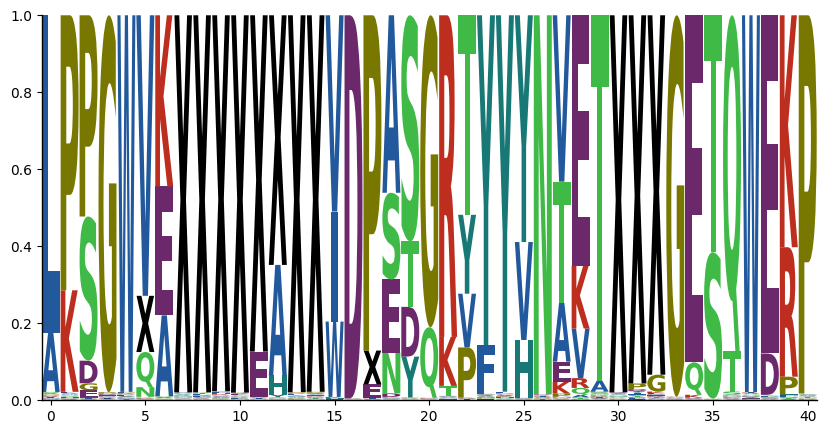

In [6]:
# Loading BLAT dataset
deepseq = DeepSequence(seq_size, args.latent_dim, alphabets, device = device)
optimizer_deepseq = torch.optim.AdamW(deepseq.parameters(), lr=args.lr*0.1)
loss_function = LossFunctionsAlternatives()
pretrained_deepseq_path = logdir + "/" + outmodel_name
check_parameter_historic = []

casted_device = "cuda" if device=="gpu" or device=="cuda" else "cpu" if device=='cpu'else 'mps'

if os.path.isfile(pretrained_deepseq_path):
    print ("Loading Deformation Model...")
    deepseq.load_state_dict( torch.load(pretrained_deepseq_path, map_location=casted_device) )
    print ("Loaded")
    #for param in deepseq.parameters():
    #    param.requires_grad = False
else:
    deepseq.training_representation(trainloader_pretrainer, loss_function, optimizer_deepseq, 1000, 1, logdir=logdir, out_modelname=outmodel_name, beta=1 )
    #check_parameter_historic = list(deepseq.parameters())
    #2500 iters before to make it converge in a good optima
    #for param in deepseq.parameters():
    #    param.requires_grad = False

deepseq(dataset_msa.prot_space)
plot_logos_probs(deepseq(dataset_msa.prot_space)[0], alphabets)


In [7]:
import matplotlib.pyplot as plt
import src.gp_cpab.src.extra.utilities as ut
import matplotlib.gridspec as gridspec
import logomaker 


def get_GPinterpolation(TT, theta, Y, Ug,  n_batch, grid_length_for_GP, seq_len):
    grids_trans_out = (TT.transform_grid(TT.grid,theta)*(seq_len - 1)).squeeze(1)
    # creating the likelihood for interpolation
    batch_Multitask_model, batch_multitask_likelihood = TT.sets_MultioutputGP_per_batches(grids_trans_out, Y, n_batch)
    # To get distribution over Posteriors
    trans_data, _, \
            lower,upper  = TT.predict_operation(Ug, batch_Multitask_model, batch_multitask_likelihood  )
    trans_data = torch.reshape(trans_data, (n_batch, grid_length_for_GP, Y.shape[2]))
    lower = torch.reshape( lower, (n_batch, grid_length_for_GP, Y.shape[2]) )
    upper = torch.reshape( upper, (n_batch, grid_length_for_GP, Y.shape[2]) )

    return grids_trans_out, trans_data, lower, upper

def plot_GP_components_per_seq(Ug, gT, Trdata, Lw, Up, nrows, ncols, alphabets, title, fig):

    for j, axs in enumerate(fig.axes[(nrows-1)*ncols : nrows*ncols]):
        axs.plot( Ug.flatten().detach().numpy(), Trdata[:,j].detach().numpy(), 'b' )
        axs.fill_between(Ug.flatten().detach().numpy(), Lw[:,j].detach().numpy(),  Up[:,j].detach().numpy(), alpha=0.3)
        axs.legend([ 'Mean'])
        axs.set_xticks( Ug.flatten().detach().numpy(), minor= True )
        axs.axhline(0, color='grey', linewidth=0.8)
        axs.set_title(alphabets[j])
    
    #fig.tight_layout()
    
 
def create_gridSpec_graphs(ncols=4,nrows=2,figsize=(25,12)):
    fig = plt.figure(figsize=figsize) #(constrained_layout=True)
    gs = gridspec.GridSpec(ncols=ncols, nrows=nrows, figure=fig)
    for i in range(0, nrows):
        for j in range(0,ncols):
            fig.add_subplot(gs[i, j])
    return fig, gs

def plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig2):
    for cont,(U,gT, Trdata,Lw,Up) in enumerate(list(zip(Ug,grids_trans_out, trans_data,lower,upper))):
        title='sequence {0}'.format(cont+1)
        plot_GP_components_per_seq(U, gT, Trdata, Lw, Up, cont+1, Trdata.shape[1], alphabets=alphabets, title=title, fig = fig2)

def heatmap_from_tensor_tmp(data, alphabet, title):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    figure, ax = plt.subplots(figsize=(8,10))
    #ax = plt.axes()
    px = pd.DataFrame(data, columns=alphabet)
    ff=sns.heatmap(px, linewidth=1, linecolor='w', annot=data, ax = ax)
    ax.set_title(title)
    plt.show()

def plot_msa_from_preds(ts_aligned, alphabet, figsize = (5,4), show_axis=True):
    fig, gs = create_gridSpec_graphs(ncols=1,nrows=ts_aligned.shape[0], figsize=figsize); fig.suptitle('MSA', fontsize='large')

    alphabets_logo = [ i if i!='-' else 'X' for i in alphabet] 
    for cont, x_aligned in enumerate(ts_aligned):
        domain_info_df = df_construction_aas([ x_aligned.unsqueeze(0).detach().numpy() ], x_aligned.unsqueeze(0).shape, alphabets_logo)
        
        if show_axis == False:
            fig.axes[cont].get_xaxis().set_visible(False)
            fig.axes[cont].get_yaxis().set_visible(False)

        logomaker.Logo(domain_info_df,
                          color_scheme = 'NajafabadiEtAl2017',
                          ax = fig.axes[cont],
                          figsize=figsize, show_spines=False)



# recon_data_train = model(dataset_msa.prot_space, deepseq)
def get_GP_behavior_from_model_alignment(data,model, DS, len_grid = 13 , alphabets=['-','L','Q','R']):
    model.eval()
    Y = data
    recon_data_train = model(data, DS)

    x1_trans = recon_data_train[5]

    out_DS_before_dir_trans = DS(x1_trans)[0]

    TT=model.stn.st_gp_cpab
    TT.interpolation_type = 'GP'
    grid_length_for_GP = len_grid


    #get the transformation from Big model
    _, theta = model.sample_only_trans(Y)
    seq_len = Y.shape[1]; n_batch = Y.shape[0]

    ''' info about initial deformation '''
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''
    initialTT_raw = TT.grid
    initialTT_inv = TT.transform_grid(TT.grid,-theta)
    initialTT_dir = TT.transform_grid(TT.grid,theta)
    forward = torch.stack([initialTT_raw.flatten() ,initialTT_inv.flatten(), (initialTT_inv*(x1_trans.shape[1]-1)).flatten() ]).T
    backward = torch.stack([initialTT_raw.flatten() ,initialTT_dir.flatten(), (initialTT_dir*(x1_trans.shape[1]-1)).flatten() ]).T
    heatmap_from_tensor_tmp(forward.detach().numpy(), ['input','raw','scaled'], 'FORWARD SCHEME' )
    heatmap_from_tensor_tmp(backward.detach().numpy(), ['input','raw','scaled'], 'BACKWARD SCHEME' )
    '''----------------------------------------------------------------------------------------------------------------------------------------------------------------------'''

    # grid creations and deformations based on theta estimated from big model

    Ug=TT.uniform_meshgrid((grid_length_for_GP,grid_length_for_GP)).repeat(n_batch,1,1)*(seq_len - 1)
    
    grids_trans_out, trans_data, lower, upper = get_GPinterpolation(TT, -theta, Y, Ug, n_batch, grid_length_for_GP, seq_len)
    grids_dir_trans_out, dir_trans_data, lower_dir, upper_dir = get_GPinterpolation(TT, theta, out_DS_before_dir_trans, Ug, n_batch, grid_length_for_GP, seq_len)

    ncols= grids_trans_out.shape[-1]; nrows = Ug.shape[0]
    fig, gs = create_gridSpec_graphs(ncols=ncols,nrows=nrows, figsize=(25,20)); fig.suptitle('Sequence Alignment by Transformation', fontsize='large')
    figdir, gsdir = create_gridSpec_graphs(ncols=ncols,nrows=nrows,figsize=(25,20)); figdir.suptitle('Sequence Reconstruction', fontsize='large')
    
    plot_GP_components_alignment_channel(Ug,grids_trans_out, trans_data,lower,upper, fig)
    plot_GP_components_alignment_channel(Ug,grids_dir_trans_out, dir_trans_data,lower_dir,upper_dir, figdir)



#x = deepseq(trainloader_pretrainer.dataset.prot_space)
#plot_msa_from_preds(x[0], alphabets, figsize=(15,10), show_axis=False)



In [8]:
import time

def update_behavior_loss_batches(batch_loss_dict, batch_key, batch_historical):
    if batch_key not in batch_loss_dict:
        batch_loss_dict[batch_key] =  [batch_historical]
    else:
        batch_loss_dict[batch_key].append(batch_historical)

def batch_plots(batch_loss_dict):
    import matplotlib.pyplot as plt

    if len(batch_loss_dict.keys())==1:
         values= batch_loss_dict[ list(batch_loss_dict.keys())[0] ]
         epochs_i = list(range(0,len(values)))
         plt.plot(epochs_i, values)
    else:
        fig, ax = plt.subplots(len(batch_loss_dict.keys()),1, figsize=(4,10))
        fig.tight_layout()

        for i in batch_loss_dict.keys():
            y = batch_loss_dict[i]
            x = list(range(0,len(y)))
            ax[i].set_title('Batch ' + str(i))
            ax[i].plot(x,y)

    plt.show()
        
def fit_VITAE_with_pretrained_DeepSeq(trainloader, optimizer, model, DS, n_epochs=10, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10000, **kargs):
        """ Fits the supplied model to a training set 
        Arguments:
            trainloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the training data
            n_epochs: integer, number of epochs to run
            warmup: integer, the KL terms are weighted by epoch/warmup, so this
                number determines the number of epochs before the KL-terms are 
                fully activated in the loss function
            logdir: str, where to store the results
            testloader: dataloader (of type torch.utils.data.DataLoader) that
                contains the test data
            eq_samples: integer, number of equality samples which the expectation
                is calculated over
            iw_samples: integer, number of samples the mean-log is calculated over
            eval_epoch: how many epochs that should pass between calculating the
                L5000 loglikelihood (very expensive to do)
        """

        # Assert that input is okay
        assert isinstance(trainloader, torch.utils.data.DataLoader), '''Trainloader
            should be an instance of torch.utils.data.DataLoader '''
        assert warmup <= n_epochs, ''' Warmup period need to be smaller than the
            number of epochs '''
    
        # Print stats
        print('Number of training points: ', len(trainloader.dataset.prot_space))
        if testloader: print('Number of test points:     ', len(testloader.dataset))
        
        loss_function = LossFunctionsAlternatives()

        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=550, gamma=0.1)
        #import ipdb; ipdb.set_trace()

        # Main loop
        start = time.time()
        for epoch in range(1, n_epochs+1):
            progress_bar = tqdm(desc='Epoch ' + str(epoch) + '/' + str(n_epochs), 
                                total=len(trainloader.dataset), unit='samples')
            train_loss = 0
            # Training loop
            #self.model.train()
            # Decay Learning Rate
            #scheduler.step()

            if epoch == 205:
                 print('From Here')
            for i, data in enumerate(trainloader):
                # Zero gradient
                optimizer.zero_grad()

                # Feed forward data
                data = data.to(torch.float32)#.to(device)

                switch = 1.0 if epoch > warmup else 0.0
                out = model(data, DS, eq_samples, iw_samples, switch)
                
                # Calculat loss
                loss = loss_function(method = 'CE', input = out[0], target = data, forw_per=(0,2,1)) - beta*out[7]
                #loss = loss_function(method = 'JSD', input = out[0], target = data, forw_per=(0,2,1)) # - out[7]

                
                # Backpropegate and optimize
                loss.backward()
                #torch.nn.utils.clip_grad_value_(model.parameters(), 0.5)

                ### UPDATE MODEL PARAMETERS                
                optimizer.step()

                
                #########################################################
                #########################################################
                ### GRADIENT CLIPPING
                #torch.nn.utils.clip_grad_value_(model.parameters(), 1.)
                #torch.nn.utils.clip_grad_norm_(model.parameters(), 1., norm_type=2)
                #########################################################
                #########################################################

                # Write to consoeeeddddddddwwww######hhhdffffffffffsssswqqq#l#
                progress_bar.update(data.size(0))
                progress_bar.set_postfix({'loss': str(loss.item())  })
                #progress_bar.set_postfix({'loss': str(loss.item()) + ', lr rate: ' + str(scheduler.get_lr()[-1]) })
                update_behavior_loss_batches(batch_loss_dict, i, loss.item())
                
                # Save to tensorboard
                iteration = epoch*len(trainloader) + i
                
                gc.collect()
                torch.cuda.empty_cache()

            progress_bar.close()
        
        print('Total train time', time.time() - start)
        #import pdb;pdb.set_trace()
        # Save the embeddings

In [9]:

batch_loss_dict = {}
#import ipdb; ipdb.set_trace()

# Construct model
# I do not add the pretrained deepsequence module to avoid 
# the backpropagation of such module during the optimization
model = PGM_LA_latent_alignment(
                    input_shape = seq_size, #img_size,
                    config = std, 
                    latent_dim = args.latent_dim, 
                    encoder = get_encoder( args.ed_type.split(",")[0] ), 
                    decoder = get_decoder( args.ed_type.split(",")[1] ),
                    outputdensity = args.density,
                    ST_type = args.stn_type,
                    alphabet_size = len(c2i),
                    trans_parameters = ( [window_grid], device, gp_params ),
                    diagonal_att_regions = [-25,25])#[-245,245] [-15,15] ) #[15,15] #if we increase it, major accuracy

#model.get_deepsequence_module(deepseq)

# Optimizer
opt = torch.optim.AdamW(model.parameters(), lr=1e-4)#, weight_decay=1e-5)#lr=1e-3 also works but we have to test with seed samples
model_name = '/trained_model_softmax.pt'

fit_VITAE_with_pretrained_DeepSeq(trainloader, opt, model, deepseq, n_epochs=500, warmup=1, logdir='',
            testloader=None, eq_samples=1, iw_samples=1, beta=1.0, eval_epoch=10) # initi

/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


/home/kvr226/miniconda3/envs/PGM_latent_alignment/lib/python3.8/site-packages/torch/utils/cpp_extension.py:283: UserWarning: 

                               !! WARNING !!

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Your compiler (c++) is not compatible with the compiler Pytorch was
built with for this platform, which is g++ on linux. Please
use g++ to to compile your extension. Alternatively, you may
compile PyTorch from source using c++, and then you can also use
c++ to compile your extension.

See https://github.com/pytorch/pytorch/blob/master/CONTRIBUTING.md for help
with compiling PyTorch from source.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

                              !! WARNING !!

  warnings.warn(WRONG_COMPILER_WARNING.format(


Number of training points:  40


Epoch 1/500:   0%|          | 0/40 [00:00<?, ?samples/s]

/home/kvr226/Explicit_Disentanglement_Molecules/src/gp_cpab/src/transformation/libcpab/libcpab/pytorch/functions.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x, dtype=dtype, device=device)


/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:298: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_mean = torch.tensor(x_mean_no_grad, requires_grad=True)
/home/kvr226/Explicit_Disentanglement_Molecules/src/models/experimental/PGM_LA_latent_alignment.py:299: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_var = torch.tensor(x_var_no_grad, requires_grad=True)


Epoch 1/500:  25%|██▌       | 10/40 [00:01<00:03,  8.23samples/s]

Epoch 1/500:  25%|██▌       | 10/40 [00:01<00:03,  8.23samples/s, loss=1243.2203369140625]

Epoch 1/500:  50%|█████     | 20/40 [00:02<00:02,  9.36samples/s, loss=1243.2203369140625]

Epoch 1/500:  50%|█████     | 20/40 [00:02<00:02,  9.36samples/s, loss=1245.83642578125]  

Epoch 1/500:  75%|███████▌  | 30/40 [00:03<00:01,  9.80samples/s, loss=1245.83642578125]

Epoch 1/500:  75%|███████▌  | 30/40 [00:03<00:01,  9.80samples/s, loss=1250.2320556640625]

Epoch 1/500: 100%|██████████| 40/40 [00:04<00:00, 10.05samples/s, loss=1250.2320556640625]

Epoch 1/500: 100%|██████████| 40/40 [00:04<00:00, 10.05samples/s, loss=1247.8443603515625]

Epoch 1/500: 100%|██████████| 40/40 [00:04<00:00,  9.53samples/s, loss=1247.8443603515625]

Epoch 2/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 2/500:  25%|██▌       | 10/40 [00:00<00:02, 11.67samples/s]

Epoch 2/500:  25%|██▌       | 10/40 [00:00<00:02, 11.67samples/s, loss=1243.17578125]

Epoch 2/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1243.17578125]

Epoch 2/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1246.87744140625]

Epoch 2/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1246.87744140625]

Epoch 2/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1240.7052001953125]

Epoch 2/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1240.7052001953125]

Epoch 2/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1243.163818359375] 

Epoch 2/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1243.163818359375]

Epoch 3/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 3/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s]

Epoch 3/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s, loss=1239.8900146484375]

Epoch 3/500:  50%|█████     | 20/40 [00:01<00:01, 10.93samples/s, loss=1239.8900146484375]

Epoch 3/500:  50%|█████     | 20/40 [00:01<00:01, 10.93samples/s, loss=1245.3729248046875]

Epoch 3/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1245.3729248046875]

Epoch 3/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1240.505615234375] 

Epoch 3/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1240.505615234375]

Epoch 3/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1242.9852294921875]

Epoch 3/500: 100%|██████████| 40/40 [00:03<00:00, 10.46samples/s, loss=1242.9852294921875]

Epoch 4/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 4/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 4/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1230.8970947265625]

Epoch 4/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1230.8970947265625]

Epoch 4/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1235.4349365234375]

Epoch 4/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1235.4349365234375]

Epoch 4/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1242.254638671875] 

Epoch 4/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1242.254638671875]

Epoch 4/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1239.2435302734375]

Epoch 4/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1239.2435302734375]

Epoch 5/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 5/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s]

Epoch 5/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s, loss=1226.8238525390625]

Epoch 5/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1226.8238525390625]

Epoch 5/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1234.022216796875] 

Epoch 5/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1234.022216796875]

Epoch 5/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1235.24609375]    

Epoch 5/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1235.24609375]

Epoch 5/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1232.1312255859375]

Epoch 5/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1232.1312255859375]

Epoch 6/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 6/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 6/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1221.3670654296875]

Epoch 6/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1221.3670654296875]

Epoch 6/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1227.61669921875]  

Epoch 6/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1227.61669921875]

Epoch 6/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1229.6712646484375]

Epoch 6/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1229.6712646484375]

Epoch 6/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1230.7410888671875]

Epoch 6/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1230.7410888671875]

Epoch 7/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 7/500:  25%|██▌       | 10/40 [00:00<00:02, 11.43samples/s]

Epoch 7/500:  25%|██▌       | 10/40 [00:00<00:02, 11.43samples/s, loss=1210.0673828125]

Epoch 7/500:  50%|█████     | 20/40 [00:01<00:01, 10.78samples/s, loss=1210.0673828125]

Epoch 7/500:  50%|█████     | 20/40 [00:01<00:01, 10.78samples/s, loss=1225.16162109375]

Epoch 7/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.70samples/s, loss=1225.16162109375]

Epoch 7/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.70samples/s, loss=1221.5545654296875]

Epoch 7/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1221.5545654296875]

Epoch 7/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1225.382080078125] 

Epoch 7/500: 100%|██████████| 40/40 [00:03<00:00, 10.44samples/s, loss=1225.382080078125]

Epoch 8/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 8/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 8/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1211.9759521484375]

Epoch 8/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1211.9759521484375]

Epoch 8/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1216.326904296875] 

Epoch 8/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1216.326904296875]

Epoch 8/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1214.5821533203125]

Epoch 8/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1214.5821533203125]

Epoch 8/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1216.5992431640625]

Epoch 8/500: 100%|██████████| 40/40 [00:03<00:00, 10.41samples/s, loss=1216.5992431640625]

Epoch 9/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 9/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s]

Epoch 9/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s, loss=1201.04736328125]

Epoch 9/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1201.04736328125]

Epoch 9/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1209.9195556640625]

Epoch 9/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1209.9195556640625]

Epoch 9/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1206.1845703125]   

Epoch 9/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1206.1845703125]

Epoch 9/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1208.27294921875]

Epoch 9/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1208.27294921875]

Epoch 10/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 10/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s]

Epoch 10/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s, loss=1195.576904296875]

Epoch 10/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1195.576904296875]

Epoch 10/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1199.6983642578125]

Epoch 10/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1199.6983642578125]

Epoch 10/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1189.052734375]    

Epoch 10/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1189.052734375]

Epoch 10/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1195.055908203125]

Epoch 10/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1195.055908203125]

Epoch 11/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 11/500:  25%|██▌       | 10/40 [00:00<00:02, 11.68samples/s]

Epoch 11/500:  25%|██▌       | 10/40 [00:00<00:02, 11.68samples/s, loss=1178.4552001953125]

Epoch 11/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1178.4552001953125]

Epoch 11/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1183.9197998046875]

Epoch 11/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1183.9197998046875]

Epoch 11/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1183.2891845703125]

Epoch 11/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1183.2891845703125]

Epoch 11/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1177.9443359375]   

Epoch 11/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1177.9443359375]

Epoch 12/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 12/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s]

Epoch 12/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s, loss=1164.60205078125]

Epoch 12/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1164.60205078125]

Epoch 12/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1142.291748046875]

Epoch 12/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1142.291748046875]

Epoch 12/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1139.4112548828125]

Epoch 12/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1139.4112548828125]

Epoch 12/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1137.79833984375]  

Epoch 12/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1137.79833984375]

Epoch 13/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 13/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 13/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1142.961669921875]

Epoch 13/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1142.961669921875]

Epoch 13/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1139.427734375]   

Epoch 13/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1139.427734375]

Epoch 13/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1141.668212890625]

Epoch 13/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1141.668212890625]

Epoch 13/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1144.0340576171875]

Epoch 13/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1144.0340576171875]

Epoch 14/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 14/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 14/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1127.842529296875]

Epoch 14/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1127.842529296875]

Epoch 14/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1140.7901611328125]

Epoch 14/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.61samples/s, loss=1140.7901611328125]

Epoch 14/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.61samples/s, loss=1149.037109375]    

Epoch 14/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1149.037109375]

Epoch 14/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1148.51220703125]

Epoch 14/500: 100%|██████████| 40/40 [00:03<00:00, 10.39samples/s, loss=1148.51220703125]

Epoch 15/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 15/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s]

Epoch 15/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s, loss=1131.114013671875]

Epoch 15/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1131.114013671875]

Epoch 15/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1156.5521240234375]

Epoch 15/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1156.5521240234375]

Epoch 15/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1161.7978515625]   

Epoch 15/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1161.7978515625]

Epoch 15/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1148.7734375]   

Epoch 15/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1148.7734375]

Epoch 16/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 16/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s]

Epoch 16/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s, loss=1141.680908203125]

Epoch 16/500:  50%|█████     | 20/40 [00:01<00:01, 11.11samples/s, loss=1141.680908203125]

Epoch 16/500:  50%|█████     | 20/40 [00:01<00:01, 11.11samples/s, loss=1148.205078125]   

Epoch 16/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.88samples/s, loss=1148.205078125]

Epoch 16/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.88samples/s, loss=1159.625732421875]

Epoch 16/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1159.625732421875]

Epoch 16/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1147.6171875]     

Epoch 16/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1147.6171875]

Epoch 17/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 17/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 17/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1135.812744140625]

Epoch 17/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1135.812744140625]

Epoch 17/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1154.2740478515625]

Epoch 17/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1154.2740478515625]

Epoch 17/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1155.8470458984375]

Epoch 17/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1155.8470458984375]

Epoch 17/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1142.6688232421875]

Epoch 17/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1142.6688232421875]

Epoch 18/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 18/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s]

Epoch 18/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s, loss=1136.300048828125]

Epoch 18/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1136.300048828125]

Epoch 18/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1155.9605712890625]

Epoch 18/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1155.9605712890625]

Epoch 18/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1157.9139404296875]

Epoch 18/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1157.9139404296875]

Epoch 18/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1138.6094970703125]

Epoch 18/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1138.6094970703125]

Epoch 19/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 19/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s]

Epoch 19/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s, loss=1129.749267578125]

Epoch 19/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1129.749267578125]

Epoch 19/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1143.0555419921875]

Epoch 19/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1143.0555419921875]

Epoch 19/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1151.2615966796875]

Epoch 19/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1151.2615966796875]

Epoch 19/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1136.8897705078125]

Epoch 19/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1136.8897705078125]

Epoch 20/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 20/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s]

Epoch 20/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s, loss=1142.1072998046875]

Epoch 20/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1142.1072998046875]

Epoch 20/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1132.21240234375]  

Epoch 20/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1132.21240234375]

Epoch 20/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1148.3211669921875]

Epoch 20/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1148.3211669921875]

Epoch 20/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1133.519775390625] 

Epoch 20/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1133.519775390625]

Epoch 21/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 21/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s]

Epoch 21/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s, loss=1117.944091796875]

Epoch 21/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1117.944091796875]

Epoch 21/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1147.503173828125]

Epoch 21/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1147.503173828125]

Epoch 21/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1147.1314697265625]

Epoch 21/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1147.1314697265625]

Epoch 21/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1130.9056396484375]

Epoch 21/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1130.9056396484375]

Epoch 22/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 22/500:  25%|██▌       | 10/40 [00:00<00:02, 11.57samples/s]

Epoch 22/500:  25%|██▌       | 10/40 [00:00<00:02, 11.57samples/s, loss=1130.4876708984375]

Epoch 22/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1130.4876708984375]

Epoch 22/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1141.6068115234375]

Epoch 22/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1141.6068115234375]

Epoch 22/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1135.5750732421875]

Epoch 22/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1135.5750732421875]

Epoch 22/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1136.61962890625]  

Epoch 22/500: 100%|██████████| 40/40 [00:03<00:00, 10.41samples/s, loss=1136.61962890625]

Epoch 23/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 23/500:  25%|██▌       | 10/40 [00:00<00:02, 11.65samples/s]

Epoch 23/500:  25%|██▌       | 10/40 [00:00<00:02, 11.65samples/s, loss=1130.548583984375]

Epoch 23/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1130.548583984375]

Epoch 23/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1139.5179443359375]

Epoch 23/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1139.5179443359375]

Epoch 23/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1143.2349853515625]

Epoch 23/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1143.2349853515625]

Epoch 23/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1145.2154541015625]

Epoch 23/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1145.2154541015625]

Epoch 24/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 24/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 24/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1133.302490234375]

Epoch 24/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1133.302490234375]

Epoch 24/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1136.4271240234375]

Epoch 24/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1136.4271240234375]

Epoch 24/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1140.009521484375] 

Epoch 24/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1140.009521484375]

Epoch 24/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1123.30615234375] 

Epoch 24/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1123.30615234375]

Epoch 25/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 25/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s]

Epoch 25/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s, loss=1124.346923828125]

Epoch 25/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1124.346923828125]

Epoch 25/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1130.6405029296875]

Epoch 25/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.69samples/s, loss=1130.6405029296875]

Epoch 25/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.69samples/s, loss=1136.6099853515625]

Epoch 25/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1136.6099853515625]

Epoch 25/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1142.8671875]      

Epoch 25/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1142.8671875]

Epoch 26/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 26/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s]

Epoch 26/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s, loss=1124.081298828125]

Epoch 26/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1124.081298828125]

Epoch 26/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1133.4527587890625]

Epoch 26/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1133.4527587890625]

Epoch 26/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1142.9228515625]   

Epoch 26/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1142.9228515625]

Epoch 26/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1121.378173828125]

Epoch 26/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1121.378173828125]

Epoch 27/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 27/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s]

Epoch 27/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s, loss=1138.6173095703125]

Epoch 27/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1138.6173095703125]

Epoch 27/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1131.45849609375]  

Epoch 27/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.88samples/s, loss=1131.45849609375]

Epoch 27/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.88samples/s, loss=1135.1783447265625]

Epoch 27/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1135.1783447265625]

Epoch 27/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1130.787841796875] 

Epoch 27/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1130.787841796875]

Epoch 28/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 28/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s]

Epoch 28/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s, loss=1129.5301513671875]

Epoch 28/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1129.5301513671875]

Epoch 28/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1134.54443359375]  

Epoch 28/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1134.54443359375]

Epoch 28/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1139.8153076171875]

Epoch 28/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1139.8153076171875]

Epoch 28/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1134.2305908203125]

Epoch 28/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1134.2305908203125]

Epoch 29/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 29/500:  25%|██▌       | 10/40 [00:00<00:02, 11.71samples/s]

Epoch 29/500:  25%|██▌       | 10/40 [00:00<00:02, 11.71samples/s, loss=1118.4534912109375]

Epoch 29/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1118.4534912109375]

Epoch 29/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1135.689453125]    

Epoch 29/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1135.689453125]

Epoch 29/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1144.4453125]  

Epoch 29/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1144.4453125]

Epoch 29/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1128.1390380859375]

Epoch 29/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1128.1390380859375]

Epoch 30/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 30/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 30/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1125.10302734375]

Epoch 30/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1125.10302734375]

Epoch 30/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1142.0447998046875]

Epoch 30/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1142.0447998046875]

Epoch 30/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1142.73486328125]  

Epoch 30/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1142.73486328125]

Epoch 30/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1131.93896484375]

Epoch 30/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1131.93896484375]

Epoch 31/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 31/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 31/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1133.644775390625]

Epoch 31/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1133.644775390625]

Epoch 31/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1130.65185546875] 

Epoch 31/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1130.65185546875]

Epoch 31/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1140.3824462890625]

Epoch 31/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1140.3824462890625]

Epoch 31/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1130.5457763671875]

Epoch 31/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1130.5457763671875]

Epoch 32/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 32/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s]

Epoch 32/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s, loss=1133.4139404296875]

Epoch 32/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1133.4139404296875]

Epoch 32/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1140.3443603515625]

Epoch 32/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1140.3443603515625]

Epoch 32/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1148.542236328125] 

Epoch 32/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1148.542236328125]

Epoch 32/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1136.3917236328125]

Epoch 32/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1136.3917236328125]

Epoch 33/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 33/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 33/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1130.871826171875]

Epoch 33/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1130.871826171875]

Epoch 33/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1147.48583984375] 

Epoch 33/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1147.48583984375]

Epoch 33/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1148.4176025390625]

Epoch 33/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1148.4176025390625]

Epoch 33/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1128.4620361328125]

Epoch 33/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1128.4620361328125]

Epoch 34/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 34/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 34/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1125.6895751953125]

Epoch 34/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1125.6895751953125]

Epoch 34/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1126.9178466796875]

Epoch 34/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1126.9178466796875]

Epoch 34/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1140.6998291015625]

Epoch 34/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1140.6998291015625]

Epoch 34/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1136.6202392578125]

Epoch 34/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1136.6202392578125]

Epoch 35/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 35/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s]

Epoch 35/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s, loss=1130.8984375]

Epoch 35/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1130.8984375]

Epoch 35/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1135.9189453125]

Epoch 35/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1135.9189453125]

Epoch 35/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1136.7435302734375]

Epoch 35/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1136.7435302734375]

Epoch 35/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1124.078857421875] 

Epoch 35/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1124.078857421875]

Epoch 36/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 36/500:  25%|██▌       | 10/40 [00:00<00:02, 11.90samples/s]

Epoch 36/500:  25%|██▌       | 10/40 [00:00<00:02, 11.90samples/s, loss=1130.9434814453125]

Epoch 36/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1130.9434814453125]

Epoch 36/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1124.392822265625] 

Epoch 36/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1124.392822265625]

Epoch 36/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1125.75439453125] 

Epoch 36/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1125.75439453125]

Epoch 36/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1123.2626953125] 

Epoch 36/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1123.2626953125]

Epoch 37/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 37/500:  25%|██▌       | 10/40 [00:00<00:02, 11.90samples/s]

Epoch 37/500:  25%|██▌       | 10/40 [00:00<00:02, 11.90samples/s, loss=1127.143310546875]

Epoch 37/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1127.143310546875]

Epoch 37/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1137.375244140625]

Epoch 37/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1137.375244140625]

Epoch 37/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1143.1015625]     

Epoch 37/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1143.1015625]

Epoch 37/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1120.98095703125]

Epoch 37/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1120.98095703125]

Epoch 38/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 38/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s]

Epoch 38/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s, loss=1121.7958984375]

Epoch 38/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1121.7958984375]

Epoch 38/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1129.876708984375]

Epoch 38/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1129.876708984375]

Epoch 38/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1131.84765625]    

Epoch 38/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1131.84765625]

Epoch 38/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1139.3106689453125]

Epoch 38/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1139.3106689453125]

Epoch 39/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 39/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 39/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1134.979736328125]

Epoch 39/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1134.979736328125]

Epoch 39/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1122.906494140625]

Epoch 39/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1122.906494140625]

Epoch 39/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1128.8331298828125]

Epoch 39/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1128.8331298828125]

Epoch 39/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1149.22021484375]  

Epoch 39/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1149.22021484375]

Epoch 40/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 40/500:  25%|██▌       | 10/40 [00:00<00:02, 11.60samples/s]

Epoch 40/500:  25%|██▌       | 10/40 [00:00<00:02, 11.60samples/s, loss=1117.1385498046875]

Epoch 40/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1117.1385498046875]

Epoch 40/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1131.4613037109375]

Epoch 40/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1131.4613037109375]

Epoch 40/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1135.287353515625] 

Epoch 40/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1135.287353515625]

Epoch 40/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1134.12646484375] 

Epoch 40/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1134.12646484375]

Epoch 41/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 41/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 41/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1131.3912353515625]

Epoch 41/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1131.3912353515625]

Epoch 41/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1126.727783203125] 

Epoch 41/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1126.727783203125]

Epoch 41/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1133.6478271484375]

Epoch 41/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1133.6478271484375]

Epoch 41/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1131.834228515625] 

Epoch 41/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1131.834228515625]

Epoch 42/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 42/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s]

Epoch 42/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s, loss=1134.6959228515625]

Epoch 42/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1134.6959228515625]

Epoch 42/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1144.784423828125] 

Epoch 42/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1144.784423828125]

Epoch 42/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1125.3519287109375]

Epoch 42/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1125.3519287109375]

Epoch 42/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1139.951171875]    

Epoch 42/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1139.951171875]

Epoch 43/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 43/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s]

Epoch 43/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s, loss=1133.5572509765625]

Epoch 43/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1133.5572509765625]

Epoch 43/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1137.7449951171875]

Epoch 43/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1137.7449951171875]

Epoch 43/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1133.4373779296875]

Epoch 43/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1133.4373779296875]

Epoch 43/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1135.741943359375] 

Epoch 43/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1135.741943359375]

Epoch 44/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 44/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s]

Epoch 44/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s, loss=1119.524658203125]

Epoch 44/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1119.524658203125]

Epoch 44/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1123.7784423828125]

Epoch 44/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1123.7784423828125]

Epoch 44/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1141.1011962890625]

Epoch 44/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1141.1011962890625]

Epoch 44/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1129.9202880859375]

Epoch 44/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1129.9202880859375]

Epoch 45/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 45/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 45/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1124.6575927734375]

Epoch 45/500:  50%|█████     | 20/40 [00:01<00:01, 10.88samples/s, loss=1124.6575927734375]

Epoch 45/500:  50%|█████     | 20/40 [00:01<00:01, 10.88samples/s, loss=1127.468505859375] 

Epoch 45/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1127.468505859375]

Epoch 45/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1132.361083984375]

Epoch 45/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1132.361083984375]

Epoch 45/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1120.2518310546875]

Epoch 45/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1120.2518310546875]

Epoch 46/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 46/500:  25%|██▌       | 10/40 [00:00<00:02, 11.64samples/s]

Epoch 46/500:  25%|██▌       | 10/40 [00:00<00:02, 11.64samples/s, loss=1128.7816162109375]

Epoch 46/500:  50%|█████     | 20/40 [00:01<00:01, 10.89samples/s, loss=1128.7816162109375]

Epoch 46/500:  50%|█████     | 20/40 [00:01<00:01, 10.89samples/s, loss=1145.4677734375]   

Epoch 46/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1145.4677734375]

Epoch 46/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1136.1829833984375]

Epoch 46/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1136.1829833984375]

Epoch 46/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1133.0865478515625]

Epoch 46/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1133.0865478515625]

Epoch 47/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 47/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s]

Epoch 47/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s, loss=1136.0938720703125]

Epoch 47/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1136.0938720703125]

Epoch 47/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1125.855224609375] 

Epoch 47/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1125.855224609375]

Epoch 47/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1138.287841796875]

Epoch 47/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1138.287841796875]

Epoch 47/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1129.14697265625] 

Epoch 47/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1129.14697265625]

Epoch 48/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 48/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s]

Epoch 48/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s, loss=1122.9500732421875]

Epoch 48/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1122.9500732421875]

Epoch 48/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1134.1004638671875]

Epoch 48/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1134.1004638671875]

Epoch 48/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1153.21728515625]  

Epoch 48/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1153.21728515625]

Epoch 48/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1140.221923828125]

Epoch 48/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1140.221923828125]

Epoch 49/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 49/500:  25%|██▌       | 10/40 [00:00<00:02, 11.65samples/s]

Epoch 49/500:  25%|██▌       | 10/40 [00:00<00:02, 11.65samples/s, loss=1117.3209228515625]

Epoch 49/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1117.3209228515625]

Epoch 49/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1137.28369140625]  

Epoch 49/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1137.28369140625]

Epoch 49/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1132.010498046875]

Epoch 49/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1132.010498046875]

Epoch 49/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1140.3966064453125]

Epoch 49/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1140.3966064453125]

Epoch 50/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 50/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s]

Epoch 50/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s, loss=1128.2529296875]

Epoch 50/500:  50%|█████     | 20/40 [00:01<00:01, 10.89samples/s, loss=1128.2529296875]

Epoch 50/500:  50%|█████     | 20/40 [00:01<00:01, 10.89samples/s, loss=1123.6446533203125]

Epoch 50/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1123.6446533203125]

Epoch 50/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1129.9207763671875]

Epoch 50/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1129.9207763671875]

Epoch 50/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1132.907958984375] 

Epoch 50/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1132.907958984375]

Epoch 51/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 51/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 51/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1131.1171875]

Epoch 51/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1131.1171875]

Epoch 51/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1128.2633056640625]

Epoch 51/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1128.2633056640625]

Epoch 51/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1138.9630126953125]

Epoch 51/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1138.9630126953125]

Epoch 51/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1129.509033203125] 

Epoch 51/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1129.509033203125]

Epoch 52/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 52/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 52/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1125.4356689453125]

Epoch 52/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1125.4356689453125]

Epoch 52/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1132.962646484375] 

Epoch 52/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1132.962646484375]

Epoch 52/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1139.6036376953125]

Epoch 52/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1139.6036376953125]

Epoch 52/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1137.79833984375]  

Epoch 52/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1137.79833984375]

Epoch 53/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 53/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 53/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1125.8458251953125]

Epoch 53/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1125.8458251953125]

Epoch 53/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1124.8665771484375]

Epoch 53/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1124.8665771484375]

Epoch 53/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1130.5704345703125]

Epoch 53/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1130.5704345703125]

Epoch 53/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1126.6827392578125]

Epoch 53/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1126.6827392578125]

Epoch 54/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 54/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 54/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1126.342041015625]

Epoch 54/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1126.342041015625]

Epoch 54/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1134.777099609375]

Epoch 54/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.70samples/s, loss=1134.777099609375]

Epoch 54/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.70samples/s, loss=1129.88134765625] 

Epoch 54/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1129.88134765625]

Epoch 54/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1121.563720703125]

Epoch 54/500: 100%|██████████| 40/40 [00:03<00:00, 10.44samples/s, loss=1121.563720703125]

Epoch 55/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 55/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s]

Epoch 55/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s, loss=1126.6763916015625]

Epoch 55/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1126.6763916015625]

Epoch 55/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1122.01025390625]  

Epoch 55/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1122.01025390625]

Epoch 55/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1131.23193359375]

Epoch 55/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1131.23193359375]

Epoch 55/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1125.5802001953125]

Epoch 55/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1125.5802001953125]

Epoch 56/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 56/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 56/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1129.0736083984375]

Epoch 56/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1129.0736083984375]

Epoch 56/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1132.7381591796875]

Epoch 56/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1132.7381591796875]

Epoch 56/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1134.6812744140625]

Epoch 56/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1134.6812744140625]

Epoch 56/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1126.157470703125] 

Epoch 56/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1126.157470703125]

Epoch 57/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 57/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s]

Epoch 57/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s, loss=1116.8768310546875]

Epoch 57/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1116.8768310546875]

Epoch 57/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1128.845458984375] 

Epoch 57/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1128.845458984375]

Epoch 57/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1133.347900390625]

Epoch 57/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1133.347900390625]

Epoch 57/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1123.054931640625]

Epoch 57/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1123.054931640625]

Epoch 58/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 58/500:  25%|██▌       | 10/40 [00:00<00:02, 11.73samples/s]

Epoch 58/500:  25%|██▌       | 10/40 [00:00<00:02, 11.73samples/s, loss=1127.293701171875]

Epoch 58/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1127.293701171875]

Epoch 58/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1131.8035888671875]

Epoch 58/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1131.8035888671875]

Epoch 58/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1129.5400390625]   

Epoch 58/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1129.5400390625]

Epoch 58/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1131.8662109375]

Epoch 58/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1131.8662109375]

Epoch 59/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 59/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s]

Epoch 59/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s, loss=1119.97998046875]

Epoch 59/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1119.97998046875]

Epoch 59/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1128.7418212890625]

Epoch 59/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1128.7418212890625]

Epoch 59/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1129.167724609375] 

Epoch 59/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1129.167724609375]

Epoch 59/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1125.27978515625] 

Epoch 59/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1125.27978515625]

Epoch 60/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 60/500:  25%|██▌       | 10/40 [00:00<00:02, 11.65samples/s]

Epoch 60/500:  25%|██▌       | 10/40 [00:00<00:02, 11.65samples/s, loss=1122.3177490234375]

Epoch 60/500:  50%|█████     | 20/40 [00:01<00:01, 10.93samples/s, loss=1122.3177490234375]

Epoch 60/500:  50%|█████     | 20/40 [00:01<00:01, 10.93samples/s, loss=1121.6378173828125]

Epoch 60/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1121.6378173828125]

Epoch 60/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1138.3251953125]   

Epoch 60/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1138.3251953125]

Epoch 60/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1123.4189453125]

Epoch 60/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1123.4189453125]

Epoch 61/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 61/500:  25%|██▌       | 10/40 [00:00<00:02, 11.57samples/s]

Epoch 61/500:  25%|██▌       | 10/40 [00:00<00:02, 11.57samples/s, loss=1138.859619140625]

Epoch 61/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1138.859619140625]

Epoch 61/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1129.7506103515625]

Epoch 61/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1129.7506103515625]

Epoch 61/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1130.5322265625]   

Epoch 61/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1130.5322265625]

Epoch 61/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1130.0333251953125]

Epoch 61/500: 100%|██████████| 40/40 [00:03<00:00, 10.47samples/s, loss=1130.0333251953125]

Epoch 62/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 62/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 62/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1122.0201416015625]

Epoch 62/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1122.0201416015625]

Epoch 62/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1127.8895263671875]

Epoch 62/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1127.8895263671875]

Epoch 62/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1131.2515869140625]

Epoch 62/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1131.2515869140625]

Epoch 62/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1121.9495849609375]

Epoch 62/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1121.9495849609375]

Epoch 63/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 63/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 63/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1124.0692138671875]

Epoch 63/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1124.0692138671875]

Epoch 63/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1129.96484375]     

Epoch 63/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1129.96484375]

Epoch 63/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1129.6007080078125]

Epoch 63/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1129.6007080078125]

Epoch 63/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1124.7645263671875]

Epoch 63/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1124.7645263671875]

Epoch 64/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 64/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 64/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1129.4520263671875]

Epoch 64/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1129.4520263671875]

Epoch 64/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1125.130615234375] 

Epoch 64/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1125.130615234375]

Epoch 64/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1132.0482177734375]

Epoch 64/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1132.0482177734375]

Epoch 64/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1123.6761474609375]

Epoch 64/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1123.6761474609375]

Epoch 65/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 65/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 65/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1127.5401611328125]

Epoch 65/500:  50%|█████     | 20/40 [00:01<00:01, 11.10samples/s, loss=1127.5401611328125]

Epoch 65/500:  50%|█████     | 20/40 [00:01<00:01, 11.10samples/s, loss=1134.3079833984375]

Epoch 65/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1134.3079833984375]

Epoch 65/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1136.03076171875]  

Epoch 65/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1136.03076171875]

Epoch 65/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1127.310302734375]

Epoch 65/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1127.310302734375]

Epoch 66/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 66/500:  25%|██▌       | 10/40 [00:00<00:02, 11.63samples/s]

Epoch 66/500:  25%|██▌       | 10/40 [00:00<00:02, 11.63samples/s, loss=1119.645263671875]

Epoch 66/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1119.645263671875]

Epoch 66/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1124.1785888671875]

Epoch 66/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1124.1785888671875]

Epoch 66/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1134.1953125]      

Epoch 66/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1134.1953125]

Epoch 66/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1127.94775390625]

Epoch 66/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1127.94775390625]

Epoch 67/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 67/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s]

Epoch 67/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s, loss=1122.67578125]

Epoch 67/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1122.67578125]

Epoch 67/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1122.3037109375]

Epoch 67/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1122.3037109375]

Epoch 67/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1146.3419189453125]

Epoch 67/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1146.3419189453125]

Epoch 67/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1132.1080322265625]

Epoch 67/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1132.1080322265625]

Epoch 68/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 68/500:  25%|██▌       | 10/40 [00:00<00:02, 11.64samples/s]

Epoch 68/500:  25%|██▌       | 10/40 [00:00<00:02, 11.64samples/s, loss=1123.7601318359375]

Epoch 68/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1123.7601318359375]

Epoch 68/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1134.1055908203125]

Epoch 68/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1134.1055908203125]

Epoch 68/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1141.422607421875] 

Epoch 68/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1141.422607421875]

Epoch 68/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1129.9227294921875]

Epoch 68/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1129.9227294921875]

Epoch 69/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 69/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s]

Epoch 69/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s, loss=1122.2579345703125]

Epoch 69/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1122.2579345703125]

Epoch 69/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1124.610107421875] 

Epoch 69/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1124.610107421875]

Epoch 69/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1132.1038818359375]

Epoch 69/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1132.1038818359375]

Epoch 69/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1125.1612548828125]

Epoch 69/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1125.1612548828125]

Epoch 70/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 70/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s]

Epoch 70/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s, loss=1133.0113525390625]

Epoch 70/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1133.0113525390625]

Epoch 70/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1132.3255615234375]

Epoch 70/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.70samples/s, loss=1132.3255615234375]

Epoch 70/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.70samples/s, loss=1138.6624755859375]

Epoch 70/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1138.6624755859375]

Epoch 70/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1131.68115234375]  

Epoch 70/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1131.68115234375]

Epoch 71/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 71/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s]

Epoch 71/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s, loss=1128.00830078125]

Epoch 71/500:  50%|█████     | 20/40 [00:01<00:01, 11.11samples/s, loss=1128.00830078125]

Epoch 71/500:  50%|█████     | 20/40 [00:01<00:01, 11.11samples/s, loss=1132.4324951171875]

Epoch 71/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.90samples/s, loss=1132.4324951171875]

Epoch 71/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.90samples/s, loss=1133.801025390625] 

Epoch 71/500: 100%|██████████| 40/40 [00:03<00:00, 10.79samples/s, loss=1133.801025390625]

Epoch 71/500: 100%|██████████| 40/40 [00:03<00:00, 10.79samples/s, loss=1118.9554443359375]

Epoch 71/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1118.9554443359375]

Epoch 72/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 72/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s]

Epoch 72/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s, loss=1129.716064453125]

Epoch 72/500:  50%|█████     | 20/40 [00:01<00:01, 11.10samples/s, loss=1129.716064453125]

Epoch 72/500:  50%|█████     | 20/40 [00:01<00:01, 11.10samples/s, loss=1124.90087890625] 

Epoch 72/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1124.90087890625]

Epoch 72/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1134.4879150390625]

Epoch 72/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1134.4879150390625]

Epoch 72/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1127.631103515625] 

Epoch 72/500: 100%|██████████| 40/40 [00:03<00:00, 10.62samples/s, loss=1127.631103515625]

Epoch 73/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 73/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 73/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1122.970703125]

Epoch 73/500:  50%|█████     | 20/40 [00:01<00:01, 11.10samples/s, loss=1122.970703125]

Epoch 73/500:  50%|█████     | 20/40 [00:01<00:01, 11.10samples/s, loss=1130.8524169921875]

Epoch 73/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1130.8524169921875]

Epoch 73/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1130.84326171875]  

Epoch 73/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1130.84326171875]

Epoch 73/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1128.0140380859375]

Epoch 73/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1128.0140380859375]

Epoch 74/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 74/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 74/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1127.2125244140625]

Epoch 74/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1127.2125244140625]

Epoch 74/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1128.793212890625] 

Epoch 74/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1128.793212890625]

Epoch 74/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1138.127197265625]

Epoch 74/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1138.127197265625]

Epoch 74/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1124.14990234375] 

Epoch 74/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1124.14990234375]

Epoch 75/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 75/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s]

Epoch 75/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s, loss=1135.7025146484375]

Epoch 75/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1135.7025146484375]

Epoch 75/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1124.490966796875] 

Epoch 75/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1124.490966796875]

Epoch 75/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1129.9681396484375]

Epoch 75/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1129.9681396484375]

Epoch 75/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1123.8941650390625]

Epoch 75/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1123.8941650390625]

Epoch 76/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 76/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s]

Epoch 76/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s, loss=1126.775390625]

Epoch 76/500:  50%|█████     | 20/40 [00:01<00:01, 10.93samples/s, loss=1126.775390625]

Epoch 76/500:  50%|█████     | 20/40 [00:01<00:01, 10.93samples/s, loss=1133.2862548828125]

Epoch 76/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1133.2862548828125]

Epoch 76/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1146.5111083984375]

Epoch 76/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1146.5111083984375]

Epoch 76/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1126.740234375]    

Epoch 76/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1126.740234375]

Epoch 77/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 77/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 77/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1125.435302734375]

Epoch 77/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1125.435302734375]

Epoch 77/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1127.868896484375]

Epoch 77/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1127.868896484375]

Epoch 77/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1134.48583984375] 

Epoch 77/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1134.48583984375]

Epoch 77/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1122.748779296875]

Epoch 77/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1122.748779296875]

Epoch 78/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 78/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s]

Epoch 78/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s, loss=1121.381591796875]

Epoch 78/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1121.381591796875]

Epoch 78/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1132.1431884765625]

Epoch 78/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1132.1431884765625]

Epoch 78/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1131.0274658203125]

Epoch 78/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1131.0274658203125]

Epoch 78/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1125.9046630859375]

Epoch 78/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1125.9046630859375]

Epoch 79/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 79/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s]

Epoch 79/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s, loss=1126.836669921875]

Epoch 79/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1126.836669921875]

Epoch 79/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1119.37255859375] 

Epoch 79/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1119.37255859375]

Epoch 79/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1135.6331787109375]

Epoch 79/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1135.6331787109375]

Epoch 79/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1123.203857421875] 

Epoch 79/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1123.203857421875]

Epoch 80/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 80/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 80/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1120.7762451171875]

Epoch 80/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1120.7762451171875]

Epoch 80/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1131.2332763671875]

Epoch 80/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1131.2332763671875]

Epoch 80/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1120.61328125]     

Epoch 80/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1120.61328125]

Epoch 80/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1121.9801025390625]

Epoch 80/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1121.9801025390625]

Epoch 81/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 81/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s]

Epoch 81/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s, loss=1130.3917236328125]

Epoch 81/500:  50%|█████     | 20/40 [00:01<00:01, 10.89samples/s, loss=1130.3917236328125]

Epoch 81/500:  50%|█████     | 20/40 [00:01<00:01, 10.89samples/s, loss=1120.1173095703125]

Epoch 81/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.69samples/s, loss=1120.1173095703125]

Epoch 81/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.69samples/s, loss=1126.709716796875] 

Epoch 81/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1126.709716796875]

Epoch 81/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1121.021240234375]

Epoch 81/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1121.021240234375]

Epoch 82/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 82/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s]

Epoch 82/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s, loss=1118.830810546875]

Epoch 82/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1118.830810546875]

Epoch 82/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1121.8765869140625]

Epoch 82/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1121.8765869140625]

Epoch 82/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1130.7967529296875]

Epoch 82/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1130.7967529296875]

Epoch 82/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1128.0062255859375]

Epoch 82/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1128.0062255859375]

Epoch 83/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 83/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s]

Epoch 83/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s, loss=1118.576416015625]

Epoch 83/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1118.576416015625]

Epoch 83/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1121.703369140625]

Epoch 83/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1121.703369140625]

Epoch 83/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1129.1435546875]  

Epoch 83/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1129.1435546875]

Epoch 83/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1142.039306640625]

Epoch 83/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1142.039306640625]

Epoch 84/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 84/500:  25%|██▌       | 10/40 [00:00<00:02, 11.60samples/s]

Epoch 84/500:  25%|██▌       | 10/40 [00:00<00:02, 11.60samples/s, loss=1121.956298828125]

Epoch 84/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1121.956298828125]

Epoch 84/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1130.55126953125] 

Epoch 84/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1130.55126953125]

Epoch 84/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1133.3570556640625]

Epoch 84/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1133.3570556640625]

Epoch 84/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1124.0054931640625]

Epoch 84/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1124.0054931640625]

Epoch 85/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 85/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s]

Epoch 85/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s, loss=1123.474853515625]

Epoch 85/500:  50%|█████     | 20/40 [00:01<00:01, 10.93samples/s, loss=1123.474853515625]

Epoch 85/500:  50%|█████     | 20/40 [00:01<00:01, 10.93samples/s, loss=1122.6685791015625]

Epoch 85/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1122.6685791015625]

Epoch 85/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1123.714111328125] 

Epoch 85/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1123.714111328125]

Epoch 85/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1135.161376953125]

Epoch 85/500: 100%|██████████| 40/40 [00:03<00:00, 10.43samples/s, loss=1135.161376953125]

Epoch 86/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 86/500:  25%|██▌       | 10/40 [00:00<00:02, 11.34samples/s]

Epoch 86/500:  25%|██▌       | 10/40 [00:00<00:02, 11.34samples/s, loss=1123.3388671875]

Epoch 86/500:  50%|█████     | 20/40 [00:01<00:01, 10.73samples/s, loss=1123.3388671875]

Epoch 86/500:  50%|█████     | 20/40 [00:01<00:01, 10.73samples/s, loss=1119.8399658203125]

Epoch 86/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.65samples/s, loss=1119.8399658203125]

Epoch 86/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.65samples/s, loss=1134.9615478515625]

Epoch 86/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1134.9615478515625]

Epoch 86/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1128.9591064453125]

Epoch 86/500: 100%|██████████| 40/40 [00:03<00:00, 10.41samples/s, loss=1128.9591064453125]

Epoch 87/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 87/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s]

Epoch 87/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s, loss=1123.9698486328125]

Epoch 87/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1123.9698486328125]

Epoch 87/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1123.271484375]    

Epoch 87/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1123.271484375]

Epoch 87/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1129.6243896484375]

Epoch 87/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1129.6243896484375]

Epoch 87/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1126.991943359375] 

Epoch 87/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1126.991943359375]

Epoch 88/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 88/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s]

Epoch 88/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s, loss=1137.746337890625]

Epoch 88/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1137.746337890625]

Epoch 88/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1113.2027587890625]

Epoch 88/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1113.2027587890625]

Epoch 88/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1130.5177001953125]

Epoch 88/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1130.5177001953125]

Epoch 88/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1136.5343017578125]

Epoch 88/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1136.5343017578125]

Epoch 89/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 89/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s]

Epoch 89/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s, loss=1117.982666015625]

Epoch 89/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1117.982666015625]

Epoch 89/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1131.4136962890625]

Epoch 89/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1131.4136962890625]

Epoch 89/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1127.7869873046875]

Epoch 89/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1127.7869873046875]

Epoch 89/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1124.5242919921875]

Epoch 89/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1124.5242919921875]

Epoch 90/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 90/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s]

Epoch 90/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s, loss=1125.889404296875]

Epoch 90/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1125.889404296875]

Epoch 90/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1120.0635986328125]

Epoch 90/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1120.0635986328125]

Epoch 90/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1130.0814208984375]

Epoch 90/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1130.0814208984375]

Epoch 90/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1122.29150390625]  

Epoch 90/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1122.29150390625]

Epoch 91/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 91/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 91/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1133.7498779296875]

Epoch 91/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1133.7498779296875]

Epoch 91/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1127.66943359375]  

Epoch 91/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1127.66943359375]

Epoch 91/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1130.6378173828125]

Epoch 91/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1130.6378173828125]

Epoch 91/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1125.3604736328125]

Epoch 91/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1125.3604736328125]

Epoch 92/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 92/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s]

Epoch 92/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s, loss=1118.6837158203125]

Epoch 92/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1118.6837158203125]

Epoch 92/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1116.503173828125] 

Epoch 92/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1116.503173828125]

Epoch 92/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1133.264892578125]

Epoch 92/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1133.264892578125]

Epoch 92/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1126.0015869140625]

Epoch 92/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1126.0015869140625]

Epoch 93/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 93/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s]

Epoch 93/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s, loss=1120.198486328125]

Epoch 93/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1120.198486328125]

Epoch 93/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1122.1776123046875]

Epoch 93/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1122.1776123046875]

Epoch 93/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1145.1578369140625]

Epoch 93/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1145.1578369140625]

Epoch 93/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1124.8714599609375]

Epoch 93/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1124.8714599609375]

Epoch 94/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 94/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 94/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1117.73193359375]

Epoch 94/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1117.73193359375]

Epoch 94/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1135.6358642578125]

Epoch 94/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1135.6358642578125]

Epoch 94/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1136.0633544921875]

Epoch 94/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1136.0633544921875]

Epoch 94/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1124.6219482421875]

Epoch 94/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1124.6219482421875]

Epoch 95/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 95/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s]

Epoch 95/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s, loss=1115.1705322265625]

Epoch 95/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1115.1705322265625]

Epoch 95/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1116.7623291015625]

Epoch 95/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1116.7623291015625]

Epoch 95/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1138.601806640625] 

Epoch 95/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1138.601806640625]

Epoch 95/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1130.72509765625] 

Epoch 95/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1130.72509765625]

Epoch 96/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 96/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s]

Epoch 96/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s, loss=1127.128662109375]

Epoch 96/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1127.128662109375]

Epoch 96/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1123.18798828125] 

Epoch 96/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1123.18798828125]

Epoch 96/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1139.027587890625]

Epoch 96/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1139.027587890625]

Epoch 96/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1125.8929443359375]

Epoch 96/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1125.8929443359375]

Epoch 97/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 97/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s]

Epoch 97/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s, loss=1135.5902099609375]

Epoch 97/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1135.5902099609375]

Epoch 97/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1136.782958984375] 

Epoch 97/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1136.782958984375]

Epoch 97/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1133.751708984375]

Epoch 97/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1133.751708984375]

Epoch 97/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1123.919677734375]

Epoch 97/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1123.919677734375]

Epoch 98/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 98/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s]

Epoch 98/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s, loss=1123.9129638671875]

Epoch 98/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1123.9129638671875]

Epoch 98/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1124.5751953125]   

Epoch 98/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1124.5751953125]

Epoch 98/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1132.841552734375]

Epoch 98/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1132.841552734375]

Epoch 98/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1124.5992431640625]

Epoch 98/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1124.5992431640625]

Epoch 99/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 99/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s]

Epoch 99/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s, loss=1131.970458984375]

Epoch 99/500:  50%|█████     | 20/40 [00:01<00:01, 10.87samples/s, loss=1131.970458984375]

Epoch 99/500:  50%|█████     | 20/40 [00:01<00:01, 10.87samples/s, loss=1119.62939453125] 

Epoch 99/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1119.62939453125]

Epoch 99/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1137.520751953125]

Epoch 99/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1137.520751953125]

Epoch 99/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1122.6751708984375]

Epoch 99/500: 100%|██████████| 40/40 [00:03<00:00, 10.43samples/s, loss=1122.6751708984375]

Epoch 100/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 100/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 100/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1121.5526123046875]

Epoch 100/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1121.5526123046875]

Epoch 100/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1134.35986328125]  

Epoch 100/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1134.35986328125]

Epoch 100/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1141.23828125]   

Epoch 100/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1141.23828125]

Epoch 100/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1130.4151611328125]

Epoch 100/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1130.4151611328125]

Epoch 101/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 101/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 101/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1117.2808837890625]

Epoch 101/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1117.2808837890625]

Epoch 101/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1126.0401611328125]

Epoch 101/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1126.0401611328125]

Epoch 101/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1139.37939453125]  

Epoch 101/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1139.37939453125]

Epoch 101/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1119.2991943359375]

Epoch 101/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1119.2991943359375]

Epoch 102/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 102/500:  25%|██▌       | 10/40 [00:00<00:02, 11.48samples/s]

Epoch 102/500:  25%|██▌       | 10/40 [00:00<00:02, 11.48samples/s, loss=1137.11279296875]

Epoch 102/500:  50%|█████     | 20/40 [00:01<00:01, 10.77samples/s, loss=1137.11279296875]

Epoch 102/500:  50%|█████     | 20/40 [00:01<00:01, 10.77samples/s, loss=1125.2464599609375]

Epoch 102/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.69samples/s, loss=1125.2464599609375]

Epoch 102/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.69samples/s, loss=1135.270263671875] 

Epoch 102/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1135.270263671875]

Epoch 102/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1132.1036376953125]

Epoch 102/500: 100%|██████████| 40/40 [00:03<00:00, 10.39samples/s, loss=1132.1036376953125]

Epoch 103/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 103/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s]

Epoch 103/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s, loss=1121.1962890625]

Epoch 103/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1121.1962890625]

Epoch 103/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1119.0811767578125]

Epoch 103/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1119.0811767578125]

Epoch 103/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1119.5675048828125]

Epoch 103/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1119.5675048828125]

Epoch 103/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1126.415283203125] 

Epoch 103/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1126.415283203125]

Epoch 104/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 104/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s]

Epoch 104/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s, loss=1127.389404296875]

Epoch 104/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1127.389404296875]

Epoch 104/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1121.380859375]   

Epoch 104/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1121.380859375]

Epoch 104/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1126.80078125] 

Epoch 104/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1126.80078125]

Epoch 104/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1133.3587646484375]

Epoch 104/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1133.3587646484375]

Epoch 105/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 105/500:  25%|██▌       | 10/40 [00:00<00:02, 11.70samples/s]

Epoch 105/500:  25%|██▌       | 10/40 [00:00<00:02, 11.70samples/s, loss=1125.956787109375]

Epoch 105/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1125.956787109375]

Epoch 105/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1119.365966796875]

Epoch 105/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.68samples/s, loss=1119.365966796875]

Epoch 105/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.68samples/s, loss=1139.8101806640625]

Epoch 105/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1139.8101806640625]

Epoch 105/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1126.3043212890625]

Epoch 105/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1126.3043212890625]

Epoch 106/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 106/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s]

Epoch 106/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s, loss=1121.758056640625]

Epoch 106/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1121.758056640625]

Epoch 106/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1124.8955078125]  

Epoch 106/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1124.8955078125]

Epoch 106/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1131.91796875]  

Epoch 106/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1131.91796875]

Epoch 106/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1118.7493896484375]

Epoch 106/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1118.7493896484375]

Epoch 107/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 107/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 107/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1120.2635498046875]

Epoch 107/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1120.2635498046875]

Epoch 107/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1124.8975830078125]

Epoch 107/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1124.8975830078125]

Epoch 107/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1123.20849609375]  

Epoch 107/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1123.20849609375]

Epoch 107/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1131.8699951171875]

Epoch 107/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1131.8699951171875]

Epoch 108/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 108/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 108/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1132.7080078125]

Epoch 108/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1132.7080078125]

Epoch 108/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1121.3612060546875]

Epoch 108/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1121.3612060546875]

Epoch 108/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1123.3955078125]   

Epoch 108/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1123.3955078125]

Epoch 108/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1127.30419921875]

Epoch 108/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1127.30419921875]

Epoch 109/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 109/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s]

Epoch 109/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s, loss=1125.675537109375]

Epoch 109/500:  50%|█████     | 20/40 [00:01<00:01, 10.87samples/s, loss=1125.675537109375]

Epoch 109/500:  50%|█████     | 20/40 [00:01<00:01, 10.87samples/s, loss=1125.5301513671875]

Epoch 109/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1125.5301513671875]

Epoch 109/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1127.80615234375]  

Epoch 109/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1127.80615234375]

Epoch 109/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1126.49267578125]

Epoch 109/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1126.49267578125]

Epoch 110/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 110/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s]

Epoch 110/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s, loss=1131.7843017578125]

Epoch 110/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1131.7843017578125]

Epoch 110/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1116.5040283203125]

Epoch 110/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.68samples/s, loss=1116.5040283203125]

Epoch 110/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.68samples/s, loss=1124.1090087890625]

Epoch 110/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1124.1090087890625]

Epoch 110/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1120.7166748046875]

Epoch 110/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1120.7166748046875]

Epoch 111/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 111/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 111/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1124.6322021484375]

Epoch 111/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1124.6322021484375]

Epoch 111/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1124.1324462890625]

Epoch 111/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1124.1324462890625]

Epoch 111/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1137.5263671875]   

Epoch 111/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1137.5263671875]

Epoch 111/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1116.3192138671875]

Epoch 111/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1116.3192138671875]

Epoch 112/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 112/500:  25%|██▌       | 10/40 [00:00<00:02, 11.59samples/s]

Epoch 112/500:  25%|██▌       | 10/40 [00:00<00:02, 11.59samples/s, loss=1120.4273681640625]

Epoch 112/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1120.4273681640625]

Epoch 112/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1124.2491455078125]

Epoch 112/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1124.2491455078125]

Epoch 112/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1128.3851318359375]

Epoch 112/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1128.3851318359375]

Epoch 112/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1130.3685302734375]

Epoch 112/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1130.3685302734375]

Epoch 113/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 113/500:  25%|██▌       | 10/40 [00:00<00:02, 11.71samples/s]

Epoch 113/500:  25%|██▌       | 10/40 [00:00<00:02, 11.71samples/s, loss=1116.440673828125]

Epoch 113/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1116.440673828125]

Epoch 113/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1116.9210205078125]

Epoch 113/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1116.9210205078125]

Epoch 113/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1119.8040771484375]

Epoch 113/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1119.8040771484375]

Epoch 113/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1132.26416015625]  

Epoch 113/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1132.26416015625]

Epoch 114/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 114/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s]

Epoch 114/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s, loss=1117.3135986328125]

Epoch 114/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1117.3135986328125]

Epoch 114/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1136.481201171875] 

Epoch 114/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1136.481201171875]

Epoch 114/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1136.9019775390625]

Epoch 114/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1136.9019775390625]

Epoch 114/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1121.6473388671875]

Epoch 114/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1121.6473388671875]

Epoch 115/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 115/500:  25%|██▌       | 10/40 [00:00<00:02, 11.63samples/s]

Epoch 115/500:  25%|██▌       | 10/40 [00:00<00:02, 11.63samples/s, loss=1125.58203125]

Epoch 115/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1125.58203125]

Epoch 115/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1117.6363525390625]

Epoch 115/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1117.6363525390625]

Epoch 115/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1139.1317138671875]

Epoch 115/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1139.1317138671875]

Epoch 115/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1133.00439453125]  

Epoch 115/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1133.00439453125]

Epoch 116/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 116/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s]

Epoch 116/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s, loss=1134.1041259765625]

Epoch 116/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1134.1041259765625]

Epoch 116/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1123.708984375]    

Epoch 116/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1123.708984375]

Epoch 116/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1124.57666015625]

Epoch 116/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1124.57666015625]

Epoch 116/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1118.07177734375]

Epoch 116/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1118.07177734375]

Epoch 117/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 117/500:  25%|██▌       | 10/40 [00:00<00:02, 11.57samples/s]

Epoch 117/500:  25%|██▌       | 10/40 [00:00<00:02, 11.57samples/s, loss=1113.279052734375]

Epoch 117/500:  50%|█████     | 20/40 [00:01<00:01, 10.90samples/s, loss=1113.279052734375]

Epoch 117/500:  50%|█████     | 20/40 [00:01<00:01, 10.90samples/s, loss=1127.34619140625] 

Epoch 117/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.68samples/s, loss=1127.34619140625]

Epoch 117/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.68samples/s, loss=1130.5657958984375]

Epoch 117/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1130.5657958984375]

Epoch 117/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1123.9649658203125]

Epoch 117/500: 100%|██████████| 40/40 [00:03<00:00, 10.42samples/s, loss=1123.9649658203125]

Epoch 118/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 118/500:  25%|██▌       | 10/40 [00:00<00:02, 11.61samples/s]

Epoch 118/500:  25%|██▌       | 10/40 [00:00<00:02, 11.61samples/s, loss=1118.0802001953125]

Epoch 118/500:  50%|█████     | 20/40 [00:01<00:01, 10.75samples/s, loss=1118.0802001953125]

Epoch 118/500:  50%|█████     | 20/40 [00:01<00:01, 10.75samples/s, loss=1128.502197265625] 

Epoch 118/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.59samples/s, loss=1128.502197265625]

Epoch 118/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.59samples/s, loss=1123.7601318359375]

Epoch 118/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1123.7601318359375]

Epoch 118/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1129.463134765625] 

Epoch 118/500: 100%|██████████| 40/40 [00:03<00:00, 10.36samples/s, loss=1129.463134765625]

Epoch 119/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 119/500:  25%|██▌       | 10/40 [00:00<00:02, 11.71samples/s]

Epoch 119/500:  25%|██▌       | 10/40 [00:00<00:02, 11.71samples/s, loss=1117.285400390625]

Epoch 119/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1117.285400390625]

Epoch 119/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1114.4268798828125]

Epoch 119/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1114.4268798828125]

Epoch 119/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1124.40869140625]  

Epoch 119/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1124.40869140625]

Epoch 119/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1125.3563232421875]

Epoch 119/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1125.3563232421875]

Epoch 120/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 120/500:  25%|██▌       | 10/40 [00:00<00:02, 11.67samples/s]

Epoch 120/500:  25%|██▌       | 10/40 [00:00<00:02, 11.67samples/s, loss=1116.1170654296875]

Epoch 120/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1116.1170654296875]

Epoch 120/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1122.8568115234375]

Epoch 120/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1122.8568115234375]

Epoch 120/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1127.9622802734375]

Epoch 120/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1127.9622802734375]

Epoch 120/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1123.39111328125]  

Epoch 120/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1123.39111328125]

Epoch 121/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 121/500:  25%|██▌       | 10/40 [00:00<00:02, 11.67samples/s]

Epoch 121/500:  25%|██▌       | 10/40 [00:00<00:02, 11.67samples/s, loss=1121.3564453125]

Epoch 121/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1121.3564453125]

Epoch 121/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1117.0870361328125]

Epoch 121/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1117.0870361328125]

Epoch 121/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1130.615478515625] 

Epoch 121/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1130.615478515625]

Epoch 121/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1120.3204345703125]

Epoch 121/500: 100%|██████████| 40/40 [00:03<00:00, 10.44samples/s, loss=1120.3204345703125]

Epoch 122/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 122/500:  25%|██▌       | 10/40 [00:00<00:02, 11.65samples/s]

Epoch 122/500:  25%|██▌       | 10/40 [00:00<00:02, 11.65samples/s, loss=1125.88232421875]

Epoch 122/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1125.88232421875]

Epoch 122/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1111.53564453125]

Epoch 122/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1111.53564453125]

Epoch 122/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1128.6728515625] 

Epoch 122/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1128.6728515625]

Epoch 122/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1120.62060546875]

Epoch 122/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1120.62060546875]

Epoch 123/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 123/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 123/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1118.98681640625]

Epoch 123/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1118.98681640625]

Epoch 123/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1109.142822265625]

Epoch 123/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1109.142822265625]

Epoch 123/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1122.650634765625]

Epoch 123/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1122.650634765625]

Epoch 123/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1119.7330322265625]

Epoch 123/500: 100%|██████████| 40/40 [00:03<00:00, 10.43samples/s, loss=1119.7330322265625]

Epoch 124/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 124/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s]

Epoch 124/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s, loss=1115.5052490234375]

Epoch 124/500:  50%|█████     | 20/40 [00:01<00:01, 10.92samples/s, loss=1115.5052490234375]

Epoch 124/500:  50%|█████     | 20/40 [00:01<00:01, 10.92samples/s, loss=1127.64013671875]  

Epoch 124/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1127.64013671875]

Epoch 124/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1126.627197265625]

Epoch 124/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1126.627197265625]

Epoch 124/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1125.58203125]    

Epoch 124/500: 100%|██████████| 40/40 [00:03<00:00, 10.46samples/s, loss=1125.58203125]

Epoch 125/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 125/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 125/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1119.8326416015625]

Epoch 125/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1119.8326416015625]

Epoch 125/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1122.0296630859375]

Epoch 125/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1122.0296630859375]

Epoch 125/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1118.394775390625] 

Epoch 125/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1118.394775390625]

Epoch 125/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1120.4476318359375]

Epoch 125/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1120.4476318359375]

Epoch 126/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 126/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s]

Epoch 126/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s, loss=1112.5911865234375]

Epoch 126/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1112.5911865234375]

Epoch 126/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1114.8106689453125]

Epoch 126/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1114.8106689453125]

Epoch 126/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1122.5703125]      

Epoch 126/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1122.5703125]

Epoch 126/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1115.58447265625]

Epoch 126/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1115.58447265625]

Epoch 127/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 127/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 127/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1129.5828857421875]

Epoch 127/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1129.5828857421875]

Epoch 127/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1115.597900390625] 

Epoch 127/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1115.597900390625]

Epoch 127/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1123.4549560546875]

Epoch 127/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1123.4549560546875]

Epoch 127/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1113.91259765625]  

Epoch 127/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1113.91259765625]

Epoch 128/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 128/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s]

Epoch 128/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s, loss=1118.784912109375]

Epoch 128/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1118.784912109375]

Epoch 128/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1115.069091796875]

Epoch 128/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1115.069091796875]

Epoch 128/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1116.917724609375]

Epoch 128/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1116.917724609375]

Epoch 128/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1123.025146484375]

Epoch 128/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1123.025146484375]

Epoch 129/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 129/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s]

Epoch 129/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s, loss=1117.278564453125]

Epoch 129/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1117.278564453125]

Epoch 129/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1119.5308837890625]

Epoch 129/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.68samples/s, loss=1119.5308837890625]

Epoch 129/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.68samples/s, loss=1124.833740234375] 

Epoch 129/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1124.833740234375]

Epoch 129/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1115.85888671875] 

Epoch 129/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1115.85888671875]

Epoch 130/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 130/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s]

Epoch 130/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s, loss=1113.889892578125]

Epoch 130/500:  50%|█████     | 20/40 [00:01<00:01, 10.92samples/s, loss=1113.889892578125]

Epoch 130/500:  50%|█████     | 20/40 [00:01<00:01, 10.92samples/s, loss=1117.624755859375]

Epoch 130/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1117.624755859375]

Epoch 130/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1121.943359375]   

Epoch 130/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1121.943359375]

Epoch 130/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1117.5655517578125]

Epoch 130/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1117.5655517578125]

Epoch 131/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 131/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 131/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1124.19677734375]

Epoch 131/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1124.19677734375]

Epoch 131/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1120.9241943359375]

Epoch 131/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1120.9241943359375]

Epoch 131/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1116.93994140625]  

Epoch 131/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1116.93994140625]

Epoch 131/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1120.1087646484375]

Epoch 131/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1120.1087646484375]

Epoch 132/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 132/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 132/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1113.670654296875]

Epoch 132/500:  50%|█████     | 20/40 [00:01<00:01, 10.89samples/s, loss=1113.670654296875]

Epoch 132/500:  50%|█████     | 20/40 [00:01<00:01, 10.89samples/s, loss=1122.82666015625] 

Epoch 132/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1122.82666015625]

Epoch 132/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1129.5140380859375]

Epoch 132/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1129.5140380859375]

Epoch 132/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1120.1094970703125]

Epoch 132/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1120.1094970703125]

Epoch 133/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 133/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s]

Epoch 133/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s, loss=1111.1131591796875]

Epoch 133/500:  50%|█████     | 20/40 [00:01<00:01, 10.79samples/s, loss=1111.1131591796875]

Epoch 133/500:  50%|█████     | 20/40 [00:01<00:01, 10.79samples/s, loss=1111.6790771484375]

Epoch 133/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.62samples/s, loss=1111.6790771484375]

Epoch 133/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.62samples/s, loss=1123.8572998046875]

Epoch 133/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1123.8572998046875]

Epoch 133/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1122.607666015625] 

Epoch 133/500: 100%|██████████| 40/40 [00:03<00:00, 10.40samples/s, loss=1122.607666015625]

Epoch 134/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 134/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s]

Epoch 134/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s, loss=1115.8228759765625]

Epoch 134/500:  50%|█████     | 20/40 [00:01<00:01, 10.93samples/s, loss=1115.8228759765625]

Epoch 134/500:  50%|█████     | 20/40 [00:01<00:01, 10.93samples/s, loss=1114.7431640625]   

Epoch 134/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1114.7431640625]

Epoch 134/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1130.9942626953125]

Epoch 134/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1130.9942626953125]

Epoch 134/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1107.6279296875]   

Epoch 134/500: 100%|██████████| 40/40 [00:03<00:00, 10.44samples/s, loss=1107.6279296875]

Epoch 135/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 135/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s]

Epoch 135/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s, loss=1110.291748046875]

Epoch 135/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1110.291748046875]

Epoch 135/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1121.993896484375]

Epoch 135/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1121.993896484375]

Epoch 135/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1118.9100341796875]

Epoch 135/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1118.9100341796875]

Epoch 135/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1111.8819580078125]

Epoch 135/500: 100%|██████████| 40/40 [00:03<00:00, 10.47samples/s, loss=1111.8819580078125]

Epoch 136/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 136/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s]

Epoch 136/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s, loss=1124.359619140625]

Epoch 136/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1124.359619140625]

Epoch 136/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1125.013427734375]

Epoch 136/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.68samples/s, loss=1125.013427734375]

Epoch 136/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.68samples/s, loss=1120.8828125]     

Epoch 136/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1120.8828125]

Epoch 136/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1119.21875]  

Epoch 136/500: 100%|██████████| 40/40 [00:03<00:00, 10.45samples/s, loss=1119.21875]

Epoch 137/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 137/500:  25%|██▌       | 10/40 [00:00<00:02, 11.59samples/s]

Epoch 137/500:  25%|██▌       | 10/40 [00:00<00:02, 11.59samples/s, loss=1113.39111328125]

Epoch 137/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1113.39111328125]

Epoch 137/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1109.6065673828125]

Epoch 137/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1109.6065673828125]

Epoch 137/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1121.7152099609375]

Epoch 137/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1121.7152099609375]

Epoch 137/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1117.9610595703125]

Epoch 137/500: 100%|██████████| 40/40 [00:03<00:00, 10.43samples/s, loss=1117.9610595703125]

Epoch 138/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 138/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s]

Epoch 138/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s, loss=1111.9156494140625]

Epoch 138/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1111.9156494140625]

Epoch 138/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1110.9486083984375]

Epoch 138/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1110.9486083984375]

Epoch 138/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1121.3470458984375]

Epoch 138/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1121.3470458984375]

Epoch 138/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1108.0860595703125]

Epoch 138/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1108.0860595703125]

Epoch 139/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 139/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s]

Epoch 139/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s, loss=1114.6690673828125]

Epoch 139/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1114.6690673828125]

Epoch 139/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1117.8134765625]   

Epoch 139/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1117.8134765625]

Epoch 139/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1115.41455078125]

Epoch 139/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1115.41455078125]

Epoch 139/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1115.7593994140625]

Epoch 139/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1115.7593994140625]

Epoch 140/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 140/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s]

Epoch 140/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s, loss=1112.836669921875]

Epoch 140/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1112.836669921875]

Epoch 140/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1112.1749267578125]

Epoch 140/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1112.1749267578125]

Epoch 140/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1116.237548828125] 

Epoch 140/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1116.237548828125]

Epoch 140/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1114.3404541015625]

Epoch 140/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1114.3404541015625]

Epoch 141/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 141/500:  25%|██▌       | 10/40 [00:00<00:02, 11.70samples/s]

Epoch 141/500:  25%|██▌       | 10/40 [00:00<00:02, 11.70samples/s, loss=1104.7037353515625]

Epoch 141/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1104.7037353515625]

Epoch 141/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1119.1534423828125]

Epoch 141/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1119.1534423828125]

Epoch 141/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1124.139404296875] 

Epoch 141/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1124.139404296875]

Epoch 141/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1119.3450927734375]

Epoch 141/500: 100%|██████████| 40/40 [00:03<00:00, 10.45samples/s, loss=1119.3450927734375]

Epoch 142/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 142/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s]

Epoch 142/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s, loss=1108.441162109375]

Epoch 142/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1108.441162109375]

Epoch 142/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1115.668212890625]

Epoch 142/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1115.668212890625]

Epoch 142/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1118.6156005859375]

Epoch 142/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1118.6156005859375]

Epoch 142/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1109.8941650390625]

Epoch 142/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1109.8941650390625]

Epoch 143/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 143/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 143/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1110.2491455078125]

Epoch 143/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1110.2491455078125]

Epoch 143/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1111.4150390625]   

Epoch 143/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1111.4150390625]

Epoch 143/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1119.7508544921875]

Epoch 143/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1119.7508544921875]

Epoch 143/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1123.2431640625]   

Epoch 143/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1123.2431640625]

Epoch 144/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 144/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s]

Epoch 144/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s, loss=1104.6846923828125]

Epoch 144/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1104.6846923828125]

Epoch 144/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1109.8665771484375]

Epoch 144/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1109.8665771484375]

Epoch 144/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1114.9869384765625]

Epoch 144/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1114.9869384765625]

Epoch 144/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1119.312255859375] 

Epoch 144/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1119.312255859375]

Epoch 145/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 145/500:  25%|██▌       | 10/40 [00:00<00:02, 11.60samples/s]

Epoch 145/500:  25%|██▌       | 10/40 [00:00<00:02, 11.60samples/s, loss=1106.332275390625]

Epoch 145/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1106.332275390625]

Epoch 145/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1120.606201171875]

Epoch 145/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1120.606201171875]

Epoch 145/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1114.017578125]   

Epoch 145/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1114.017578125]

Epoch 145/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1111.826171875]

Epoch 145/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1111.826171875]

Epoch 146/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 146/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s]

Epoch 146/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s, loss=1115.0802001953125]

Epoch 146/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1115.0802001953125]

Epoch 146/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1108.5054931640625]

Epoch 146/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1108.5054931640625]

Epoch 146/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1125.0360107421875]

Epoch 146/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1125.0360107421875]

Epoch 146/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1114.633056640625] 

Epoch 146/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1114.633056640625]

Epoch 147/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 147/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 147/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1103.5262451171875]

Epoch 147/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1103.5262451171875]

Epoch 147/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1122.8504638671875]

Epoch 147/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1122.8504638671875]

Epoch 147/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1122.5965576171875]

Epoch 147/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1122.5965576171875]

Epoch 147/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1106.2791748046875]

Epoch 147/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1106.2791748046875]

Epoch 148/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 148/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s]

Epoch 148/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s, loss=1111.9237060546875]

Epoch 148/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1111.9237060546875]

Epoch 148/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1113.841064453125] 

Epoch 148/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.89samples/s, loss=1113.841064453125]

Epoch 148/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.89samples/s, loss=1119.4102783203125]

Epoch 148/500: 100%|██████████| 40/40 [00:03<00:00, 10.78samples/s, loss=1119.4102783203125]

Epoch 148/500: 100%|██████████| 40/40 [00:03<00:00, 10.78samples/s, loss=1109.671875]       

Epoch 148/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1109.671875]

Epoch 149/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 149/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 149/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1101.0037841796875]

Epoch 149/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1101.0037841796875]

Epoch 149/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1120.842041015625] 

Epoch 149/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1120.842041015625]

Epoch 149/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1117.77490234375] 

Epoch 149/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1117.77490234375]

Epoch 149/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1110.71875]      

Epoch 149/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1110.71875]

Epoch 150/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 150/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s]

Epoch 150/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s, loss=1105.4893798828125]

Epoch 150/500:  50%|█████     | 20/40 [00:01<00:01, 10.87samples/s, loss=1105.4893798828125]

Epoch 150/500:  50%|█████     | 20/40 [00:01<00:01, 10.87samples/s, loss=1109.1556396484375]

Epoch 150/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1109.1556396484375]

Epoch 150/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1116.67333984375]  

Epoch 150/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1116.67333984375]

Epoch 150/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1109.290283203125]

Epoch 150/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1109.290283203125]

Epoch 151/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 151/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s]

Epoch 151/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s, loss=1104.084228515625]

Epoch 151/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1104.084228515625]

Epoch 151/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1107.65966796875] 

Epoch 151/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1107.65966796875]

Epoch 151/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1118.2078857421875]

Epoch 151/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1118.2078857421875]

Epoch 151/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1104.9803466796875]

Epoch 151/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1104.9803466796875]

Epoch 152/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 152/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s]

Epoch 152/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s, loss=1116.40625]

Epoch 152/500:  50%|█████     | 20/40 [00:01<00:01, 11.11samples/s, loss=1116.40625]

Epoch 152/500:  50%|█████     | 20/40 [00:01<00:01, 11.11samples/s, loss=1111.2115478515625]

Epoch 152/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.88samples/s, loss=1111.2115478515625]

Epoch 152/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.88samples/s, loss=1113.4312744140625]

Epoch 152/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1113.4312744140625]

Epoch 152/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1111.7138671875]   

Epoch 152/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1111.7138671875]

Epoch 153/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 153/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s]

Epoch 153/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s, loss=1109.6876220703125]

Epoch 153/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1109.6876220703125]

Epoch 153/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1106.861572265625] 

Epoch 153/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1106.861572265625]

Epoch 153/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1114.577392578125]

Epoch 153/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1114.577392578125]

Epoch 153/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1106.970947265625]

Epoch 153/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1106.970947265625]

Epoch 154/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 154/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s]

Epoch 154/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s, loss=1108.5504150390625]

Epoch 154/500:  50%|█████     | 20/40 [00:01<00:01, 11.10samples/s, loss=1108.5504150390625]

Epoch 154/500:  50%|█████     | 20/40 [00:01<00:01, 11.10samples/s, loss=1110.1932373046875]

Epoch 154/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1110.1932373046875]

Epoch 154/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1116.915771484375] 

Epoch 154/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1116.915771484375]

Epoch 154/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1104.85595703125] 

Epoch 154/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1104.85595703125]

Epoch 155/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 155/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s]

Epoch 155/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s, loss=1108.763671875]

Epoch 155/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1108.763671875]

Epoch 155/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1104.9036865234375]

Epoch 155/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1104.9036865234375]

Epoch 155/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1114.7552490234375]

Epoch 155/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1114.7552490234375]

Epoch 155/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1111.1895751953125]

Epoch 155/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1111.1895751953125]

Epoch 156/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 156/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s]

Epoch 156/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s, loss=1102.4677734375]

Epoch 156/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1102.4677734375]

Epoch 156/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1113.431884765625]

Epoch 156/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1113.431884765625]

Epoch 156/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1120.7142333984375]

Epoch 156/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1120.7142333984375]

Epoch 156/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1113.0672607421875]

Epoch 156/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1113.0672607421875]

Epoch 157/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 157/500:  25%|██▌       | 10/40 [00:00<00:02, 11.66samples/s]

Epoch 157/500:  25%|██▌       | 10/40 [00:00<00:02, 11.66samples/s, loss=1106.046630859375]

Epoch 157/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1106.046630859375]

Epoch 157/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1103.312255859375]

Epoch 157/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1103.312255859375]

Epoch 157/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1113.69580078125] 

Epoch 157/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1113.69580078125]

Epoch 157/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1106.7166748046875]

Epoch 157/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1106.7166748046875]

Epoch 158/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 158/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s]

Epoch 158/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s, loss=1104.583251953125]

Epoch 158/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1104.583251953125]

Epoch 158/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1105.9710693359375]

Epoch 158/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1105.9710693359375]

Epoch 158/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1114.0400390625]   

Epoch 158/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1114.0400390625]

Epoch 158/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1104.4866943359375]

Epoch 158/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1104.4866943359375]

Epoch 159/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 159/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s]

Epoch 159/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s, loss=1104.4525146484375]

Epoch 159/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1104.4525146484375]

Epoch 159/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1105.0528564453125]

Epoch 159/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1105.0528564453125]

Epoch 159/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1119.5074462890625]

Epoch 159/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1119.5074462890625]

Epoch 159/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1108.014892578125] 

Epoch 159/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1108.014892578125]

Epoch 160/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 160/500:  25%|██▌       | 10/40 [00:00<00:02, 11.52samples/s]

Epoch 160/500:  25%|██▌       | 10/40 [00:00<00:02, 11.52samples/s, loss=1102.67529296875]

Epoch 160/500:  50%|█████     | 20/40 [00:01<00:01, 10.78samples/s, loss=1102.67529296875]

Epoch 160/500:  50%|█████     | 20/40 [00:01<00:01, 10.78samples/s, loss=1106.3814697265625]

Epoch 160/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.68samples/s, loss=1106.3814697265625]

Epoch 160/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.68samples/s, loss=1112.821533203125] 

Epoch 160/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1112.821533203125]

Epoch 160/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1102.0447998046875]

Epoch 160/500: 100%|██████████| 40/40 [00:03<00:00, 10.44samples/s, loss=1102.0447998046875]

Epoch 161/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 161/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s]

Epoch 161/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s, loss=1100.7734375]

Epoch 161/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1100.7734375]

Epoch 161/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1103.3153076171875]

Epoch 161/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1103.3153076171875]

Epoch 161/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1115.160400390625] 

Epoch 161/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1115.160400390625]

Epoch 161/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1113.5550537109375]

Epoch 161/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1113.5550537109375]

Epoch 162/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 162/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s]

Epoch 162/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s, loss=1097.4329833984375]

Epoch 162/500:  50%|█████     | 20/40 [00:01<00:01, 10.89samples/s, loss=1097.4329833984375]

Epoch 162/500:  50%|█████     | 20/40 [00:01<00:01, 10.89samples/s, loss=1102.4451904296875]

Epoch 162/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1102.4451904296875]

Epoch 162/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1114.0980224609375]

Epoch 162/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1114.0980224609375]

Epoch 162/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1104.824951171875] 

Epoch 162/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1104.824951171875]

Epoch 163/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 163/500:  25%|██▌       | 10/40 [00:00<00:02, 11.58samples/s]

Epoch 163/500:  25%|██▌       | 10/40 [00:00<00:02, 11.58samples/s, loss=1102.254638671875]

Epoch 163/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1102.254638671875]

Epoch 163/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1105.671875]      

Epoch 163/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1105.671875]

Epoch 163/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1115.3321533203125]

Epoch 163/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1115.3321533203125]

Epoch 163/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1104.24658203125]  

Epoch 163/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1104.24658203125]

Epoch 164/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 164/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s]

Epoch 164/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s, loss=1095.556396484375]

Epoch 164/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1095.556396484375]

Epoch 164/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1098.76171875]    

Epoch 164/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1098.76171875]

Epoch 164/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1115.1884765625]

Epoch 164/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1115.1884765625]

Epoch 164/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1108.4232177734375]

Epoch 164/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1108.4232177734375]

Epoch 165/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 165/500:  25%|██▌       | 10/40 [00:00<00:02, 11.44samples/s]

Epoch 165/500:  25%|██▌       | 10/40 [00:00<00:02, 11.44samples/s, loss=1095.25927734375]

Epoch 165/500:  50%|█████     | 20/40 [00:01<00:01, 10.88samples/s, loss=1095.25927734375]

Epoch 165/500:  50%|█████     | 20/40 [00:01<00:01, 10.88samples/s, loss=1101.6419677734375]

Epoch 165/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1101.6419677734375]

Epoch 165/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1119.23828125]     

Epoch 165/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1119.23828125]

Epoch 165/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1101.79736328125]

Epoch 165/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1101.79736328125]

Epoch 166/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 166/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s]

Epoch 166/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s, loss=1095.9656982421875]

Epoch 166/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1095.9656982421875]

Epoch 166/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1121.4617919921875]

Epoch 166/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1121.4617919921875]

Epoch 166/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1120.4462890625]   

Epoch 166/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1120.4462890625]

Epoch 166/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1106.0064697265625]

Epoch 166/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1106.0064697265625]

Epoch 167/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 167/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s]

Epoch 167/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s, loss=1103.4520263671875]

Epoch 167/500:  50%|█████     | 20/40 [00:01<00:01, 10.78samples/s, loss=1103.4520263671875]

Epoch 167/500:  50%|█████     | 20/40 [00:01<00:01, 10.78samples/s, loss=1097.5892333984375]

Epoch 167/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.58samples/s, loss=1097.5892333984375]

Epoch 167/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.58samples/s, loss=1112.100830078125] 

Epoch 167/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1112.100830078125]

Epoch 167/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1099.544677734375]

Epoch 167/500: 100%|██████████| 40/40 [00:03<00:00, 10.39samples/s, loss=1099.544677734375]

Epoch 168/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 168/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s]

Epoch 168/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s, loss=1097.668701171875]

Epoch 168/500:  50%|█████     | 20/40 [00:01<00:01, 10.93samples/s, loss=1097.668701171875]

Epoch 168/500:  50%|█████     | 20/40 [00:01<00:01, 10.93samples/s, loss=1104.6263427734375]

Epoch 168/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1104.6263427734375]

Epoch 168/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1110.7093505859375]

Epoch 168/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1110.7093505859375]

Epoch 168/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1115.9117431640625]

Epoch 168/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1115.9117431640625]

Epoch 169/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 169/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s]

Epoch 169/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s, loss=1101.29248046875]

Epoch 169/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1101.29248046875]

Epoch 169/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1098.77978515625]

Epoch 169/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1098.77978515625]

Epoch 169/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1114.2950439453125]

Epoch 169/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1114.2950439453125]

Epoch 169/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1103.9241943359375]

Epoch 169/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1103.9241943359375]

Epoch 170/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 170/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s]

Epoch 170/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s, loss=1108.2025146484375]

Epoch 170/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1108.2025146484375]

Epoch 170/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1103.237548828125] 

Epoch 170/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1103.237548828125]

Epoch 170/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1112.5728759765625]

Epoch 170/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1112.5728759765625]

Epoch 170/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1109.4212646484375]

Epoch 170/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1109.4212646484375]

Epoch 171/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 171/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s]

Epoch 171/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s, loss=1102.722412109375]

Epoch 171/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1102.722412109375]

Epoch 171/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1093.4017333984375]

Epoch 171/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1093.4017333984375]

Epoch 171/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1112.26806640625]  

Epoch 171/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1112.26806640625]

Epoch 171/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1105.29052734375]

Epoch 171/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1105.29052734375]

Epoch 172/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 172/500:  25%|██▌       | 10/40 [00:00<00:02, 11.66samples/s]

Epoch 172/500:  25%|██▌       | 10/40 [00:00<00:02, 11.66samples/s, loss=1099.9892578125]

Epoch 172/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1099.9892578125]

Epoch 172/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1089.5340576171875]

Epoch 172/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1089.5340576171875]

Epoch 172/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1112.62451171875]  

Epoch 172/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1112.62451171875]

Epoch 172/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1103.044189453125]

Epoch 172/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1103.044189453125]

Epoch 173/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 173/500:  25%|██▌       | 10/40 [00:00<00:02, 11.52samples/s]

Epoch 173/500:  25%|██▌       | 10/40 [00:00<00:02, 11.52samples/s, loss=1093.3834228515625]

Epoch 173/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1093.3834228515625]

Epoch 173/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1098.4559326171875]

Epoch 173/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1098.4559326171875]

Epoch 173/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1119.8331298828125]

Epoch 173/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1119.8331298828125]

Epoch 173/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1098.389404296875] 

Epoch 173/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1098.389404296875]

Epoch 174/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 174/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s]

Epoch 174/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s, loss=1094.8370361328125]

Epoch 174/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1094.8370361328125]

Epoch 174/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1099.823974609375] 

Epoch 174/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1099.823974609375]

Epoch 174/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1111.24658203125] 

Epoch 174/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1111.24658203125]

Epoch 174/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1106.7484130859375]

Epoch 174/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1106.7484130859375]

Epoch 175/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 175/500:  25%|██▌       | 10/40 [00:00<00:02, 11.55samples/s]

Epoch 175/500:  25%|██▌       | 10/40 [00:00<00:02, 11.55samples/s, loss=1101.175048828125]

Epoch 175/500:  50%|█████     | 20/40 [00:01<00:01, 10.92samples/s, loss=1101.175048828125]

Epoch 175/500:  50%|█████     | 20/40 [00:01<00:01, 10.92samples/s, loss=1097.2139892578125]

Epoch 175/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1097.2139892578125]

Epoch 175/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1112.2779541015625]

Epoch 175/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1112.2779541015625]

Epoch 175/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1107.166015625]    

Epoch 175/500: 100%|██████████| 40/40 [00:03<00:00, 10.44samples/s, loss=1107.166015625]

Epoch 176/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 176/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 176/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1094.5638427734375]

Epoch 176/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1094.5638427734375]

Epoch 176/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1104.9757080078125]

Epoch 176/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1104.9757080078125]

Epoch 176/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1109.59423828125]  

Epoch 176/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1109.59423828125]

Epoch 176/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1097.9237060546875]

Epoch 176/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1097.9237060546875]

Epoch 177/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 177/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 177/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1095.10791015625]

Epoch 177/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1095.10791015625]

Epoch 177/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1103.919189453125]

Epoch 177/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1103.919189453125]

Epoch 177/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1113.28564453125] 

Epoch 177/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1113.28564453125]

Epoch 177/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1098.9837646484375]

Epoch 177/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1098.9837646484375]

Epoch 178/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 178/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s]

Epoch 178/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s, loss=1091.0498046875]

Epoch 178/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1091.0498046875]

Epoch 178/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1101.2947998046875]

Epoch 178/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1101.2947998046875]

Epoch 178/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1115.403564453125] 

Epoch 178/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1115.403564453125]

Epoch 178/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1092.480712890625]

Epoch 178/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1092.480712890625]

Epoch 179/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 179/500:  25%|██▌       | 10/40 [00:00<00:02, 11.60samples/s]

Epoch 179/500:  25%|██▌       | 10/40 [00:00<00:02, 11.60samples/s, loss=1097.2257080078125]

Epoch 179/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1097.2257080078125]

Epoch 179/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1091.3426513671875]

Epoch 179/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1091.3426513671875]

Epoch 179/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1115.724853515625] 

Epoch 179/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1115.724853515625]

Epoch 179/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1098.62646484375] 

Epoch 179/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1098.62646484375]

Epoch 180/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 180/500:  25%|██▌       | 10/40 [00:00<00:02, 11.66samples/s]

Epoch 180/500:  25%|██▌       | 10/40 [00:00<00:02, 11.66samples/s, loss=1092.083251953125]

Epoch 180/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1092.083251953125]

Epoch 180/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1099.0721435546875]

Epoch 180/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.62samples/s, loss=1099.0721435546875]

Epoch 180/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.62samples/s, loss=1111.2230224609375]

Epoch 180/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1111.2230224609375]

Epoch 180/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1105.9549560546875]

Epoch 180/500: 100%|██████████| 40/40 [00:03<00:00, 10.41samples/s, loss=1105.9549560546875]

Epoch 181/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 181/500:  25%|██▌       | 10/40 [00:00<00:02, 11.71samples/s]

Epoch 181/500:  25%|██▌       | 10/40 [00:00<00:02, 11.71samples/s, loss=1088.318115234375]

Epoch 181/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1088.318115234375]

Epoch 181/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1100.5584716796875]

Epoch 181/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.68samples/s, loss=1100.5584716796875]

Epoch 181/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.68samples/s, loss=1113.491455078125] 

Epoch 181/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1113.491455078125]

Epoch 181/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1096.842041015625]

Epoch 181/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1096.842041015625]

Epoch 182/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 182/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s]

Epoch 182/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s, loss=1095.580810546875]

Epoch 182/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1095.580810546875]

Epoch 182/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1095.59912109375] 

Epoch 182/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1095.59912109375]

Epoch 182/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1111.255859375]  

Epoch 182/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1111.255859375]

Epoch 182/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1097.4888916015625]

Epoch 182/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1097.4888916015625]

Epoch 183/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 183/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s]

Epoch 183/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s, loss=1090.2218017578125]

Epoch 183/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1090.2218017578125]

Epoch 183/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1094.5859375]      

Epoch 183/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1094.5859375]

Epoch 183/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1115.755859375]

Epoch 183/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1115.755859375]

Epoch 183/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1095.1688232421875]

Epoch 183/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1095.1688232421875]

Epoch 184/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 184/500:  25%|██▌       | 10/40 [00:00<00:02, 11.73samples/s]

Epoch 184/500:  25%|██▌       | 10/40 [00:00<00:02, 11.73samples/s, loss=1095.2960205078125]

Epoch 184/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1095.2960205078125]

Epoch 184/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1093.3724365234375]

Epoch 184/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1093.3724365234375]

Epoch 184/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1109.5137939453125]

Epoch 184/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1109.5137939453125]

Epoch 184/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1093.85107421875]  

Epoch 184/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1093.85107421875]

Epoch 185/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 185/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 185/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1102.5863037109375]

Epoch 185/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1102.5863037109375]

Epoch 185/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1097.6142578125]   

Epoch 185/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1097.6142578125]

Epoch 185/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1115.43017578125]

Epoch 185/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1115.43017578125]

Epoch 185/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1095.1766357421875]

Epoch 185/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1095.1766357421875]

Epoch 186/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 186/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 186/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1087.363037109375]

Epoch 186/500:  50%|█████     | 20/40 [00:01<00:01, 10.88samples/s, loss=1087.363037109375]

Epoch 186/500:  50%|█████     | 20/40 [00:01<00:01, 10.88samples/s, loss=1095.4234619140625]

Epoch 186/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1095.4234619140625]

Epoch 186/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1111.938232421875] 

Epoch 186/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1111.938232421875]

Epoch 186/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1100.99755859375] 

Epoch 186/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1100.99755859375]

Epoch 187/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 187/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 187/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1088.6273193359375]

Epoch 187/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1088.6273193359375]

Epoch 187/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1091.30078125]     

Epoch 187/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1091.30078125]

Epoch 187/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1110.80810546875]

Epoch 187/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1110.80810546875]

Epoch 187/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1088.853759765625]

Epoch 187/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1088.853759765625]

Epoch 188/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 188/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s]

Epoch 188/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s, loss=1094.84228515625]

Epoch 188/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1094.84228515625]

Epoch 188/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1099.0186767578125]

Epoch 188/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1099.0186767578125]

Epoch 188/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1111.234619140625] 

Epoch 188/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1111.234619140625]

Epoch 188/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1095.798095703125]

Epoch 188/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1095.798095703125]

Epoch 189/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 189/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s]

Epoch 189/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s, loss=1089.39453125]

Epoch 189/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1089.39453125]

Epoch 189/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1086.3414306640625]

Epoch 189/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1086.3414306640625]

Epoch 189/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1112.112060546875] 

Epoch 189/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1112.112060546875]

Epoch 189/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1095.9779052734375]

Epoch 189/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1095.9779052734375]

Epoch 190/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 190/500:  25%|██▌       | 10/40 [00:00<00:02, 11.71samples/s]

Epoch 190/500:  25%|██▌       | 10/40 [00:00<00:02, 11.71samples/s, loss=1092.228271484375]

Epoch 190/500:  50%|█████     | 20/40 [00:01<00:01, 10.82samples/s, loss=1092.228271484375]

Epoch 190/500:  50%|█████     | 20/40 [00:01<00:01, 10.82samples/s, loss=1094.7149658203125]

Epoch 190/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.64samples/s, loss=1094.7149658203125]

Epoch 190/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.64samples/s, loss=1111.201416015625] 

Epoch 190/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1111.201416015625]

Epoch 190/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1105.024169921875]

Epoch 190/500: 100%|██████████| 40/40 [00:03<00:00, 10.43samples/s, loss=1105.024169921875]

Epoch 191/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 191/500:  25%|██▌       | 10/40 [00:00<00:02, 11.70samples/s]

Epoch 191/500:  25%|██▌       | 10/40 [00:00<00:02, 11.70samples/s, loss=1094.1624755859375]

Epoch 191/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1094.1624755859375]

Epoch 191/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1092.73681640625]  

Epoch 191/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1092.73681640625]

Epoch 191/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1111.823974609375]

Epoch 191/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1111.823974609375]

Epoch 191/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1093.146728515625]

Epoch 191/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1093.146728515625]

Epoch 192/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 192/500:  25%|██▌       | 10/40 [00:00<00:02, 11.57samples/s]

Epoch 192/500:  25%|██▌       | 10/40 [00:00<00:02, 11.57samples/s, loss=1088.0352783203125]

Epoch 192/500:  50%|█████     | 20/40 [00:01<00:01, 10.89samples/s, loss=1088.0352783203125]

Epoch 192/500:  50%|█████     | 20/40 [00:01<00:01, 10.89samples/s, loss=1090.8194580078125]

Epoch 192/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1090.8194580078125]

Epoch 192/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1115.03857421875]  

Epoch 192/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1115.03857421875]

Epoch 192/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1097.9542236328125]

Epoch 192/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1097.9542236328125]

Epoch 193/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 193/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s]

Epoch 193/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s, loss=1094.2900390625]

Epoch 193/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1094.2900390625]

Epoch 193/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1089.1572265625]

Epoch 193/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1089.1572265625]

Epoch 193/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1110.9678955078125]

Epoch 193/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1110.9678955078125]

Epoch 193/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1094.616455078125] 

Epoch 193/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1094.616455078125]

Epoch 194/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 194/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s]

Epoch 194/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s, loss=1087.8896484375]

Epoch 194/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1087.8896484375]

Epoch 194/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1092.92626953125]

Epoch 194/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1092.92626953125]

Epoch 194/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1110.9837646484375]

Epoch 194/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1110.9837646484375]

Epoch 194/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1094.9962158203125]

Epoch 194/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1094.9962158203125]

Epoch 195/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 195/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s]

Epoch 195/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s, loss=1096.0062255859375]

Epoch 195/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1096.0062255859375]

Epoch 195/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1094.24365234375]  

Epoch 195/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1094.24365234375]

Epoch 195/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1114.2899169921875]

Epoch 195/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1114.2899169921875]

Epoch 195/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1095.2115478515625]

Epoch 195/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1095.2115478515625]

Epoch 196/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 196/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s]

Epoch 196/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s, loss=1088.8082275390625]

Epoch 196/500:  50%|█████     | 20/40 [00:01<00:01, 10.91samples/s, loss=1088.8082275390625]

Epoch 196/500:  50%|█████     | 20/40 [00:01<00:01, 10.91samples/s, loss=1094.8773193359375]

Epoch 196/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.57samples/s, loss=1094.8773193359375]

Epoch 196/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.57samples/s, loss=1113.79443359375]  

Epoch 196/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1113.79443359375]

Epoch 196/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1093.40576171875]

Epoch 196/500: 100%|██████████| 40/40 [00:03<00:00, 10.42samples/s, loss=1093.40576171875]

Epoch 197/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 197/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s]

Epoch 197/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s, loss=1092.2359619140625]

Epoch 197/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1092.2359619140625]

Epoch 197/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1089.9254150390625]

Epoch 197/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1089.9254150390625]

Epoch 197/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1112.944580078125] 

Epoch 197/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1112.944580078125]

Epoch 197/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1109.3167724609375]

Epoch 197/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1109.3167724609375]

Epoch 198/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 198/500:  25%|██▌       | 10/40 [00:00<00:02, 11.68samples/s]

Epoch 198/500:  25%|██▌       | 10/40 [00:00<00:02, 11.68samples/s, loss=1088.797119140625]

Epoch 198/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1088.797119140625]

Epoch 198/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1099.970947265625]

Epoch 198/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1099.970947265625]

Epoch 198/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1120.9986572265625]

Epoch 198/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1120.9986572265625]

Epoch 198/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1110.1591796875]   

Epoch 198/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1110.1591796875]

Epoch 199/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 199/500:  25%|██▌       | 10/40 [00:00<00:02, 11.70samples/s]

Epoch 199/500:  25%|██▌       | 10/40 [00:00<00:02, 11.70samples/s, loss=1104.5618896484375]

Epoch 199/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1104.5618896484375]

Epoch 199/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1094.8367919921875]

Epoch 199/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1094.8367919921875]

Epoch 199/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1110.9847412109375]

Epoch 199/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1110.9847412109375]

Epoch 199/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1097.40673828125]  

Epoch 199/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1097.40673828125]

Epoch 200/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 200/500:  25%|██▌       | 10/40 [00:00<00:02, 11.71samples/s]

Epoch 200/500:  25%|██▌       | 10/40 [00:00<00:02, 11.71samples/s, loss=1095.812255859375]

Epoch 200/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1095.812255859375]

Epoch 200/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1090.5469970703125]

Epoch 200/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1090.5469970703125]

Epoch 200/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1108.4454345703125]

Epoch 200/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1108.4454345703125]

Epoch 200/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1097.6807861328125]

Epoch 200/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1097.6807861328125]

Epoch 201/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 201/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s]

Epoch 201/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s, loss=1088.63330078125]

Epoch 201/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1088.63330078125]

Epoch 201/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1093.26904296875]

Epoch 201/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1093.26904296875]

Epoch 201/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1115.1695556640625]

Epoch 201/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1115.1695556640625]

Epoch 201/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1104.07568359375]  

Epoch 201/500: 100%|██████████| 40/40 [00:03<00:00, 10.47samples/s, loss=1104.07568359375]

Epoch 202/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 202/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s]

Epoch 202/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s, loss=1091.7227783203125]

Epoch 202/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1091.7227783203125]

Epoch 202/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1101.729736328125] 

Epoch 202/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1101.729736328125]

Epoch 202/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1111.7174072265625]

Epoch 202/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1111.7174072265625]

Epoch 202/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1092.6209716796875]

Epoch 202/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1092.6209716796875]

Epoch 203/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 203/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s]

Epoch 203/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s, loss=1094.221923828125]

Epoch 203/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1094.221923828125]

Epoch 203/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1106.0797119140625]

Epoch 203/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1106.0797119140625]

Epoch 203/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1109.85009765625]  

Epoch 203/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1109.85009765625]

Epoch 203/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1096.06494140625]

Epoch 203/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1096.06494140625]

Epoch 204/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 204/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s]

Epoch 204/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s, loss=1101.6619873046875]

Epoch 204/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1101.6619873046875]

Epoch 204/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1089.1627197265625]

Epoch 204/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1089.1627197265625]

Epoch 204/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1111.3382568359375]

Epoch 204/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1111.3382568359375]

Epoch 204/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1119.111572265625] 

Epoch 204/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1119.111572265625]

Epoch 205/500:   0%|          | 0/40 [00:00<?, ?samples/s]

From Here


Epoch 205/500:  25%|██▌       | 10/40 [00:00<00:02, 11.53samples/s]

Epoch 205/500:  25%|██▌       | 10/40 [00:00<00:02, 11.53samples/s, loss=1102.835693359375]

Epoch 205/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1102.835693359375]

Epoch 205/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1089.4453125]     

Epoch 205/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1089.4453125]

Epoch 205/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1107.958984375]

Epoch 205/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1107.958984375]

Epoch 205/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1113.698974609375]

Epoch 205/500: 100%|██████████| 40/40 [00:03<00:00, 10.46samples/s, loss=1113.698974609375]

Epoch 206/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 206/500:  25%|██▌       | 10/40 [00:00<00:02, 11.67samples/s]

Epoch 206/500:  25%|██▌       | 10/40 [00:00<00:02, 11.67samples/s, loss=1101.4083251953125]

Epoch 206/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1101.4083251953125]

Epoch 206/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1089.145751953125] 

Epoch 206/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1089.145751953125]

Epoch 206/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1119.4124755859375]

Epoch 206/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1119.4124755859375]

Epoch 206/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1112.564453125]    

Epoch 206/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1112.564453125]

Epoch 207/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 207/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 207/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1093.9215087890625]

Epoch 207/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1093.9215087890625]

Epoch 207/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1091.117919921875] 

Epoch 207/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1091.117919921875]

Epoch 207/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1116.7291259765625]

Epoch 207/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1116.7291259765625]

Epoch 207/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1105.4869384765625]

Epoch 207/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1105.4869384765625]

Epoch 208/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 208/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s]

Epoch 208/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s, loss=1089.5535888671875]

Epoch 208/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1089.5535888671875]

Epoch 208/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1105.3975830078125]

Epoch 208/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1105.3975830078125]

Epoch 208/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1112.3026123046875]

Epoch 208/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1112.3026123046875]

Epoch 208/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1110.25146484375]  

Epoch 208/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1110.25146484375]

Epoch 209/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 209/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 209/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1093.6807861328125]

Epoch 209/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1093.6807861328125]

Epoch 209/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1090.88671875]     

Epoch 209/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1090.88671875]

Epoch 209/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1115.50048828125]

Epoch 209/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1115.50048828125]

Epoch 209/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1092.0518798828125]

Epoch 209/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1092.0518798828125]

Epoch 210/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 210/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s]

Epoch 210/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s, loss=1091.3643798828125]

Epoch 210/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1091.3643798828125]

Epoch 210/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1098.86962890625]  

Epoch 210/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1098.86962890625]

Epoch 210/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1109.3309326171875]

Epoch 210/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1109.3309326171875]

Epoch 210/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1094.197021484375] 

Epoch 210/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1094.197021484375]

Epoch 211/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 211/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s]

Epoch 211/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s, loss=1092.7889404296875]

Epoch 211/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1092.7889404296875]

Epoch 211/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1088.2340087890625]

Epoch 211/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1088.2340087890625]

Epoch 211/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1110.8785400390625]

Epoch 211/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1110.8785400390625]

Epoch 211/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1099.99072265625]  

Epoch 211/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1099.99072265625]

Epoch 212/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 212/500:  25%|██▌       | 10/40 [00:00<00:02, 11.66samples/s]

Epoch 212/500:  25%|██▌       | 10/40 [00:00<00:02, 11.66samples/s, loss=1086.4144287109375]

Epoch 212/500:  50%|█████     | 20/40 [00:01<00:01, 10.88samples/s, loss=1086.4144287109375]

Epoch 212/500:  50%|█████     | 20/40 [00:01<00:01, 10.88samples/s, loss=1086.113037109375] 

Epoch 212/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1086.113037109375]

Epoch 212/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1111.92578125]    

Epoch 212/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1111.92578125]

Epoch 212/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1094.330810546875]

Epoch 212/500: 100%|██████████| 40/40 [00:03<00:00, 10.42samples/s, loss=1094.330810546875]

Epoch 213/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 213/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 213/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1084.5777587890625]

Epoch 213/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1084.5777587890625]

Epoch 213/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1086.7447509765625]

Epoch 213/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1086.7447509765625]

Epoch 213/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1113.147705078125] 

Epoch 213/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1113.147705078125]

Epoch 213/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1096.085205078125]

Epoch 213/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1096.085205078125]

Epoch 214/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 214/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s]

Epoch 214/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s, loss=1095.0462646484375]

Epoch 214/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1095.0462646484375]

Epoch 214/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1086.8001708984375]

Epoch 214/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1086.8001708984375]

Epoch 214/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1111.6083984375]   

Epoch 214/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1111.6083984375]

Epoch 214/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1096.5882568359375]

Epoch 214/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1096.5882568359375]

Epoch 215/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 215/500:  25%|██▌       | 10/40 [00:00<00:02, 11.71samples/s]

Epoch 215/500:  25%|██▌       | 10/40 [00:00<00:02, 11.71samples/s, loss=1093.1436767578125]

Epoch 215/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1093.1436767578125]

Epoch 215/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1091.0277099609375]

Epoch 215/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1091.0277099609375]

Epoch 215/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1109.0894775390625]

Epoch 215/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1109.0894775390625]

Epoch 215/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1095.76171875]     

Epoch 215/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1095.76171875]

Epoch 216/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 216/500:  25%|██▌       | 10/40 [00:00<00:02, 11.73samples/s]

Epoch 216/500:  25%|██▌       | 10/40 [00:00<00:02, 11.73samples/s, loss=1085.048828125]

Epoch 216/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1085.048828125]

Epoch 216/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1087.477783203125]

Epoch 216/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1087.477783203125]

Epoch 216/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1109.9150390625]  

Epoch 216/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1109.9150390625]

Epoch 216/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1093.9942626953125]

Epoch 216/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1093.9942626953125]

Epoch 217/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 217/500:  25%|██▌       | 10/40 [00:00<00:02, 11.66samples/s]

Epoch 217/500:  25%|██▌       | 10/40 [00:00<00:02, 11.66samples/s, loss=1083.78564453125]

Epoch 217/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1083.78564453125]

Epoch 217/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1086.6796875]    

Epoch 217/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1086.6796875]

Epoch 217/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1111.3438720703125]

Epoch 217/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1111.3438720703125]

Epoch 217/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1092.9140625]      

Epoch 217/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1092.9140625]

Epoch 218/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 218/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s]

Epoch 218/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s, loss=1085.3370361328125]

Epoch 218/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1085.3370361328125]

Epoch 218/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1095.759521484375] 

Epoch 218/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1095.759521484375]

Epoch 218/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1108.5609130859375]

Epoch 218/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1108.5609130859375]

Epoch 218/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1095.5797119140625]

Epoch 218/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1095.5797119140625]

Epoch 219/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 219/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s]

Epoch 219/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s, loss=1092.9012451171875]

Epoch 219/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1092.9012451171875]

Epoch 219/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1091.3726806640625]

Epoch 219/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1091.3726806640625]

Epoch 219/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1109.864990234375] 

Epoch 219/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1109.864990234375]

Epoch 219/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1092.663818359375]

Epoch 219/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1092.663818359375]

Epoch 220/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 220/500:  25%|██▌       | 10/40 [00:00<00:02, 11.61samples/s]

Epoch 220/500:  25%|██▌       | 10/40 [00:00<00:02, 11.61samples/s, loss=1083.9835205078125]

Epoch 220/500:  50%|█████     | 20/40 [00:01<00:01, 10.88samples/s, loss=1083.9835205078125]

Epoch 220/500:  50%|█████     | 20/40 [00:01<00:01, 10.88samples/s, loss=1090.847412109375] 

Epoch 220/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1090.847412109375]

Epoch 220/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1109.5050048828125]

Epoch 220/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1109.5050048828125]

Epoch 220/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1093.3375244140625]

Epoch 220/500: 100%|██████████| 40/40 [00:03<00:00, 10.44samples/s, loss=1093.3375244140625]

Epoch 221/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 221/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s]

Epoch 221/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s, loss=1090.18896484375]

Epoch 221/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1090.18896484375]

Epoch 221/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1084.7757568359375]

Epoch 221/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1084.7757568359375]

Epoch 221/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1110.689697265625] 

Epoch 221/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1110.689697265625]

Epoch 221/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1091.3309326171875]

Epoch 221/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1091.3309326171875]

Epoch 222/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 222/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 222/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1084.9561767578125]

Epoch 222/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1084.9561767578125]

Epoch 222/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1088.652587890625] 

Epoch 222/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1088.652587890625]

Epoch 222/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1107.166748046875]

Epoch 222/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1107.166748046875]

Epoch 222/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1090.5145263671875]

Epoch 222/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1090.5145263671875]

Epoch 223/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 223/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s]

Epoch 223/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s, loss=1083.5733642578125]

Epoch 223/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1083.5733642578125]

Epoch 223/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1085.1298828125]   

Epoch 223/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1085.1298828125]

Epoch 223/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1108.3399658203125]

Epoch 223/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1108.3399658203125]

Epoch 223/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1093.2999267578125]

Epoch 223/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1093.2999267578125]

Epoch 224/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 224/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s]

Epoch 224/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s, loss=1086.5611572265625]

Epoch 224/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1086.5611572265625]

Epoch 224/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1086.2376708984375]

Epoch 224/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1086.2376708984375]

Epoch 224/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1109.6690673828125]

Epoch 224/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1109.6690673828125]

Epoch 224/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1092.68798828125]  

Epoch 224/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1092.68798828125]

Epoch 225/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 225/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s]

Epoch 225/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s, loss=1089.5941162109375]

Epoch 225/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1089.5941162109375]

Epoch 225/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1085.5810546875]   

Epoch 225/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1085.5810546875]

Epoch 225/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1115.185791015625]

Epoch 225/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1115.185791015625]

Epoch 225/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1090.3656005859375]

Epoch 225/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1090.3656005859375]

Epoch 226/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 226/500:  25%|██▌       | 10/40 [00:00<00:02, 11.89samples/s]

Epoch 226/500:  25%|██▌       | 10/40 [00:00<00:02, 11.89samples/s, loss=1088.9659423828125]

Epoch 226/500:  50%|█████     | 20/40 [00:01<00:01, 11.10samples/s, loss=1088.9659423828125]

Epoch 226/500:  50%|█████     | 20/40 [00:01<00:01, 11.10samples/s, loss=1090.9959716796875]

Epoch 226/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1090.9959716796875]

Epoch 226/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1109.0816650390625]

Epoch 226/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1109.0816650390625]

Epoch 226/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1092.54296875]     

Epoch 226/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1092.54296875]

Epoch 227/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 227/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 227/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1089.29833984375]

Epoch 227/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1089.29833984375]

Epoch 227/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1087.9959716796875]

Epoch 227/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1087.9959716796875]

Epoch 227/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1112.698486328125] 

Epoch 227/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1112.698486328125]

Epoch 227/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1094.417724609375]

Epoch 227/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1094.417724609375]

Epoch 228/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 228/500:  25%|██▌       | 10/40 [00:00<00:02, 11.34samples/s]

Epoch 228/500:  25%|██▌       | 10/40 [00:00<00:02, 11.34samples/s, loss=1079.51123046875]

Epoch 228/500:  50%|█████     | 20/40 [00:01<00:01, 10.90samples/s, loss=1079.51123046875]

Epoch 228/500:  50%|█████     | 20/40 [00:01<00:01, 10.90samples/s, loss=1091.756591796875]

Epoch 228/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1091.756591796875]

Epoch 228/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1108.76806640625] 

Epoch 228/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1108.76806640625]

Epoch 228/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1091.278564453125]

Epoch 228/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1091.278564453125]

Epoch 229/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 229/500:  25%|██▌       | 10/40 [00:00<00:02, 11.89samples/s]

Epoch 229/500:  25%|██▌       | 10/40 [00:00<00:02, 11.89samples/s, loss=1090.9720458984375]

Epoch 229/500:  50%|█████     | 20/40 [00:01<00:01, 11.13samples/s, loss=1090.9720458984375]

Epoch 229/500:  50%|█████     | 20/40 [00:01<00:01, 11.13samples/s, loss=1085.8546142578125]

Epoch 229/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.90samples/s, loss=1085.8546142578125]

Epoch 229/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.90samples/s, loss=1108.67626953125]  

Epoch 229/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1108.67626953125]

Epoch 229/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1099.3961181640625]

Epoch 229/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1099.3961181640625]

Epoch 230/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 230/500:  25%|██▌       | 10/40 [00:00<00:02, 11.89samples/s]

Epoch 230/500:  25%|██▌       | 10/40 [00:00<00:02, 11.89samples/s, loss=1088.771240234375]

Epoch 230/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1088.771240234375]

Epoch 230/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1092.5469970703125]

Epoch 230/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.89samples/s, loss=1092.5469970703125]

Epoch 230/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.89samples/s, loss=1111.6851806640625]

Epoch 230/500: 100%|██████████| 40/40 [00:03<00:00, 10.80samples/s, loss=1111.6851806640625]

Epoch 230/500: 100%|██████████| 40/40 [00:03<00:00, 10.80samples/s, loss=1095.6292724609375]

Epoch 230/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1095.6292724609375]

Epoch 231/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 231/500:  25%|██▌       | 10/40 [00:00<00:02, 11.90samples/s]

Epoch 231/500:  25%|██▌       | 10/40 [00:00<00:02, 11.90samples/s, loss=1086.4581298828125]

Epoch 231/500:  50%|█████     | 20/40 [00:01<00:01, 11.12samples/s, loss=1086.4581298828125]

Epoch 231/500:  50%|█████     | 20/40 [00:01<00:01, 11.12samples/s, loss=1088.982421875]    

Epoch 231/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.89samples/s, loss=1088.982421875]

Epoch 231/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.89samples/s, loss=1107.7852783203125]

Epoch 231/500: 100%|██████████| 40/40 [00:03<00:00, 10.81samples/s, loss=1107.7852783203125]

Epoch 231/500: 100%|██████████| 40/40 [00:03<00:00, 10.81samples/s, loss=1094.4210205078125]

Epoch 231/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1094.4210205078125]

Epoch 232/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 232/500:  25%|██▌       | 10/40 [00:00<00:02, 11.91samples/s]

Epoch 232/500:  25%|██▌       | 10/40 [00:00<00:02, 11.91samples/s, loss=1082.859619140625]

Epoch 232/500:  50%|█████     | 20/40 [00:01<00:01, 11.17samples/s, loss=1082.859619140625]

Epoch 232/500:  50%|█████     | 20/40 [00:01<00:01, 11.17samples/s, loss=1084.510009765625]

Epoch 232/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1084.510009765625]

Epoch 232/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1106.3642578125]  

Epoch 232/500: 100%|██████████| 40/40 [00:03<00:00, 10.81samples/s, loss=1106.3642578125]

Epoch 232/500: 100%|██████████| 40/40 [00:03<00:00, 10.81samples/s, loss=1095.1287841796875]

Epoch 232/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1095.1287841796875]

Epoch 233/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 233/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s]

Epoch 233/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s, loss=1086.735595703125]

Epoch 233/500:  50%|█████     | 20/40 [00:01<00:01, 11.10samples/s, loss=1086.735595703125]

Epoch 233/500:  50%|█████     | 20/40 [00:01<00:01, 11.10samples/s, loss=1085.0714111328125]

Epoch 233/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1085.0714111328125]

Epoch 233/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1108.6556396484375]

Epoch 233/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1108.6556396484375]

Epoch 233/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1090.500244140625] 

Epoch 233/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1090.500244140625]

Epoch 234/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 234/500:  25%|██▌       | 10/40 [00:00<00:02, 11.89samples/s]

Epoch 234/500:  25%|██▌       | 10/40 [00:00<00:02, 11.89samples/s, loss=1083.7703857421875]

Epoch 234/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1083.7703857421875]

Epoch 234/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1082.548583984375] 

Epoch 234/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1082.548583984375]

Epoch 234/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1108.4527587890625]

Epoch 234/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1108.4527587890625]

Epoch 234/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1090.7982177734375]

Epoch 234/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1090.7982177734375]

Epoch 235/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 235/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s]

Epoch 235/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s, loss=1081.7138671875]

Epoch 235/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1081.7138671875]

Epoch 235/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1087.5030517578125]

Epoch 235/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1087.5030517578125]

Epoch 235/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1106.8448486328125]

Epoch 235/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1106.8448486328125]

Epoch 235/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1089.688232421875] 

Epoch 235/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1089.688232421875]

Epoch 236/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 236/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 236/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1083.9359130859375]

Epoch 236/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1083.9359130859375]

Epoch 236/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1082.131103515625] 

Epoch 236/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1082.131103515625]

Epoch 236/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1109.5811767578125]

Epoch 236/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1109.5811767578125]

Epoch 236/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1092.0821533203125]

Epoch 236/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1092.0821533203125]

Epoch 237/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 237/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s]

Epoch 237/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s, loss=1082.2906494140625]

Epoch 237/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1082.2906494140625]

Epoch 237/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1085.601318359375] 

Epoch 237/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1085.601318359375]

Epoch 237/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1107.9588623046875]

Epoch 237/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1107.9588623046875]

Epoch 237/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1090.280517578125] 

Epoch 237/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1090.280517578125]

Epoch 238/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 238/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s]

Epoch 238/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s, loss=1082.9617919921875]

Epoch 238/500:  50%|█████     | 20/40 [00:01<00:01, 10.93samples/s, loss=1082.9617919921875]

Epoch 238/500:  50%|█████     | 20/40 [00:01<00:01, 10.93samples/s, loss=1090.3956298828125]

Epoch 238/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1090.3956298828125]

Epoch 238/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1109.073486328125] 

Epoch 238/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1109.073486328125]

Epoch 238/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1088.495361328125]

Epoch 238/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1088.495361328125]

Epoch 239/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 239/500:  25%|██▌       | 10/40 [00:00<00:02, 11.73samples/s]

Epoch 239/500:  25%|██▌       | 10/40 [00:00<00:02, 11.73samples/s, loss=1092.5882568359375]

Epoch 239/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1092.5882568359375]

Epoch 239/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1088.35302734375]  

Epoch 239/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1088.35302734375]

Epoch 239/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1109.359130859375]

Epoch 239/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1109.359130859375]

Epoch 239/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1108.307861328125]

Epoch 239/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1108.307861328125]

Epoch 240/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 240/500:  25%|██▌       | 10/40 [00:00<00:02, 11.73samples/s]

Epoch 240/500:  25%|██▌       | 10/40 [00:00<00:02, 11.73samples/s, loss=1098.8184814453125]

Epoch 240/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1098.8184814453125]

Epoch 240/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1085.332763671875] 

Epoch 240/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1085.332763671875]

Epoch 240/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1114.29638671875] 

Epoch 240/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1114.29638671875]

Epoch 240/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1103.6373291015625]

Epoch 240/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1103.6373291015625]

Epoch 241/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 241/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s]

Epoch 241/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s, loss=1084.4844970703125]

Epoch 241/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1084.4844970703125]

Epoch 241/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1091.2813720703125]

Epoch 241/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1091.2813720703125]

Epoch 241/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1109.690185546875] 

Epoch 241/500: 100%|██████████| 40/40 [00:03<00:00, 10.79samples/s, loss=1109.690185546875]

Epoch 241/500: 100%|██████████| 40/40 [00:03<00:00, 10.79samples/s, loss=1097.1116943359375]

Epoch 241/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1097.1116943359375]

Epoch 242/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 242/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s]

Epoch 242/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s, loss=1085.908203125]

Epoch 242/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1085.908203125]

Epoch 242/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1084.8408203125]

Epoch 242/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1084.8408203125]

Epoch 242/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1107.84619140625]

Epoch 242/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1107.84619140625]

Epoch 242/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1094.0220947265625]

Epoch 242/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1094.0220947265625]

Epoch 243/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 243/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s]

Epoch 243/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s, loss=1090.3070068359375]

Epoch 243/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1090.3070068359375]

Epoch 243/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1084.39013671875]  

Epoch 243/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1084.39013671875]

Epoch 243/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1108.0484619140625]

Epoch 243/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1108.0484619140625]

Epoch 243/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1090.2222900390625]

Epoch 243/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1090.2222900390625]

Epoch 244/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 244/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s]

Epoch 244/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s, loss=1082.8203125]

Epoch 244/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1082.8203125]

Epoch 244/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1095.0321044921875]

Epoch 244/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1095.0321044921875]

Epoch 244/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1108.575439453125] 

Epoch 244/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1108.575439453125]

Epoch 244/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1090.70849609375] 

Epoch 244/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1090.70849609375]

Epoch 245/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 245/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s]

Epoch 245/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s, loss=1084.732666015625]

Epoch 245/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1084.732666015625]

Epoch 245/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1085.28466796875] 

Epoch 245/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1085.28466796875]

Epoch 245/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1105.7508544921875]

Epoch 245/500: 100%|██████████| 40/40 [00:03<00:00, 10.79samples/s, loss=1105.7508544921875]

Epoch 245/500: 100%|██████████| 40/40 [00:03<00:00, 10.79samples/s, loss=1096.2559814453125]

Epoch 245/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1096.2559814453125]

Epoch 246/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 246/500:  25%|██▌       | 10/40 [00:00<00:02, 11.67samples/s]

Epoch 246/500:  25%|██▌       | 10/40 [00:00<00:02, 11.67samples/s, loss=1084.5113525390625]

Epoch 246/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1084.5113525390625]

Epoch 246/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1085.242919921875] 

Epoch 246/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1085.242919921875]

Epoch 246/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1106.0699462890625]

Epoch 246/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1106.0699462890625]

Epoch 246/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1093.781494140625] 

Epoch 246/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1093.781494140625]

Epoch 247/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 247/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s]

Epoch 247/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s, loss=1084.0115966796875]

Epoch 247/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1084.0115966796875]

Epoch 247/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1084.58740234375]  

Epoch 247/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1084.58740234375]

Epoch 247/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1107.2672119140625]

Epoch 247/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1107.2672119140625]

Epoch 247/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1089.906494140625] 

Epoch 247/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1089.906494140625]

Epoch 248/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 248/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s]

Epoch 248/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s, loss=1084.555908203125]

Epoch 248/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1084.555908203125]

Epoch 248/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1084.424072265625]

Epoch 248/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1084.424072265625]

Epoch 248/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1106.096923828125]

Epoch 248/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1106.096923828125]

Epoch 248/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1090.597412109375]

Epoch 248/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1090.597412109375]

Epoch 249/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 249/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s]

Epoch 249/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s, loss=1081.5264892578125]

Epoch 249/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1081.5264892578125]

Epoch 249/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1085.724365234375] 

Epoch 249/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1085.724365234375]

Epoch 249/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1107.3616943359375]

Epoch 249/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1107.3616943359375]

Epoch 249/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1087.9052734375]   

Epoch 249/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1087.9052734375]

Epoch 250/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 250/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s]

Epoch 250/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s, loss=1081.6942138671875]

Epoch 250/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1081.6942138671875]

Epoch 250/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1089.905029296875] 

Epoch 250/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1089.905029296875]

Epoch 250/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1105.9912109375]  

Epoch 250/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1105.9912109375]

Epoch 250/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1089.88037109375]

Epoch 250/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1089.88037109375]

Epoch 251/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 251/500:  25%|██▌       | 10/40 [00:00<00:02, 11.63samples/s]

Epoch 251/500:  25%|██▌       | 10/40 [00:00<00:02, 11.63samples/s, loss=1087.5694580078125]

Epoch 251/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1087.5694580078125]

Epoch 251/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1082.599365234375] 

Epoch 251/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1082.599365234375]

Epoch 251/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1105.154296875]   

Epoch 251/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1105.154296875]

Epoch 251/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1090.575927734375]

Epoch 251/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1090.575927734375]

Epoch 252/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 252/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s]

Epoch 252/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s, loss=1087.6484375]

Epoch 252/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1087.6484375]

Epoch 252/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1081.98583984375]

Epoch 252/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1081.98583984375]

Epoch 252/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1104.5230712890625]

Epoch 252/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1104.5230712890625]

Epoch 252/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1094.6959228515625]

Epoch 252/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1094.6959228515625]

Epoch 253/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 253/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s]

Epoch 253/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s, loss=1082.635009765625]

Epoch 253/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1082.635009765625]

Epoch 253/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1083.00341796875] 

Epoch 253/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1083.00341796875]

Epoch 253/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1104.4564208984375]

Epoch 253/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1104.4564208984375]

Epoch 253/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1092.2249755859375]

Epoch 253/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1092.2249755859375]

Epoch 254/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 254/500:  25%|██▌       | 10/40 [00:00<00:02, 11.70samples/s]

Epoch 254/500:  25%|██▌       | 10/40 [00:00<00:02, 11.70samples/s, loss=1081.220703125]

Epoch 254/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1081.220703125]

Epoch 254/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1084.0595703125]

Epoch 254/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1084.0595703125]

Epoch 254/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1108.7767333984375]

Epoch 254/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1108.7767333984375]

Epoch 254/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1090.543701171875] 

Epoch 254/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1090.543701171875]

Epoch 255/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 255/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 255/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1083.4842529296875]

Epoch 255/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1083.4842529296875]

Epoch 255/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1086.139404296875] 

Epoch 255/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1086.139404296875]

Epoch 255/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1105.6370849609375]

Epoch 255/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1105.6370849609375]

Epoch 255/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1089.4122314453125]

Epoch 255/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1089.4122314453125]

Epoch 256/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 256/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s]

Epoch 256/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s, loss=1084.08251953125]

Epoch 256/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1084.08251953125]

Epoch 256/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1084.5604248046875]

Epoch 256/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.88samples/s, loss=1084.5604248046875]

Epoch 256/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.88samples/s, loss=1111.0631103515625]

Epoch 256/500: 100%|██████████| 40/40 [00:03<00:00, 10.78samples/s, loss=1111.0631103515625]

Epoch 256/500: 100%|██████████| 40/40 [00:03<00:00, 10.78samples/s, loss=1089.503662109375] 

Epoch 256/500: 100%|██████████| 40/40 [00:03<00:00, 10.62samples/s, loss=1089.503662109375]

Epoch 257/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 257/500:  25%|██▌       | 10/40 [00:00<00:02, 11.68samples/s]

Epoch 257/500:  25%|██▌       | 10/40 [00:00<00:02, 11.68samples/s, loss=1081.58154296875]

Epoch 257/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1081.58154296875]

Epoch 257/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1090.4678955078125]

Epoch 257/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1090.4678955078125]

Epoch 257/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1104.9149169921875]

Epoch 257/500: 100%|██████████| 40/40 [00:03<00:00, 10.78samples/s, loss=1104.9149169921875]

Epoch 257/500: 100%|██████████| 40/40 [00:03<00:00, 10.78samples/s, loss=1090.419189453125] 

Epoch 257/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1090.419189453125]

Epoch 258/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 258/500:  25%|██▌       | 10/40 [00:00<00:02, 11.65samples/s]

Epoch 258/500:  25%|██▌       | 10/40 [00:00<00:02, 11.65samples/s, loss=1080.1666259765625]

Epoch 258/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1080.1666259765625]

Epoch 258/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1084.239501953125] 

Epoch 258/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.90samples/s, loss=1084.239501953125]

Epoch 258/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.90samples/s, loss=1106.7108154296875]

Epoch 258/500: 100%|██████████| 40/40 [00:03<00:00, 10.81samples/s, loss=1106.7108154296875]

Epoch 258/500: 100%|██████████| 40/40 [00:03<00:00, 10.81samples/s, loss=1093.585693359375] 

Epoch 258/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1093.585693359375]

Epoch 259/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 259/500:  25%|██▌       | 10/40 [00:00<00:02, 11.93samples/s]

Epoch 259/500:  25%|██▌       | 10/40 [00:00<00:02, 11.93samples/s, loss=1083.675537109375]

Epoch 259/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1083.675537109375]

Epoch 259/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1087.0726318359375]

Epoch 259/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1087.0726318359375]

Epoch 259/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1105.939453125]    

Epoch 259/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1105.939453125]

Epoch 259/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1085.493408203125]

Epoch 259/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1085.493408203125]

Epoch 260/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 260/500:  25%|██▌       | 10/40 [00:00<00:02, 11.96samples/s]

Epoch 260/500:  25%|██▌       | 10/40 [00:00<00:02, 11.96samples/s, loss=1083.0361328125]

Epoch 260/500:  50%|█████     | 20/40 [00:01<00:01, 11.12samples/s, loss=1083.0361328125]

Epoch 260/500:  50%|█████     | 20/40 [00:01<00:01, 11.12samples/s, loss=1082.5159912109375]

Epoch 260/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.93samples/s, loss=1082.5159912109375]

Epoch 260/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.93samples/s, loss=1108.8304443359375]

Epoch 260/500: 100%|██████████| 40/40 [00:03<00:00, 10.82samples/s, loss=1108.8304443359375]

Epoch 260/500: 100%|██████████| 40/40 [00:03<00:00, 10.82samples/s, loss=1088.105224609375] 

Epoch 260/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1088.105224609375]

Epoch 261/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 261/500:  25%|██▌       | 10/40 [00:00<00:02, 11.93samples/s]

Epoch 261/500:  25%|██▌       | 10/40 [00:00<00:02, 11.93samples/s, loss=1086.580810546875]

Epoch 261/500:  50%|█████     | 20/40 [00:01<00:01, 11.11samples/s, loss=1086.580810546875]

Epoch 261/500:  50%|█████     | 20/40 [00:01<00:01, 11.11samples/s, loss=1090.6112060546875]

Epoch 261/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.90samples/s, loss=1090.6112060546875]

Epoch 261/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.90samples/s, loss=1104.496826171875] 

Epoch 261/500: 100%|██████████| 40/40 [00:03<00:00, 10.81samples/s, loss=1104.496826171875]

Epoch 261/500: 100%|██████████| 40/40 [00:03<00:00, 10.81samples/s, loss=1093.0260009765625]

Epoch 261/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1093.0260009765625]

Epoch 262/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 262/500:  25%|██▌       | 10/40 [00:00<00:02, 11.93samples/s]

Epoch 262/500:  25%|██▌       | 10/40 [00:00<00:02, 11.93samples/s, loss=1083.2430419921875]

Epoch 262/500:  50%|█████     | 20/40 [00:01<00:01, 10.90samples/s, loss=1083.2430419921875]

Epoch 262/500:  50%|█████     | 20/40 [00:01<00:01, 10.90samples/s, loss=1085.8560791015625]

Epoch 262/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1085.8560791015625]

Epoch 262/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1106.3250732421875]

Epoch 262/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1106.3250732421875]

Epoch 262/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1103.7236328125]   

Epoch 262/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1103.7236328125]

Epoch 263/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 263/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s]

Epoch 263/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s, loss=1082.8486328125]

Epoch 263/500:  50%|█████     | 20/40 [00:01<00:01, 11.13samples/s, loss=1082.8486328125]

Epoch 263/500:  50%|█████     | 20/40 [00:01<00:01, 11.13samples/s, loss=1082.9049072265625]

Epoch 263/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.89samples/s, loss=1082.9049072265625]

Epoch 263/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.89samples/s, loss=1105.3763427734375]

Epoch 263/500: 100%|██████████| 40/40 [00:03<00:00, 10.81samples/s, loss=1105.3763427734375]

Epoch 263/500: 100%|██████████| 40/40 [00:03<00:00, 10.81samples/s, loss=1088.8018798828125]

Epoch 263/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1088.8018798828125]

Epoch 264/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 264/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s]

Epoch 264/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s, loss=1082.29638671875]

Epoch 264/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1082.29638671875]

Epoch 264/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1086.683837890625]

Epoch 264/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1086.683837890625]

Epoch 264/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1104.523193359375]

Epoch 264/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1104.523193359375]

Epoch 264/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1092.396728515625]

Epoch 264/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1092.396728515625]

Epoch 265/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 265/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s]

Epoch 265/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s, loss=1084.8402099609375]

Epoch 265/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1084.8402099609375]

Epoch 265/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1090.51318359375]  

Epoch 265/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1090.51318359375]

Epoch 265/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1106.8311767578125]

Epoch 265/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1106.8311767578125]

Epoch 265/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1093.4990234375]   

Epoch 265/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1093.4990234375]

Epoch 266/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 266/500:  25%|██▌       | 10/40 [00:00<00:02, 11.89samples/s]

Epoch 266/500:  25%|██▌       | 10/40 [00:00<00:02, 11.89samples/s, loss=1083.777099609375]

Epoch 266/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1083.777099609375]

Epoch 266/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1087.5372314453125]

Epoch 266/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.90samples/s, loss=1087.5372314453125]

Epoch 266/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.90samples/s, loss=1105.997314453125] 

Epoch 266/500: 100%|██████████| 40/40 [00:03<00:00, 10.81samples/s, loss=1105.997314453125]

Epoch 266/500: 100%|██████████| 40/40 [00:03<00:00, 10.81samples/s, loss=1091.1708984375]  

Epoch 266/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1091.1708984375]

Epoch 267/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 267/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s]

Epoch 267/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s, loss=1085.1241455078125]

Epoch 267/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1085.1241455078125]

Epoch 267/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1089.687255859375] 

Epoch 267/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.91samples/s, loss=1089.687255859375]

Epoch 267/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.91samples/s, loss=1107.2811279296875]

Epoch 267/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1107.2811279296875]

Epoch 267/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1096.864013671875] 

Epoch 267/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1096.864013671875]

Epoch 268/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 268/500:  25%|██▌       | 10/40 [00:00<00:02, 11.98samples/s]

Epoch 268/500:  25%|██▌       | 10/40 [00:00<00:02, 11.98samples/s, loss=1086.0574951171875]

Epoch 268/500:  50%|█████     | 20/40 [00:01<00:01, 11.17samples/s, loss=1086.0574951171875]

Epoch 268/500:  50%|█████     | 20/40 [00:01<00:01, 11.17samples/s, loss=1082.2012939453125]

Epoch 268/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.94samples/s, loss=1082.2012939453125]

Epoch 268/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.94samples/s, loss=1106.269287109375] 

Epoch 268/500: 100%|██████████| 40/40 [00:03<00:00, 10.84samples/s, loss=1106.269287109375]

Epoch 268/500: 100%|██████████| 40/40 [00:03<00:00, 10.84samples/s, loss=1094.4598388671875]

Epoch 268/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1094.4598388671875]

Epoch 269/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 269/500:  25%|██▌       | 10/40 [00:00<00:02, 11.96samples/s]

Epoch 269/500:  25%|██▌       | 10/40 [00:00<00:02, 11.96samples/s, loss=1082.31005859375]

Epoch 269/500:  50%|█████     | 20/40 [00:01<00:01, 11.20samples/s, loss=1082.31005859375]

Epoch 269/500:  50%|█████     | 20/40 [00:01<00:01, 11.20samples/s, loss=1086.443115234375]

Epoch 269/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.94samples/s, loss=1086.443115234375]

Epoch 269/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.94samples/s, loss=1104.4605712890625]

Epoch 269/500: 100%|██████████| 40/40 [00:03<00:00, 10.85samples/s, loss=1104.4605712890625]

Epoch 269/500: 100%|██████████| 40/40 [00:03<00:00, 10.85samples/s, loss=1087.814453125]    

Epoch 269/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1087.814453125]

Epoch 270/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 270/500:  25%|██▌       | 10/40 [00:00<00:02, 11.89samples/s]

Epoch 270/500:  25%|██▌       | 10/40 [00:00<00:02, 11.89samples/s, loss=1084.9097900390625]

Epoch 270/500:  50%|█████     | 20/40 [00:01<00:01, 11.14samples/s, loss=1084.9097900390625]

Epoch 270/500:  50%|█████     | 20/40 [00:01<00:01, 11.14samples/s, loss=1085.9478759765625]

Epoch 270/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.91samples/s, loss=1085.9478759765625]

Epoch 270/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.91samples/s, loss=1107.51416015625]  

Epoch 270/500: 100%|██████████| 40/40 [00:03<00:00, 10.85samples/s, loss=1107.51416015625]

Epoch 270/500: 100%|██████████| 40/40 [00:03<00:00, 10.85samples/s, loss=1091.0814208984375]

Epoch 270/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1091.0814208984375]

Epoch 271/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 271/500:  25%|██▌       | 10/40 [00:00<00:02, 11.90samples/s]

Epoch 271/500:  25%|██▌       | 10/40 [00:00<00:02, 11.90samples/s, loss=1080.6339111328125]

Epoch 271/500:  50%|█████     | 20/40 [00:01<00:01, 11.19samples/s, loss=1080.6339111328125]

Epoch 271/500:  50%|█████     | 20/40 [00:01<00:01, 11.19samples/s, loss=1084.0015869140625]

Epoch 271/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.93samples/s, loss=1084.0015869140625]

Epoch 271/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.93samples/s, loss=1104.658447265625] 

Epoch 271/500: 100%|██████████| 40/40 [00:03<00:00, 10.84samples/s, loss=1104.658447265625]

Epoch 271/500: 100%|██████████| 40/40 [00:03<00:00, 10.84samples/s, loss=1088.26171875]    

Epoch 271/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1088.26171875]

Epoch 272/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 272/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s]

Epoch 272/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s, loss=1079.5067138671875]

Epoch 272/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1079.5067138671875]

Epoch 272/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1089.6436767578125]

Epoch 272/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1089.6436767578125]

Epoch 272/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1105.154541015625] 

Epoch 272/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1105.154541015625]

Epoch 272/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1089.875]         

Epoch 272/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1089.875]

Epoch 273/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 273/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s]

Epoch 273/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s, loss=1080.390380859375]

Epoch 273/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1080.390380859375]

Epoch 273/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1082.8682861328125]

Epoch 273/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1082.8682861328125]

Epoch 273/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1104.01904296875]  

Epoch 273/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1104.01904296875]

Epoch 273/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1090.93408203125]

Epoch 273/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1090.93408203125]

Epoch 274/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 274/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s]

Epoch 274/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s, loss=1082.22900390625]

Epoch 274/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1082.22900390625]

Epoch 274/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1083.2852783203125]

Epoch 274/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.88samples/s, loss=1083.2852783203125]

Epoch 274/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.88samples/s, loss=1108.0245361328125]

Epoch 274/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1108.0245361328125]

Epoch 274/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1087.7066650390625]

Epoch 274/500: 100%|██████████| 40/40 [00:03<00:00, 10.62samples/s, loss=1087.7066650390625]

Epoch 275/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 275/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s]

Epoch 275/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s, loss=1086.0770263671875]

Epoch 275/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1086.0770263671875]

Epoch 275/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1084.0531005859375]

Epoch 275/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1084.0531005859375]

Epoch 275/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1105.3485107421875]

Epoch 275/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1105.3485107421875]

Epoch 275/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1093.600830078125] 

Epoch 275/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1093.600830078125]

Epoch 276/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 276/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s]

Epoch 276/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s, loss=1083.370361328125]

Epoch 276/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1083.370361328125]

Epoch 276/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1087.873046875]   

Epoch 276/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.88samples/s, loss=1087.873046875]

Epoch 276/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.88samples/s, loss=1105.4046630859375]

Epoch 276/500: 100%|██████████| 40/40 [00:03<00:00, 10.78samples/s, loss=1105.4046630859375]

Epoch 276/500: 100%|██████████| 40/40 [00:03<00:00, 10.78samples/s, loss=1095.3209228515625]

Epoch 276/500: 100%|██████████| 40/40 [00:03<00:00, 10.62samples/s, loss=1095.3209228515625]

Epoch 277/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 277/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s]

Epoch 277/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s, loss=1083.9888916015625]

Epoch 277/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1083.9888916015625]

Epoch 277/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1086.8037109375]   

Epoch 277/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1086.8037109375]

Epoch 277/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1104.280517578125]

Epoch 277/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1104.280517578125]

Epoch 277/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1089.520751953125]

Epoch 277/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1089.520751953125]

Epoch 278/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 278/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s]

Epoch 278/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s, loss=1082.7991943359375]

Epoch 278/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1082.7991943359375]

Epoch 278/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1081.176025390625] 

Epoch 278/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1081.176025390625]

Epoch 278/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1103.4483642578125]

Epoch 278/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1103.4483642578125]

Epoch 278/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1090.4869384765625]

Epoch 278/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1090.4869384765625]

Epoch 279/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 279/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 279/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1081.330322265625]

Epoch 279/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1081.330322265625]

Epoch 279/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1082.558837890625]

Epoch 279/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1082.558837890625]

Epoch 279/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1106.078369140625]

Epoch 279/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1106.078369140625]

Epoch 279/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1093.7066650390625]

Epoch 279/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1093.7066650390625]

Epoch 280/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 280/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s]

Epoch 280/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s, loss=1084.77490234375]

Epoch 280/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1084.77490234375]

Epoch 280/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1088.360107421875]

Epoch 280/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1088.360107421875]

Epoch 280/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1104.559814453125]

Epoch 280/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1104.559814453125]

Epoch 280/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1086.428955078125]

Epoch 280/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1086.428955078125]

Epoch 281/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 281/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s]

Epoch 281/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s, loss=1081.799560546875]

Epoch 281/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1081.799560546875]

Epoch 281/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1084.1409912109375]

Epoch 281/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1084.1409912109375]

Epoch 281/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1108.519775390625] 

Epoch 281/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1108.519775390625]

Epoch 281/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1086.3785400390625]

Epoch 281/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1086.3785400390625]

Epoch 282/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 282/500:  25%|██▌       | 10/40 [00:00<00:02, 11.68samples/s]

Epoch 282/500:  25%|██▌       | 10/40 [00:00<00:02, 11.68samples/s, loss=1081.596923828125]

Epoch 282/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1081.596923828125]

Epoch 282/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1088.9769287109375]

Epoch 282/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1088.9769287109375]

Epoch 282/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1103.3316650390625]

Epoch 282/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1103.3316650390625]

Epoch 282/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1092.04052734375]  

Epoch 282/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1092.04052734375]

Epoch 283/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 283/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s]

Epoch 283/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s, loss=1084.424560546875]

Epoch 283/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1084.424560546875]

Epoch 283/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1086.211669921875]

Epoch 283/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1086.211669921875]

Epoch 283/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1105.125244140625]

Epoch 283/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1105.125244140625]

Epoch 283/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1089.563232421875]

Epoch 283/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1089.563232421875]

Epoch 284/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 284/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s]

Epoch 284/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s, loss=1081.351318359375]

Epoch 284/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1081.351318359375]

Epoch 284/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1085.8990478515625]

Epoch 284/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1085.8990478515625]

Epoch 284/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1102.8499755859375]

Epoch 284/500: 100%|██████████| 40/40 [00:03<00:00, 10.78samples/s, loss=1102.8499755859375]

Epoch 284/500: 100%|██████████| 40/40 [00:03<00:00, 10.78samples/s, loss=1089.0372314453125]

Epoch 284/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1089.0372314453125]

Epoch 285/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 285/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s]

Epoch 285/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s, loss=1083.135009765625]

Epoch 285/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1083.135009765625]

Epoch 285/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1083.1513671875]  

Epoch 285/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1083.1513671875]

Epoch 285/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1105.8641357421875]

Epoch 285/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1105.8641357421875]

Epoch 285/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1096.80810546875]  

Epoch 285/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1096.80810546875]

Epoch 286/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 286/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 286/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1084.9779052734375]

Epoch 286/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1084.9779052734375]

Epoch 286/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1086.3590087890625]

Epoch 286/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1086.3590087890625]

Epoch 286/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1109.5762939453125]

Epoch 286/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1109.5762939453125]

Epoch 286/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1087.5814208984375]

Epoch 286/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1087.5814208984375]

Epoch 287/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 287/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s]

Epoch 287/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s, loss=1084.5850830078125]

Epoch 287/500:  50%|█████     | 20/40 [00:01<00:01, 11.12samples/s, loss=1084.5850830078125]

Epoch 287/500:  50%|█████     | 20/40 [00:01<00:01, 11.12samples/s, loss=1082.3948974609375]

Epoch 287/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1082.3948974609375]

Epoch 287/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1104.6932373046875]

Epoch 287/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1104.6932373046875]

Epoch 287/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1090.5694580078125]

Epoch 287/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1090.5694580078125]

Epoch 288/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 288/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 288/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1085.736572265625]

Epoch 288/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1085.736572265625]

Epoch 288/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1082.4095458984375]

Epoch 288/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1082.4095458984375]

Epoch 288/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1105.55419921875]  

Epoch 288/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1105.55419921875]

Epoch 288/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1087.501953125]  

Epoch 288/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1087.501953125]

Epoch 289/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 289/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s]

Epoch 289/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s, loss=1086.15087890625]

Epoch 289/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1086.15087890625]

Epoch 289/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1085.2791748046875]

Epoch 289/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1085.2791748046875]

Epoch 289/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1102.2945556640625]

Epoch 289/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1102.2945556640625]

Epoch 289/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1093.036865234375] 

Epoch 289/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1093.036865234375]

Epoch 290/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 290/500:  25%|██▌       | 10/40 [00:00<00:02, 11.90samples/s]

Epoch 290/500:  25%|██▌       | 10/40 [00:00<00:02, 11.90samples/s, loss=1081.9964599609375]

Epoch 290/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1081.9964599609375]

Epoch 290/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1081.609375]       

Epoch 290/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.88samples/s, loss=1081.609375]

Epoch 290/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.88samples/s, loss=1104.1390380859375]

Epoch 290/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1104.1390380859375]

Epoch 290/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1085.3956298828125]

Epoch 290/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1085.3956298828125]

Epoch 291/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 291/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s]

Epoch 291/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s, loss=1083.817626953125]

Epoch 291/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1083.817626953125]

Epoch 291/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1082.863525390625]

Epoch 291/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1082.863525390625]

Epoch 291/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1106.365966796875]

Epoch 291/500: 100%|██████████| 40/40 [00:03<00:00, 10.62samples/s, loss=1106.365966796875]

Epoch 291/500: 100%|██████████| 40/40 [00:03<00:00, 10.62samples/s, loss=1096.0594482421875]

Epoch 291/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1096.0594482421875]

Epoch 292/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 292/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s]

Epoch 292/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s, loss=1084.155029296875]

Epoch 292/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1084.155029296875]

Epoch 292/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1084.71826171875] 

Epoch 292/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1084.71826171875]

Epoch 292/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1105.0771484375] 

Epoch 292/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1105.0771484375]

Epoch 292/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1091.0740966796875]

Epoch 292/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1091.0740966796875]

Epoch 293/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 293/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s]

Epoch 293/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s, loss=1080.9112548828125]

Epoch 293/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1080.9112548828125]

Epoch 293/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1082.80517578125]  

Epoch 293/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1082.80517578125]

Epoch 293/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1104.331298828125]

Epoch 293/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1104.331298828125]

Epoch 293/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1087.5457763671875]

Epoch 293/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1087.5457763671875]

Epoch 294/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 294/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s]

Epoch 294/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s, loss=1087.3060302734375]

Epoch 294/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1087.3060302734375]

Epoch 294/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1085.1971435546875]

Epoch 294/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1085.1971435546875]

Epoch 294/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1105.8341064453125]

Epoch 294/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1105.8341064453125]

Epoch 294/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1089.5579833984375]

Epoch 294/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1089.5579833984375]

Epoch 295/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 295/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s]

Epoch 295/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s, loss=1081.1644287109375]

Epoch 295/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1081.1644287109375]

Epoch 295/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1083.1041259765625]

Epoch 295/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1083.1041259765625]

Epoch 295/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1107.3123779296875]

Epoch 295/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1107.3123779296875]

Epoch 295/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1086.033935546875] 

Epoch 295/500: 100%|██████████| 40/40 [00:03<00:00, 10.44samples/s, loss=1086.033935546875]

Epoch 296/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 296/500:  25%|██▌       | 10/40 [00:00<00:02, 11.66samples/s]

Epoch 296/500:  25%|██▌       | 10/40 [00:00<00:02, 11.66samples/s, loss=1095.2901611328125]

Epoch 296/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1095.2901611328125]

Epoch 296/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1094.434814453125] 

Epoch 296/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.70samples/s, loss=1094.434814453125]

Epoch 296/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.70samples/s, loss=1104.588623046875]

Epoch 296/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1104.588623046875]

Epoch 296/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1102.29296875]    

Epoch 296/500: 100%|██████████| 40/40 [00:03<00:00, 10.46samples/s, loss=1102.29296875]

Epoch 297/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 297/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 297/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1088.7750244140625]

Epoch 297/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1088.7750244140625]

Epoch 297/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1083.513916015625] 

Epoch 297/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1083.513916015625]

Epoch 297/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1106.343505859375]

Epoch 297/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1106.343505859375]

Epoch 297/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1097.2265625]     

Epoch 297/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1097.2265625]

Epoch 298/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 298/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 298/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1086.2359619140625]

Epoch 298/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1086.2359619140625]

Epoch 298/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1087.702392578125] 

Epoch 298/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1087.702392578125]

Epoch 298/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1111.7537841796875]

Epoch 298/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1111.7537841796875]

Epoch 298/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1088.1099853515625]

Epoch 298/500: 100%|██████████| 40/40 [00:03<00:00, 10.47samples/s, loss=1088.1099853515625]

Epoch 299/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 299/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s]

Epoch 299/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s, loss=1087.1885986328125]

Epoch 299/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1087.1885986328125]

Epoch 299/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1090.18505859375]  

Epoch 299/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1090.18505859375]

Epoch 299/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1103.117919921875]

Epoch 299/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1103.117919921875]

Epoch 299/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1100.1846923828125]

Epoch 299/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1100.1846923828125]

Epoch 300/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 300/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s]

Epoch 300/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s, loss=1084.7879638671875]

Epoch 300/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1084.7879638671875]

Epoch 300/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1082.552490234375] 

Epoch 300/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1082.552490234375]

Epoch 300/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1105.1094970703125]

Epoch 300/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1105.1094970703125]

Epoch 300/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1091.628173828125] 

Epoch 300/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1091.628173828125]

Epoch 301/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 301/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s]

Epoch 301/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s, loss=1081.164306640625]

Epoch 301/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1081.164306640625]

Epoch 301/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1083.09033203125] 

Epoch 301/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1083.09033203125]

Epoch 301/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1104.0941162109375]

Epoch 301/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1104.0941162109375]

Epoch 301/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1086.8929443359375]

Epoch 301/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1086.8929443359375]

Epoch 302/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 302/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s]

Epoch 302/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s, loss=1085.5753173828125]

Epoch 302/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1085.5753173828125]

Epoch 302/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1084.6175537109375]

Epoch 302/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1084.6175537109375]

Epoch 302/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1104.4580078125]   

Epoch 302/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1104.4580078125]

Epoch 302/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1090.174560546875]

Epoch 302/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1090.174560546875]

Epoch 303/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 303/500:  25%|██▌       | 10/40 [00:00<00:02, 11.48samples/s]

Epoch 303/500:  25%|██▌       | 10/40 [00:00<00:02, 11.48samples/s, loss=1085.0787353515625]

Epoch 303/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1085.0787353515625]

Epoch 303/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1081.24951171875]  

Epoch 303/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1081.24951171875]

Epoch 303/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1106.3154296875] 

Epoch 303/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1106.3154296875]

Epoch 303/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1098.3026123046875]

Epoch 303/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1098.3026123046875]

Epoch 304/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 304/500:  25%|██▌       | 10/40 [00:00<00:02, 11.67samples/s]

Epoch 304/500:  25%|██▌       | 10/40 [00:00<00:02, 11.67samples/s, loss=1084.082275390625]

Epoch 304/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1084.082275390625]

Epoch 304/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1085.4168701171875]

Epoch 304/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1085.4168701171875]

Epoch 304/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1104.41455078125]  

Epoch 304/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1104.41455078125]

Epoch 304/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1086.9876708984375]

Epoch 304/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1086.9876708984375]

Epoch 305/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 305/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s]

Epoch 305/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s, loss=1080.77734375]

Epoch 305/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1080.77734375]

Epoch 305/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1084.4825439453125]

Epoch 305/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1084.4825439453125]

Epoch 305/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1103.3297119140625]

Epoch 305/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1103.3297119140625]

Epoch 305/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1085.3211669921875]

Epoch 305/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1085.3211669921875]

Epoch 306/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 306/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s]

Epoch 306/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s, loss=1084.7569580078125]

Epoch 306/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1084.7569580078125]

Epoch 306/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1081.968505859375] 

Epoch 306/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1081.968505859375]

Epoch 306/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1103.716064453125]

Epoch 306/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1103.716064453125]

Epoch 306/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1092.861083984375]

Epoch 306/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1092.861083984375]

Epoch 307/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 307/500:  25%|██▌       | 10/40 [00:00<00:02, 11.59samples/s]

Epoch 307/500:  25%|██▌       | 10/40 [00:00<00:02, 11.59samples/s, loss=1081.4854736328125]

Epoch 307/500:  50%|█████     | 20/40 [00:01<00:01, 10.79samples/s, loss=1081.4854736328125]

Epoch 307/500:  50%|█████     | 20/40 [00:01<00:01, 10.79samples/s, loss=1081.5618896484375]

Epoch 307/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.65samples/s, loss=1081.5618896484375]

Epoch 307/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.65samples/s, loss=1108.767578125]    

Epoch 307/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1108.767578125]

Epoch 307/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1090.294921875]

Epoch 307/500: 100%|██████████| 40/40 [00:03<00:00, 10.45samples/s, loss=1090.294921875]

Epoch 308/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 308/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s]

Epoch 308/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s, loss=1080.6861572265625]

Epoch 308/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1080.6861572265625]

Epoch 308/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1087.786376953125] 

Epoch 308/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1087.786376953125]

Epoch 308/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1103.312744140625]

Epoch 308/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1103.312744140625]

Epoch 308/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1085.084228515625]

Epoch 308/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1085.084228515625]

Epoch 309/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 309/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s]

Epoch 309/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s, loss=1081.4307861328125]

Epoch 309/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1081.4307861328125]

Epoch 309/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1081.912841796875] 

Epoch 309/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1081.912841796875]

Epoch 309/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1104.232177734375]

Epoch 309/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1104.232177734375]

Epoch 309/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1090.9771728515625]

Epoch 309/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1090.9771728515625]

Epoch 310/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 310/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s]

Epoch 310/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s, loss=1080.0626220703125]

Epoch 310/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1080.0626220703125]

Epoch 310/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1081.062744140625] 

Epoch 310/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1081.062744140625]

Epoch 310/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1103.449462890625]

Epoch 310/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1103.449462890625]

Epoch 310/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1089.2125244140625]

Epoch 310/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1089.2125244140625]

Epoch 311/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 311/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s]

Epoch 311/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s, loss=1083.356201171875]

Epoch 311/500:  50%|█████     | 20/40 [00:01<00:01, 10.92samples/s, loss=1083.356201171875]

Epoch 311/500:  50%|█████     | 20/40 [00:01<00:01, 10.92samples/s, loss=1080.9713134765625]

Epoch 311/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1080.9713134765625]

Epoch 311/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1106.3369140625]   

Epoch 311/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1106.3369140625]

Epoch 311/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1088.155029296875]

Epoch 311/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1088.155029296875]

Epoch 312/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 312/500:  25%|██▌       | 10/40 [00:00<00:02, 11.64samples/s]

Epoch 312/500:  25%|██▌       | 10/40 [00:00<00:02, 11.64samples/s, loss=1083.6278076171875]

Epoch 312/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1083.6278076171875]

Epoch 312/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1087.032958984375] 

Epoch 312/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1087.032958984375]

Epoch 312/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1103.438720703125]

Epoch 312/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1103.438720703125]

Epoch 312/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1085.1396484375]  

Epoch 312/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1085.1396484375]

Epoch 313/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 313/500:  25%|██▌       | 10/40 [00:00<00:02, 11.63samples/s]

Epoch 313/500:  25%|██▌       | 10/40 [00:00<00:02, 11.63samples/s, loss=1081.6754150390625]

Epoch 313/500:  50%|█████     | 20/40 [00:01<00:01, 10.90samples/s, loss=1081.6754150390625]

Epoch 313/500:  50%|█████     | 20/40 [00:01<00:01, 10.90samples/s, loss=1086.1053466796875]

Epoch 313/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1086.1053466796875]

Epoch 313/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1102.55859375]     

Epoch 313/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1102.55859375]

Epoch 313/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1086.2467041015625]

Epoch 313/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1086.2467041015625]

Epoch 314/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 314/500:  25%|██▌       | 10/40 [00:00<00:02, 11.71samples/s]

Epoch 314/500:  25%|██▌       | 10/40 [00:00<00:02, 11.71samples/s, loss=1082.519287109375]

Epoch 314/500:  50%|█████     | 20/40 [00:01<00:01, 10.82samples/s, loss=1082.519287109375]

Epoch 314/500:  50%|█████     | 20/40 [00:01<00:01, 10.82samples/s, loss=1082.8623046875]  

Epoch 314/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.68samples/s, loss=1082.8623046875]

Epoch 314/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.68samples/s, loss=1103.7225341796875]

Epoch 314/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1103.7225341796875]

Epoch 314/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1087.8551025390625]

Epoch 314/500: 100%|██████████| 40/40 [00:03<00:00, 10.46samples/s, loss=1087.8551025390625]

Epoch 315/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 315/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s]

Epoch 315/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s, loss=1082.7147216796875]

Epoch 315/500:  50%|█████     | 20/40 [00:01<00:01, 10.55samples/s, loss=1082.7147216796875]

Epoch 315/500:  50%|█████     | 20/40 [00:01<00:01, 10.55samples/s, loss=1080.294921875]    

Epoch 315/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.55samples/s, loss=1080.294921875]

Epoch 315/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.55samples/s, loss=1106.7381591796875]

Epoch 315/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1106.7381591796875]

Epoch 315/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1086.189208984375] 

Epoch 315/500: 100%|██████████| 40/40 [00:03<00:00, 10.35samples/s, loss=1086.189208984375]

Epoch 316/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 316/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 316/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1083.38134765625]

Epoch 316/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1083.38134765625]

Epoch 316/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1083.4761962890625]

Epoch 316/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1083.4761962890625]

Epoch 316/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1103.3922119140625]

Epoch 316/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1103.3922119140625]

Epoch 316/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1085.381103515625] 

Epoch 316/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1085.381103515625]

Epoch 317/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 317/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s]

Epoch 317/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s, loss=1081.848876953125]

Epoch 317/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1081.848876953125]

Epoch 317/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1081.2874755859375]

Epoch 317/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1081.2874755859375]

Epoch 317/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1102.4639892578125]

Epoch 317/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1102.4639892578125]

Epoch 317/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1089.1392822265625]

Epoch 317/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1089.1392822265625]

Epoch 318/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 318/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s]

Epoch 318/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s, loss=1079.6646728515625]

Epoch 318/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1079.6646728515625]

Epoch 318/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1081.386962890625] 

Epoch 318/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.69samples/s, loss=1081.386962890625]

Epoch 318/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.69samples/s, loss=1102.6817626953125]

Epoch 318/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1102.6817626953125]

Epoch 318/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1093.0498046875]   

Epoch 318/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1093.0498046875]

Epoch 319/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 319/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s]

Epoch 319/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s, loss=1081.952880859375]

Epoch 319/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1081.952880859375]

Epoch 319/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1086.7236328125]  

Epoch 319/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1086.7236328125]

Epoch 319/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1104.771240234375]

Epoch 319/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1104.771240234375]

Epoch 319/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1089.6165771484375]

Epoch 319/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1089.6165771484375]

Epoch 320/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 320/500:  25%|██▌       | 10/40 [00:00<00:02, 11.73samples/s]

Epoch 320/500:  25%|██▌       | 10/40 [00:00<00:02, 11.73samples/s, loss=1087.918212890625]

Epoch 320/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1087.918212890625]

Epoch 320/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1080.556396484375]

Epoch 320/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1080.556396484375]

Epoch 320/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1103.110595703125]

Epoch 320/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1103.110595703125]

Epoch 320/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1090.7021484375]  

Epoch 320/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1090.7021484375]

Epoch 321/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 321/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s]

Epoch 321/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s, loss=1083.7537841796875]

Epoch 321/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1083.7537841796875]

Epoch 321/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1082.928466796875] 

Epoch 321/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1082.928466796875]

Epoch 321/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1104.0545654296875]

Epoch 321/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1104.0545654296875]

Epoch 321/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1089.7178955078125]

Epoch 321/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1089.7178955078125]

Epoch 322/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 322/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 322/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1086.0361328125]

Epoch 322/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1086.0361328125]

Epoch 322/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1084.510498046875]

Epoch 322/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1084.510498046875]

Epoch 322/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1106.90771484375] 

Epoch 322/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1106.90771484375]

Epoch 322/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1085.174560546875]

Epoch 322/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1085.174560546875]

Epoch 323/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 323/500:  25%|██▌       | 10/40 [00:00<00:02, 11.61samples/s]

Epoch 323/500:  25%|██▌       | 10/40 [00:00<00:02, 11.61samples/s, loss=1085.46826171875]

Epoch 323/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1085.46826171875]

Epoch 323/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1086.4169921875] 

Epoch 323/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1086.4169921875]

Epoch 323/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1101.6246337890625]

Epoch 323/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1101.6246337890625]

Epoch 323/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1086.1541748046875]

Epoch 323/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1086.1541748046875]

Epoch 324/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 324/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 324/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1084.3524169921875]

Epoch 324/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1084.3524169921875]

Epoch 324/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1080.5269775390625]

Epoch 324/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1080.5269775390625]

Epoch 324/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1103.9129638671875]

Epoch 324/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1103.9129638671875]

Epoch 324/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1094.3238525390625]

Epoch 324/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1094.3238525390625]

Epoch 325/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 325/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 325/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1083.3968505859375]

Epoch 325/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1083.3968505859375]

Epoch 325/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1082.69384765625]  

Epoch 325/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1082.69384765625]

Epoch 325/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1105.36669921875]

Epoch 325/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1105.36669921875]

Epoch 325/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1086.8656005859375]

Epoch 325/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1086.8656005859375]

Epoch 326/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 326/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 326/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1088.4720458984375]

Epoch 326/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1088.4720458984375]

Epoch 326/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1092.671630859375] 

Epoch 326/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.52samples/s, loss=1092.671630859375]

Epoch 326/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.52samples/s, loss=1101.869384765625]

Epoch 326/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1101.869384765625]

Epoch 326/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1099.76806640625] 

Epoch 326/500: 100%|██████████| 40/40 [00:03<00:00, 10.39samples/s, loss=1099.76806640625]

Epoch 327/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 327/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 327/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1088.488525390625]

Epoch 327/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1088.488525390625]

Epoch 327/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1087.907470703125]

Epoch 327/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1087.907470703125]

Epoch 327/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1112.3106689453125]

Epoch 327/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1112.3106689453125]

Epoch 327/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1092.1497802734375]

Epoch 327/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1092.1497802734375]

Epoch 328/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 328/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 328/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1080.54052734375]

Epoch 328/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1080.54052734375]

Epoch 328/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1088.932861328125]

Epoch 328/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1088.932861328125]

Epoch 328/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1104.246337890625]

Epoch 328/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1104.246337890625]

Epoch 328/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1084.9608154296875]

Epoch 328/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1084.9608154296875]

Epoch 329/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 329/500:  25%|██▌       | 10/40 [00:00<00:02, 11.73samples/s]

Epoch 329/500:  25%|██▌       | 10/40 [00:00<00:02, 11.73samples/s, loss=1084.71484375]

Epoch 329/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1084.71484375]

Epoch 329/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1087.4044189453125]

Epoch 329/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1087.4044189453125]

Epoch 329/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1102.2886962890625]

Epoch 329/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1102.2886962890625]

Epoch 329/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1089.0008544921875]

Epoch 329/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1089.0008544921875]

Epoch 330/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 330/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s]

Epoch 330/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s, loss=1088.4775390625]

Epoch 330/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1088.4775390625]

Epoch 330/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1082.0516357421875]

Epoch 330/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1082.0516357421875]

Epoch 330/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1104.7901611328125]

Epoch 330/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1104.7901611328125]

Epoch 330/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1095.0447998046875]

Epoch 330/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1095.0447998046875]

Epoch 331/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 331/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s]

Epoch 331/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s, loss=1081.302490234375]

Epoch 331/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1081.302490234375]

Epoch 331/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1084.7725830078125]

Epoch 331/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1084.7725830078125]

Epoch 331/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1106.01220703125]  

Epoch 331/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1106.01220703125]

Epoch 331/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1085.9219970703125]

Epoch 331/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1085.9219970703125]

Epoch 332/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 332/500:  25%|██▌       | 10/40 [00:00<00:02, 11.46samples/s]

Epoch 332/500:  25%|██▌       | 10/40 [00:00<00:02, 11.46samples/s, loss=1081.1121826171875]

Epoch 332/500:  50%|█████     | 20/40 [00:01<00:01, 10.88samples/s, loss=1081.1121826171875]

Epoch 332/500:  50%|█████     | 20/40 [00:01<00:01, 10.88samples/s, loss=1082.633544921875] 

Epoch 332/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1082.633544921875]

Epoch 332/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1102.6806640625]  

Epoch 332/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1102.6806640625]

Epoch 332/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1086.06494140625]

Epoch 332/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1086.06494140625]

Epoch 333/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 333/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s]

Epoch 333/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s, loss=1082.3101806640625]

Epoch 333/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1082.3101806640625]

Epoch 333/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1083.82958984375]  

Epoch 333/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1083.82958984375]

Epoch 333/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1106.296142578125]

Epoch 333/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1106.296142578125]

Epoch 333/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1086.160400390625]

Epoch 333/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1086.160400390625]

Epoch 334/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 334/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s]

Epoch 334/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s, loss=1080.732666015625]

Epoch 334/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1080.732666015625]

Epoch 334/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1080.168701171875]

Epoch 334/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1080.168701171875]

Epoch 334/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1102.569091796875]

Epoch 334/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1102.569091796875]

Epoch 334/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1086.0133056640625]

Epoch 334/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1086.0133056640625]

Epoch 335/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 335/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s]

Epoch 335/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s, loss=1079.215087890625]

Epoch 335/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1079.215087890625]

Epoch 335/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1082.5015869140625]

Epoch 335/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1082.5015869140625]

Epoch 335/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1102.713134765625] 

Epoch 335/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1102.713134765625]

Epoch 335/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1086.1759033203125]

Epoch 335/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1086.1759033203125]

Epoch 336/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 336/500:  25%|██▌       | 10/40 [00:00<00:02, 11.70samples/s]

Epoch 336/500:  25%|██▌       | 10/40 [00:00<00:02, 11.70samples/s, loss=1081.33251953125]

Epoch 336/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1081.33251953125]

Epoch 336/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1085.389404296875]

Epoch 336/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1085.389404296875]

Epoch 336/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1103.77392578125] 

Epoch 336/500: 100%|██████████| 40/40 [00:03<00:00, 10.79samples/s, loss=1103.77392578125]

Epoch 336/500: 100%|██████████| 40/40 [00:03<00:00, 10.79samples/s, loss=1086.7198486328125]

Epoch 336/500: 100%|██████████| 40/40 [00:03<00:00, 10.62samples/s, loss=1086.7198486328125]

Epoch 337/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 337/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 337/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1084.560546875]

Epoch 337/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1084.560546875]

Epoch 337/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1085.6025390625]

Epoch 337/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1085.6025390625]

Epoch 337/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1101.777099609375]

Epoch 337/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1101.777099609375]

Epoch 337/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1086.0938720703125]

Epoch 337/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1086.0938720703125]

Epoch 338/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 338/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s]

Epoch 338/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s, loss=1083.9830322265625]

Epoch 338/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1083.9830322265625]

Epoch 338/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1079.8040771484375]

Epoch 338/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1079.8040771484375]

Epoch 338/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1102.44189453125]  

Epoch 338/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1102.44189453125]

Epoch 338/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1083.3162841796875]

Epoch 338/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1083.3162841796875]

Epoch 339/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 339/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 339/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1081.0223388671875]

Epoch 339/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1081.0223388671875]

Epoch 339/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1085.2904052734375]

Epoch 339/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1085.2904052734375]

Epoch 339/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1104.273193359375] 

Epoch 339/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1104.273193359375]

Epoch 339/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1084.230224609375]

Epoch 339/500: 100%|██████████| 40/40 [00:03<00:00, 10.62samples/s, loss=1084.230224609375]

Epoch 340/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 340/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s]

Epoch 340/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s, loss=1079.7840576171875]

Epoch 340/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1079.7840576171875]

Epoch 340/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1083.28271484375]  

Epoch 340/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1083.28271484375]

Epoch 340/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1102.597412109375]

Epoch 340/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1102.597412109375]

Epoch 340/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1090.4500732421875]

Epoch 340/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1090.4500732421875]

Epoch 341/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 341/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s]

Epoch 341/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s, loss=1081.831787109375]

Epoch 341/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1081.831787109375]

Epoch 341/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1081.215576171875]

Epoch 341/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1081.215576171875]

Epoch 341/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1101.5888671875]  

Epoch 341/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1101.5888671875]

Epoch 341/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1084.861328125] 

Epoch 341/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1084.861328125]

Epoch 342/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 342/500:  25%|██▌       | 10/40 [00:00<00:02, 11.90samples/s]

Epoch 342/500:  25%|██▌       | 10/40 [00:00<00:02, 11.90samples/s, loss=1081.4296875]

Epoch 342/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1081.4296875]

Epoch 342/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1081.69775390625]

Epoch 342/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1081.69775390625]

Epoch 342/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1101.7310791015625]

Epoch 342/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1101.7310791015625]

Epoch 342/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1085.8531494140625]

Epoch 342/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1085.8531494140625]

Epoch 343/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 343/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s]

Epoch 343/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s, loss=1079.6702880859375]

Epoch 343/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1079.6702880859375]

Epoch 343/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1080.150146484375] 

Epoch 343/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1080.150146484375]

Epoch 343/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1101.0948486328125]

Epoch 343/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1101.0948486328125]

Epoch 343/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1083.217041015625] 

Epoch 343/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1083.217041015625]

Epoch 344/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 344/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s]

Epoch 344/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s, loss=1085.8017578125]

Epoch 344/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1085.8017578125]

Epoch 344/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1082.5330810546875]

Epoch 344/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1082.5330810546875]

Epoch 344/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1102.638427734375] 

Epoch 344/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1102.638427734375]

Epoch 344/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1086.130859375]   

Epoch 344/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1086.130859375]

Epoch 345/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 345/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s]

Epoch 345/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s, loss=1080.3642578125]

Epoch 345/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1080.3642578125]

Epoch 345/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1081.588623046875]

Epoch 345/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1081.588623046875]

Epoch 345/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1102.4141845703125]

Epoch 345/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1102.4141845703125]

Epoch 345/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1086.269287109375] 

Epoch 345/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1086.269287109375]

Epoch 346/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 346/500:  25%|██▌       | 10/40 [00:00<00:02, 11.63samples/s]

Epoch 346/500:  25%|██▌       | 10/40 [00:00<00:02, 11.63samples/s, loss=1082.07958984375]

Epoch 346/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1082.07958984375]

Epoch 346/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1081.4630126953125]

Epoch 346/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1081.4630126953125]

Epoch 346/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1103.19140625]     

Epoch 346/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1103.19140625]

Epoch 346/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1083.0577392578125]

Epoch 346/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1083.0577392578125]

Epoch 347/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 347/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s]

Epoch 347/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s, loss=1082.386474609375]

Epoch 347/500:  50%|█████     | 20/40 [00:01<00:01, 11.10samples/s, loss=1082.386474609375]

Epoch 347/500:  50%|█████     | 20/40 [00:01<00:01, 11.10samples/s, loss=1080.5711669921875]

Epoch 347/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1080.5711669921875]

Epoch 347/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1102.834228515625] 

Epoch 347/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1102.834228515625]

Epoch 347/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1085.9019775390625]

Epoch 347/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1085.9019775390625]

Epoch 348/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 348/500:  25%|██▌       | 10/40 [00:00<00:02, 11.62samples/s]

Epoch 348/500:  25%|██▌       | 10/40 [00:00<00:02, 11.62samples/s, loss=1080.4127197265625]

Epoch 348/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1080.4127197265625]

Epoch 348/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1082.4466552734375]

Epoch 348/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1082.4466552734375]

Epoch 348/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1102.8587646484375]

Epoch 348/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1102.8587646484375]

Epoch 348/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1084.926025390625] 

Epoch 348/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1084.926025390625]

Epoch 349/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 349/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 349/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1083.7635498046875]

Epoch 349/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1083.7635498046875]

Epoch 349/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1081.0218505859375]

Epoch 349/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1081.0218505859375]

Epoch 349/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1103.197998046875] 

Epoch 349/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1103.197998046875]

Epoch 349/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1088.086181640625]

Epoch 349/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1088.086181640625]

Epoch 350/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 350/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s]

Epoch 350/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s, loss=1081.66845703125]

Epoch 350/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1081.66845703125]

Epoch 350/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1081.7244873046875]

Epoch 350/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.48samples/s, loss=1081.7244873046875]

Epoch 350/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.48samples/s, loss=1102.2017822265625]

Epoch 350/500: 100%|██████████| 40/40 [00:03<00:00, 10.40samples/s, loss=1102.2017822265625]

Epoch 350/500: 100%|██████████| 40/40 [00:03<00:00, 10.40samples/s, loss=1086.7381591796875]

Epoch 350/500: 100%|██████████| 40/40 [00:03<00:00, 10.30samples/s, loss=1086.7381591796875]

Epoch 351/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 351/500:  25%|██▌       | 10/40 [00:00<00:02, 11.54samples/s]

Epoch 351/500:  25%|██▌       | 10/40 [00:00<00:02, 11.54samples/s, loss=1081.8583984375]

Epoch 351/500:  50%|█████     | 20/40 [00:01<00:01, 10.73samples/s, loss=1081.8583984375]

Epoch 351/500:  50%|█████     | 20/40 [00:01<00:01, 10.73samples/s, loss=1080.3140869140625]

Epoch 351/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.54samples/s, loss=1080.3140869140625]

Epoch 351/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.54samples/s, loss=1103.6390380859375]

Epoch 351/500: 100%|██████████| 40/40 [00:03<00:00, 10.30samples/s, loss=1103.6390380859375]

Epoch 351/500: 100%|██████████| 40/40 [00:03<00:00, 10.30samples/s, loss=1085.7642822265625]

Epoch 351/500: 100%|██████████| 40/40 [00:03<00:00, 10.20samples/s, loss=1085.7642822265625]

Epoch 352/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 352/500:  25%|██▌       | 10/40 [00:00<00:02, 11.58samples/s]

Epoch 352/500:  25%|██▌       | 10/40 [00:00<00:02, 11.58samples/s, loss=1082.915771484375]

Epoch 352/500:  50%|█████     | 20/40 [00:01<00:01, 10.82samples/s, loss=1082.915771484375]

Epoch 352/500:  50%|█████     | 20/40 [00:01<00:01, 10.82samples/s, loss=1083.097412109375]

Epoch 352/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.58samples/s, loss=1083.097412109375]

Epoch 352/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.58samples/s, loss=1100.82568359375] 

Epoch 352/500: 100%|██████████| 40/40 [00:03<00:00, 10.42samples/s, loss=1100.82568359375]

Epoch 352/500: 100%|██████████| 40/40 [00:03<00:00, 10.42samples/s, loss=1086.7344970703125]

Epoch 352/500: 100%|██████████| 40/40 [00:03<00:00, 10.30samples/s, loss=1086.7344970703125]

Epoch 353/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 353/500:  25%|██▌       | 10/40 [00:00<00:02, 11.44samples/s]

Epoch 353/500:  25%|██▌       | 10/40 [00:00<00:02, 11.44samples/s, loss=1081.7606201171875]

Epoch 353/500:  50%|█████     | 20/40 [00:01<00:01, 10.78samples/s, loss=1081.7606201171875]

Epoch 353/500:  50%|█████     | 20/40 [00:01<00:01, 10.78samples/s, loss=1081.7275390625]   

Epoch 353/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.58samples/s, loss=1081.7275390625]

Epoch 353/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.58samples/s, loss=1104.4345703125]

Epoch 353/500: 100%|██████████| 40/40 [00:03<00:00, 10.43samples/s, loss=1104.4345703125]

Epoch 353/500: 100%|██████████| 40/40 [00:03<00:00, 10.43samples/s, loss=1093.3363037109375]

Epoch 353/500: 100%|██████████| 40/40 [00:03<00:00, 10.29samples/s, loss=1093.3363037109375]

Epoch 354/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 354/500:  25%|██▌       | 10/40 [00:00<00:02, 11.54samples/s]

Epoch 354/500:  25%|██▌       | 10/40 [00:00<00:02, 11.54samples/s, loss=1080.4281005859375]

Epoch 354/500:  50%|█████     | 20/40 [00:01<00:01, 10.58samples/s, loss=1080.4281005859375]

Epoch 354/500:  50%|█████     | 20/40 [00:01<00:01, 10.58samples/s, loss=1083.9576416015625]

Epoch 354/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.41samples/s, loss=1083.9576416015625]

Epoch 354/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.41samples/s, loss=1103.2830810546875]

Epoch 354/500: 100%|██████████| 40/40 [00:03<00:00, 10.34samples/s, loss=1103.2830810546875]

Epoch 354/500: 100%|██████████| 40/40 [00:03<00:00, 10.34samples/s, loss=1087.90380859375]  

Epoch 354/500: 100%|██████████| 40/40 [00:03<00:00, 10.19samples/s, loss=1087.90380859375]

Epoch 355/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 355/500:  25%|██▌       | 10/40 [00:00<00:02, 11.52samples/s]

Epoch 355/500:  25%|██▌       | 10/40 [00:00<00:02, 11.52samples/s, loss=1083.5570068359375]

Epoch 355/500:  50%|█████     | 20/40 [00:01<00:01, 10.74samples/s, loss=1083.5570068359375]

Epoch 355/500:  50%|█████     | 20/40 [00:01<00:01, 10.74samples/s, loss=1081.26904296875]  

Epoch 355/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.51samples/s, loss=1081.26904296875]

Epoch 355/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.51samples/s, loss=1100.7342529296875]

Epoch 355/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1100.7342529296875]

Epoch 355/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1086.2064208984375]

Epoch 355/500: 100%|██████████| 40/40 [00:03<00:00, 10.36samples/s, loss=1086.2064208984375]

Epoch 356/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 356/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s]

Epoch 356/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s, loss=1081.0399169921875]

Epoch 356/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1081.0399169921875]

Epoch 356/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1081.8333740234375]

Epoch 356/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1081.8333740234375]

Epoch 356/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1105.13525390625]  

Epoch 356/500: 100%|██████████| 40/40 [00:03<00:00, 10.43samples/s, loss=1105.13525390625]

Epoch 356/500: 100%|██████████| 40/40 [00:03<00:00, 10.43samples/s, loss=1083.557861328125]

Epoch 356/500: 100%|██████████| 40/40 [00:03<00:00, 10.38samples/s, loss=1083.557861328125]

Epoch 357/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 357/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 357/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1081.09375]

Epoch 357/500:  50%|█████     | 20/40 [00:01<00:01, 11.10samples/s, loss=1081.09375]

Epoch 357/500:  50%|█████     | 20/40 [00:01<00:01, 11.10samples/s, loss=1081.0777587890625]

Epoch 357/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1081.0777587890625]

Epoch 357/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1101.251708984375] 

Epoch 357/500: 100%|██████████| 40/40 [00:03<00:00, 10.78samples/s, loss=1101.251708984375]

Epoch 357/500: 100%|██████████| 40/40 [00:03<00:00, 10.78samples/s, loss=1089.32958984375] 

Epoch 357/500: 100%|██████████| 40/40 [00:03<00:00, 10.62samples/s, loss=1089.32958984375]

Epoch 358/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 358/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s]

Epoch 358/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s, loss=1081.1728515625]

Epoch 358/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1081.1728515625]

Epoch 358/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1081.0914306640625]

Epoch 358/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1081.0914306640625]

Epoch 358/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1102.8272705078125]

Epoch 358/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1102.8272705078125]

Epoch 358/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1084.7952880859375]

Epoch 358/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1084.7952880859375]

Epoch 359/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 359/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s]

Epoch 359/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s, loss=1082.9718017578125]

Epoch 359/500:  50%|█████     | 20/40 [00:01<00:01, 11.12samples/s, loss=1082.9718017578125]

Epoch 359/500:  50%|█████     | 20/40 [00:01<00:01, 11.12samples/s, loss=1081.177001953125] 

Epoch 359/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.90samples/s, loss=1081.177001953125]

Epoch 359/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.90samples/s, loss=1101.2392578125]  

Epoch 359/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1101.2392578125]

Epoch 359/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1085.3739013671875]

Epoch 359/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1085.3739013671875]

Epoch 360/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 360/500:  25%|██▌       | 10/40 [00:00<00:02, 11.91samples/s]

Epoch 360/500:  25%|██▌       | 10/40 [00:00<00:02, 11.91samples/s, loss=1080.82861328125]

Epoch 360/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1080.82861328125]

Epoch 360/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1079.5264892578125]

Epoch 360/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1079.5264892578125]

Epoch 360/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1101.850830078125] 

Epoch 360/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1101.850830078125]

Epoch 360/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1085.4871826171875]

Epoch 360/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1085.4871826171875]

Epoch 361/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 361/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s]

Epoch 361/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s, loss=1085.4378662109375]

Epoch 361/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1085.4378662109375]

Epoch 361/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1082.4783935546875]

Epoch 361/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1082.4783935546875]

Epoch 361/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1103.582275390625] 

Epoch 361/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1103.582275390625]

Epoch 361/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1092.2900390625]  

Epoch 361/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1092.2900390625]

Epoch 362/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 362/500:  25%|██▌       | 10/40 [00:00<00:02, 11.90samples/s]

Epoch 362/500:  25%|██▌       | 10/40 [00:00<00:02, 11.90samples/s, loss=1081.7001953125]

Epoch 362/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1081.7001953125]

Epoch 362/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1090.3175048828125]

Epoch 362/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1090.3175048828125]

Epoch 362/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1106.93359375]     

Epoch 362/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1106.93359375]

Epoch 362/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1082.8017578125]

Epoch 362/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1082.8017578125]

Epoch 363/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 363/500:  25%|██▌       | 10/40 [00:00<00:02, 11.89samples/s]

Epoch 363/500:  25%|██▌       | 10/40 [00:00<00:02, 11.89samples/s, loss=1092.2027587890625]

Epoch 363/500:  50%|█████     | 20/40 [00:01<00:01, 10.85samples/s, loss=1092.2027587890625]

Epoch 363/500:  50%|█████     | 20/40 [00:01<00:01, 10.85samples/s, loss=1080.8099365234375]

Epoch 363/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.49samples/s, loss=1080.8099365234375]

Epoch 363/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.49samples/s, loss=1102.58056640625]  

Epoch 363/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1102.58056640625]

Epoch 363/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1090.612548828125]

Epoch 363/500: 100%|██████████| 40/40 [00:03<00:00, 10.34samples/s, loss=1090.612548828125]

Epoch 364/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 364/500:  25%|██▌       | 10/40 [00:00<00:02, 11.29samples/s]

Epoch 364/500:  25%|██▌       | 10/40 [00:00<00:02, 11.29samples/s, loss=1081.3363037109375]

Epoch 364/500:  50%|█████     | 20/40 [00:01<00:01, 10.65samples/s, loss=1081.3363037109375]

Epoch 364/500:  50%|█████     | 20/40 [00:01<00:01, 10.65samples/s, loss=1083.9420166015625]

Epoch 364/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.44samples/s, loss=1083.9420166015625]

Epoch 364/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.44samples/s, loss=1107.9232177734375]

Epoch 364/500: 100%|██████████| 40/40 [00:03<00:00, 10.43samples/s, loss=1107.9232177734375]

Epoch 364/500: 100%|██████████| 40/40 [00:03<00:00, 10.43samples/s, loss=1085.639404296875] 

Epoch 364/500: 100%|██████████| 40/40 [00:03<00:00, 10.23samples/s, loss=1085.639404296875]

Epoch 365/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 365/500:  25%|██▌       | 10/40 [00:00<00:02, 11.24samples/s]

Epoch 365/500:  25%|██▌       | 10/40 [00:00<00:02, 11.24samples/s, loss=1082.4029541015625]

Epoch 365/500:  50%|█████     | 20/40 [00:01<00:01, 10.75samples/s, loss=1082.4029541015625]

Epoch 365/500:  50%|█████     | 20/40 [00:01<00:01, 10.75samples/s, loss=1085.6898193359375]

Epoch 365/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.52samples/s, loss=1085.6898193359375]

Epoch 365/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.52samples/s, loss=1101.2354736328125]

Epoch 365/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1101.2354736328125]

Epoch 365/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1083.7811279296875]

Epoch 365/500: 100%|██████████| 40/40 [00:03<00:00, 10.37samples/s, loss=1083.7811279296875]

Epoch 366/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 366/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s]

Epoch 366/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s, loss=1080.2872314453125]

Epoch 366/500:  50%|█████     | 20/40 [00:01<00:01, 11.13samples/s, loss=1080.2872314453125]

Epoch 366/500:  50%|█████     | 20/40 [00:01<00:01, 11.13samples/s, loss=1081.4661865234375]

Epoch 366/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1081.4661865234375]

Epoch 366/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1102.8204345703125]

Epoch 366/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1102.8204345703125]

Epoch 366/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1091.931884765625] 

Epoch 366/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1091.931884765625]

Epoch 367/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 367/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s]

Epoch 367/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s, loss=1083.0882568359375]

Epoch 367/500:  50%|█████     | 20/40 [00:01<00:01, 11.11samples/s, loss=1083.0882568359375]

Epoch 367/500:  50%|█████     | 20/40 [00:01<00:01, 11.11samples/s, loss=1080.88037109375]  

Epoch 367/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.89samples/s, loss=1080.88037109375]

Epoch 367/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.89samples/s, loss=1104.13671875]   

Epoch 367/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1104.13671875]

Epoch 367/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1085.82275390625]

Epoch 367/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1085.82275390625]

Epoch 368/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 368/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s]

Epoch 368/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s, loss=1084.028076171875]

Epoch 368/500:  50%|█████     | 20/40 [00:01<00:01, 11.14samples/s, loss=1084.028076171875]

Epoch 368/500:  50%|█████     | 20/40 [00:01<00:01, 11.14samples/s, loss=1085.727294921875]

Epoch 368/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.89samples/s, loss=1085.727294921875]

Epoch 368/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.89samples/s, loss=1102.1470947265625]

Epoch 368/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1102.1470947265625]

Epoch 368/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1093.1416015625]   

Epoch 368/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1093.1416015625]

Epoch 369/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 369/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s]

Epoch 369/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s, loss=1079.8504638671875]

Epoch 369/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1079.8504638671875]

Epoch 369/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1083.0360107421875]

Epoch 369/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1083.0360107421875]

Epoch 369/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1102.5679931640625]

Epoch 369/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1102.5679931640625]

Epoch 369/500: 100%|██████████| 40/40 [00:03<00:00, 10.77samples/s, loss=1083.7493896484375]

Epoch 369/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1083.7493896484375]

Epoch 370/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 370/500:  25%|██▌       | 10/40 [00:00<00:02, 11.60samples/s]

Epoch 370/500:  25%|██▌       | 10/40 [00:00<00:02, 11.60samples/s, loss=1081.753173828125]

Epoch 370/500:  50%|█████     | 20/40 [00:01<00:01, 10.88samples/s, loss=1081.753173828125]

Epoch 370/500:  50%|█████     | 20/40 [00:01<00:01, 10.88samples/s, loss=1082.0557861328125]

Epoch 370/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1082.0557861328125]

Epoch 370/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1103.0416259765625]

Epoch 370/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1103.0416259765625]

Epoch 370/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1101.6640625]      

Epoch 370/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1101.6640625]

Epoch 371/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 371/500:  25%|██▌       | 10/40 [00:00<00:02, 11.92samples/s]

Epoch 371/500:  25%|██▌       | 10/40 [00:00<00:02, 11.92samples/s, loss=1080.226806640625]

Epoch 371/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1080.226806640625]

Epoch 371/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1083.0980224609375]

Epoch 371/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.89samples/s, loss=1083.0980224609375]

Epoch 371/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.89samples/s, loss=1108.158447265625] 

Epoch 371/500: 100%|██████████| 40/40 [00:03<00:00, 10.81samples/s, loss=1108.158447265625]

Epoch 371/500: 100%|██████████| 40/40 [00:03<00:00, 10.81samples/s, loss=1083.758056640625]

Epoch 371/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1083.758056640625]

Epoch 372/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 372/500:  25%|██▌       | 10/40 [00:00<00:02, 11.95samples/s]

Epoch 372/500:  25%|██▌       | 10/40 [00:00<00:02, 11.95samples/s, loss=1085.0477294921875]

Epoch 372/500:  50%|█████     | 20/40 [00:01<00:01, 11.16samples/s, loss=1085.0477294921875]

Epoch 372/500:  50%|█████     | 20/40 [00:01<00:01, 11.16samples/s, loss=1088.02490234375]  

Epoch 372/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1088.02490234375]

Epoch 372/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.82samples/s, loss=1103.8076171875] 

Epoch 372/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1103.8076171875]

Epoch 372/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1086.9146728515625]

Epoch 372/500: 100%|██████████| 40/40 [00:03<00:00, 10.62samples/s, loss=1086.9146728515625]

Epoch 373/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 373/500:  25%|██▌       | 10/40 [00:00<00:02, 11.71samples/s]

Epoch 373/500:  25%|██▌       | 10/40 [00:00<00:02, 11.71samples/s, loss=1087.1375732421875]

Epoch 373/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1087.1375732421875]

Epoch 373/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1082.4678955078125]

Epoch 373/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1082.4678955078125]

Epoch 373/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1106.3272705078125]

Epoch 373/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1106.3272705078125]

Epoch 373/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1088.3575439453125]

Epoch 373/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1088.3575439453125]

Epoch 374/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 374/500:  25%|██▌       | 10/40 [00:00<00:02, 11.92samples/s]

Epoch 374/500:  25%|██▌       | 10/40 [00:00<00:02, 11.92samples/s, loss=1082.354248046875]

Epoch 374/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1082.354248046875]

Epoch 374/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1086.135009765625]

Epoch 374/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1086.135009765625]

Epoch 374/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1101.099853515625]

Epoch 374/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1101.099853515625]

Epoch 374/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1092.1175537109375]

Epoch 374/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1092.1175537109375]

Epoch 375/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 375/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s]

Epoch 375/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s, loss=1085.2015380859375]

Epoch 375/500:  50%|█████     | 20/40 [00:01<00:01, 11.12samples/s, loss=1085.2015380859375]

Epoch 375/500:  50%|█████     | 20/40 [00:01<00:01, 11.12samples/s, loss=1080.2745361328125]

Epoch 375/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.88samples/s, loss=1080.2745361328125]

Epoch 375/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.88samples/s, loss=1104.89013671875]  

Epoch 375/500: 100%|██████████| 40/40 [00:03<00:00, 10.79samples/s, loss=1104.89013671875]

Epoch 375/500: 100%|██████████| 40/40 [00:03<00:00, 10.79samples/s, loss=1085.9677734375] 

Epoch 375/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1085.9677734375]

Epoch 376/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 376/500:  25%|██▌       | 10/40 [00:00<00:02, 11.90samples/s]

Epoch 376/500:  25%|██▌       | 10/40 [00:00<00:02, 11.90samples/s, loss=1081.8123779296875]

Epoch 376/500:  50%|█████     | 20/40 [00:01<00:01, 11.15samples/s, loss=1081.8123779296875]

Epoch 376/500:  50%|█████     | 20/40 [00:01<00:01, 11.15samples/s, loss=1086.3857421875]   

Epoch 376/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.93samples/s, loss=1086.3857421875]

Epoch 376/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.93samples/s, loss=1104.6907958984375]

Epoch 376/500: 100%|██████████| 40/40 [00:03<00:00, 10.78samples/s, loss=1104.6907958984375]

Epoch 376/500: 100%|██████████| 40/40 [00:03<00:00, 10.78samples/s, loss=1085.5106201171875]

Epoch 376/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1085.5106201171875]

Epoch 377/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 377/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s]

Epoch 377/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s, loss=1083.848876953125]

Epoch 377/500:  50%|█████     | 20/40 [00:01<00:01, 11.10samples/s, loss=1083.848876953125]

Epoch 377/500:  50%|█████     | 20/40 [00:01<00:01, 11.10samples/s, loss=1082.2491455078125]

Epoch 377/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1082.2491455078125]

Epoch 377/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1101.0272216796875]

Epoch 377/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1101.0272216796875]

Epoch 377/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1088.7193603515625]

Epoch 377/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1088.7193603515625]

Epoch 378/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 378/500:  25%|██▌       | 10/40 [00:00<00:02, 11.97samples/s]

Epoch 378/500:  25%|██▌       | 10/40 [00:00<00:02, 11.97samples/s, loss=1079.8067626953125]

Epoch 378/500:  50%|█████     | 20/40 [00:01<00:01, 11.12samples/s, loss=1079.8067626953125]

Epoch 378/500:  50%|█████     | 20/40 [00:01<00:01, 11.12samples/s, loss=1080.9674072265625]

Epoch 378/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1080.9674072265625]

Epoch 378/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1103.3616943359375]

Epoch 378/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1103.3616943359375]

Epoch 378/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1086.833740234375] 

Epoch 378/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1086.833740234375]

Epoch 379/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 379/500:  25%|██▌       | 10/40 [00:00<00:02, 11.94samples/s]

Epoch 379/500:  25%|██▌       | 10/40 [00:00<00:02, 11.94samples/s, loss=1082.714599609375]

Epoch 379/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1082.714599609375]

Epoch 379/500:  50%|█████     | 20/40 [00:01<00:01, 11.04samples/s, loss=1086.6610107421875]

Epoch 379/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1086.6610107421875]

Epoch 379/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1102.3441162109375]

Epoch 379/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1102.3441162109375]

Epoch 379/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1083.5865478515625]

Epoch 379/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1083.5865478515625]

Epoch 380/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 380/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 380/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1082.18994140625]

Epoch 380/500:  50%|█████     | 20/40 [00:01<00:01, 10.92samples/s, loss=1082.18994140625]

Epoch 380/500:  50%|█████     | 20/40 [00:01<00:01, 10.92samples/s, loss=1081.3948974609375]

Epoch 380/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1081.3948974609375]

Epoch 380/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1101.8426513671875]

Epoch 380/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1101.8426513671875]

Epoch 380/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1084.617431640625] 

Epoch 380/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1084.617431640625]

Epoch 381/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 381/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 381/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1082.6585693359375]

Epoch 381/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1082.6585693359375]

Epoch 381/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1079.5255126953125]

Epoch 381/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1079.5255126953125]

Epoch 381/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1101.7435302734375]

Epoch 381/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1101.7435302734375]

Epoch 381/500: 100%|██████████| 40/40 [00:03<00:00, 10.76samples/s, loss=1085.3394775390625]

Epoch 381/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1085.3394775390625]

Epoch 382/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 382/500:  25%|██▌       | 10/40 [00:00<00:02, 11.73samples/s]

Epoch 382/500:  25%|██▌       | 10/40 [00:00<00:02, 11.73samples/s, loss=1084.1240234375]

Epoch 382/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1084.1240234375]

Epoch 382/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1083.0977783203125]

Epoch 382/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1083.0977783203125]

Epoch 382/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1102.5648193359375]

Epoch 382/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1102.5648193359375]

Epoch 382/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1084.2139892578125]

Epoch 382/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1084.2139892578125]

Epoch 383/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 383/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s]

Epoch 383/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s, loss=1079.4769287109375]

Epoch 383/500:  50%|█████     | 20/40 [00:01<00:01, 10.83samples/s, loss=1079.4769287109375]

Epoch 383/500:  50%|█████     | 20/40 [00:01<00:01, 10.83samples/s, loss=1081.2315673828125]

Epoch 383/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.42samples/s, loss=1081.2315673828125]

Epoch 383/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.42samples/s, loss=1101.1317138671875]

Epoch 383/500: 100%|██████████| 40/40 [00:03<00:00, 10.41samples/s, loss=1101.1317138671875]

Epoch 383/500: 100%|██████████| 40/40 [00:03<00:00, 10.41samples/s, loss=1088.8818359375]   

Epoch 383/500: 100%|██████████| 40/40 [00:03<00:00, 10.28samples/s, loss=1088.8818359375]

Epoch 384/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 384/500:  25%|██▌       | 10/40 [00:00<00:02, 11.45samples/s]

Epoch 384/500:  25%|██▌       | 10/40 [00:00<00:02, 11.45samples/s, loss=1081.7896728515625]

Epoch 384/500:  50%|█████     | 20/40 [00:01<00:01, 10.68samples/s, loss=1081.7896728515625]

Epoch 384/500:  50%|█████     | 20/40 [00:01<00:01, 10.68samples/s, loss=1084.7191162109375]

Epoch 384/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.47samples/s, loss=1084.7191162109375]

Epoch 384/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.47samples/s, loss=1101.8905029296875]

Epoch 384/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1101.8905029296875]

Epoch 384/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1082.2303466796875]

Epoch 384/500: 100%|██████████| 40/40 [00:03<00:00, 10.30samples/s, loss=1082.2303466796875]

Epoch 385/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 385/500:  25%|██▌       | 10/40 [00:00<00:02, 11.36samples/s]

Epoch 385/500:  25%|██▌       | 10/40 [00:00<00:02, 11.36samples/s, loss=1079.38671875]

Epoch 385/500:  50%|█████     | 20/40 [00:01<00:01, 10.76samples/s, loss=1079.38671875]

Epoch 385/500:  50%|█████     | 20/40 [00:01<00:01, 10.76samples/s, loss=1080.919921875]

Epoch 385/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.46samples/s, loss=1080.919921875]

Epoch 385/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.46samples/s, loss=1101.623291015625]

Epoch 385/500: 100%|██████████| 40/40 [00:03<00:00, 10.32samples/s, loss=1101.623291015625]

Epoch 385/500: 100%|██████████| 40/40 [00:03<00:00, 10.32samples/s, loss=1085.029052734375]

Epoch 385/500: 100%|██████████| 40/40 [00:03<00:00, 10.20samples/s, loss=1085.029052734375]

Epoch 386/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 386/500:  25%|██▌       | 10/40 [00:00<00:02, 11.56samples/s]

Epoch 386/500:  25%|██▌       | 10/40 [00:00<00:02, 11.56samples/s, loss=1080.0565185546875]

Epoch 386/500:  50%|█████     | 20/40 [00:01<00:01, 10.90samples/s, loss=1080.0565185546875]

Epoch 386/500:  50%|█████     | 20/40 [00:01<00:01, 10.90samples/s, loss=1081.368408203125] 

Epoch 386/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1081.368408203125]

Epoch 386/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1101.4677734375]  

Epoch 386/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1101.4677734375]

Epoch 386/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1085.093994140625]

Epoch 386/500: 100%|██████████| 40/40 [00:03<00:00, 10.44samples/s, loss=1085.093994140625]

Epoch 387/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 387/500:  25%|██▌       | 10/40 [00:00<00:02, 11.32samples/s]

Epoch 387/500:  25%|██▌       | 10/40 [00:00<00:02, 11.32samples/s, loss=1083.549560546875]

Epoch 387/500:  50%|█████     | 20/40 [00:01<00:01, 10.88samples/s, loss=1083.549560546875]

Epoch 387/500:  50%|█████     | 20/40 [00:01<00:01, 10.88samples/s, loss=1080.8243408203125]

Epoch 387/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1080.8243408203125]

Epoch 387/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1101.3018798828125]

Epoch 387/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1101.3018798828125]

Epoch 387/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1086.546142578125] 

Epoch 387/500: 100%|██████████| 40/40 [00:03<00:00, 10.47samples/s, loss=1086.546142578125]

Epoch 388/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 388/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s]

Epoch 388/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s, loss=1081.521484375]

Epoch 388/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1081.521484375]

Epoch 388/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1080.6151123046875]

Epoch 388/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1080.6151123046875]

Epoch 388/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1102.319091796875] 

Epoch 388/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1102.319091796875]

Epoch 388/500: 100%|██████████| 40/40 [00:03<00:00, 10.72samples/s, loss=1088.5281982421875]

Epoch 388/500: 100%|██████████| 40/40 [00:03<00:00, 10.57samples/s, loss=1088.5281982421875]

Epoch 389/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 389/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s]

Epoch 389/500:  25%|██▌       | 10/40 [00:00<00:02, 11.88samples/s, loss=1080.3409423828125]

Epoch 389/500:  50%|█████     | 20/40 [00:01<00:01, 11.10samples/s, loss=1080.3409423828125]

Epoch 389/500:  50%|█████     | 20/40 [00:01<00:01, 11.10samples/s, loss=1081.663330078125] 

Epoch 389/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.90samples/s, loss=1081.663330078125]

Epoch 389/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.90samples/s, loss=1101.660400390625]

Epoch 389/500: 100%|██████████| 40/40 [00:03<00:00, 10.80samples/s, loss=1101.660400390625]

Epoch 389/500: 100%|██████████| 40/40 [00:03<00:00, 10.80samples/s, loss=1082.4659423828125]

Epoch 389/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1082.4659423828125]

Epoch 390/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 390/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s]

Epoch 390/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s, loss=1084.4805908203125]

Epoch 390/500:  50%|█████     | 20/40 [00:01<00:01, 11.11samples/s, loss=1084.4805908203125]

Epoch 390/500:  50%|█████     | 20/40 [00:01<00:01, 11.11samples/s, loss=1081.3057861328125]

Epoch 390/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.70samples/s, loss=1081.3057861328125]

Epoch 390/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.70samples/s, loss=1100.932861328125] 

Epoch 390/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1100.932861328125]

Epoch 390/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1089.7296142578125]

Epoch 390/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1089.7296142578125]

Epoch 391/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 391/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s]

Epoch 391/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s, loss=1083.0360107421875]

Epoch 391/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1083.0360107421875]

Epoch 391/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1079.7777099609375]

Epoch 391/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1079.7777099609375]

Epoch 391/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1103.4117431640625]

Epoch 391/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1103.4117431640625]

Epoch 391/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1084.8184814453125]

Epoch 391/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1084.8184814453125]

Epoch 392/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 392/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 392/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1081.8270263671875]

Epoch 392/500:  50%|█████     | 20/40 [00:01<00:01, 11.10samples/s, loss=1081.8270263671875]

Epoch 392/500:  50%|█████     | 20/40 [00:01<00:01, 11.10samples/s, loss=1080.088623046875] 

Epoch 392/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1080.088623046875]

Epoch 392/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.78samples/s, loss=1101.050048828125]

Epoch 392/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1101.050048828125]

Epoch 392/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1086.2996826171875]

Epoch 392/500: 100%|██████████| 40/40 [00:03<00:00, 10.58samples/s, loss=1086.2996826171875]

Epoch 393/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 393/500:  25%|██▌       | 10/40 [00:00<00:02, 11.52samples/s]

Epoch 393/500:  25%|██▌       | 10/40 [00:00<00:02, 11.52samples/s, loss=1081.0765380859375]

Epoch 393/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1081.0765380859375]

Epoch 393/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1085.34765625]     

Epoch 393/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1085.34765625]

Epoch 393/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1100.7626953125]

Epoch 393/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1100.7626953125]

Epoch 393/500: 100%|██████████| 40/40 [00:03<00:00, 10.74samples/s, loss=1084.78564453125]

Epoch 393/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1084.78564453125]

Epoch 394/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 394/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s]

Epoch 394/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s, loss=1080.0302734375]

Epoch 394/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1080.0302734375]

Epoch 394/500:  50%|█████     | 20/40 [00:01<00:01, 11.09samples/s, loss=1079.0269775390625]

Epoch 394/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1079.0269775390625]

Epoch 394/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1100.447021484375] 

Epoch 394/500: 100%|██████████| 40/40 [00:03<00:00, 10.78samples/s, loss=1100.447021484375]

Epoch 394/500: 100%|██████████| 40/40 [00:03<00:00, 10.78samples/s, loss=1084.9229736328125]

Epoch 394/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1084.9229736328125]

Epoch 395/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 395/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s]

Epoch 395/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s, loss=1081.1424560546875]

Epoch 395/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1081.1424560546875]

Epoch 395/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1080.489501953125] 

Epoch 395/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1080.489501953125]

Epoch 395/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1100.31640625]    

Epoch 395/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1100.31640625]

Epoch 395/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1083.1019287109375]

Epoch 395/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1083.1019287109375]

Epoch 396/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 396/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s]

Epoch 396/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s, loss=1081.331298828125]

Epoch 396/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1081.331298828125]

Epoch 396/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1078.890380859375]

Epoch 396/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1078.890380859375]

Epoch 396/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1100.8004150390625]

Epoch 396/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1100.8004150390625]

Epoch 396/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1086.667236328125] 

Epoch 396/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1086.667236328125]

Epoch 397/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 397/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s]

Epoch 397/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s, loss=1078.9293212890625]

Epoch 397/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1078.9293212890625]

Epoch 397/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1080.83349609375]  

Epoch 397/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1080.83349609375]

Epoch 397/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1101.04931640625]

Epoch 397/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1101.04931640625]

Epoch 397/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1084.9229736328125]

Epoch 397/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1084.9229736328125]

Epoch 398/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 398/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s]

Epoch 398/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s, loss=1083.0029296875]

Epoch 398/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1083.0029296875]

Epoch 398/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1081.2562255859375]

Epoch 398/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.44samples/s, loss=1081.2562255859375]

Epoch 398/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.44samples/s, loss=1104.8751220703125]

Epoch 398/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1104.8751220703125]

Epoch 398/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1086.9609375]      

Epoch 398/500: 100%|██████████| 40/40 [00:03<00:00, 10.39samples/s, loss=1086.9609375]

Epoch 399/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 399/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s]

Epoch 399/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s, loss=1079.3929443359375]

Epoch 399/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1079.3929443359375]

Epoch 399/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1083.65576171875]  

Epoch 399/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1083.65576171875]

Epoch 399/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.83samples/s, loss=1101.4703369140625]

Epoch 399/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1101.4703369140625]

Epoch 399/500: 100%|██████████| 40/40 [00:03<00:00, 10.75samples/s, loss=1083.4364013671875]

Epoch 399/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1083.4364013671875]

Epoch 400/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 400/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s]

Epoch 400/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s, loss=1082.228515625]

Epoch 400/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1082.228515625]

Epoch 400/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1083.038818359375]

Epoch 400/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1083.038818359375]

Epoch 400/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1101.8575439453125]

Epoch 400/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1101.8575439453125]

Epoch 400/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1097.37646484375]  

Epoch 400/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1097.37646484375]

Epoch 401/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 401/500:  25%|██▌       | 10/40 [00:00<00:02, 11.65samples/s]

Epoch 401/500:  25%|██▌       | 10/40 [00:00<00:02, 11.65samples/s, loss=1080.0509033203125]

Epoch 401/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1080.0509033203125]

Epoch 401/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1080.19970703125]  

Epoch 401/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1080.19970703125]

Epoch 401/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1100.734375]     

Epoch 401/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1100.734375]

Epoch 401/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1083.530029296875]

Epoch 401/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1083.530029296875]

Epoch 402/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 402/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s]

Epoch 402/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s, loss=1080.7874755859375]

Epoch 402/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1080.7874755859375]

Epoch 402/500:  50%|█████     | 20/40 [00:01<00:01, 11.08samples/s, loss=1081.407470703125] 

Epoch 402/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1081.407470703125]

Epoch 402/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1102.8370361328125]

Epoch 402/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1102.8370361328125]

Epoch 402/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1087.1456298828125]

Epoch 402/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1087.1456298828125]

Epoch 403/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 403/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s]

Epoch 403/500:  25%|██▌       | 10/40 [00:00<00:02, 11.86samples/s, loss=1080.6226806640625]

Epoch 403/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1080.6226806640625]

Epoch 403/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1084.065673828125] 

Epoch 403/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1084.065673828125]

Epoch 403/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.84samples/s, loss=1103.2220458984375]

Epoch 403/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1103.2220458984375]

Epoch 403/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1084.8770751953125]

Epoch 403/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1084.8770751953125]

Epoch 404/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 404/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s]

Epoch 404/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s, loss=1082.3963623046875]

Epoch 404/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1082.3963623046875]

Epoch 404/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1082.3323974609375]

Epoch 404/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.68samples/s, loss=1082.3323974609375]

Epoch 404/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.68samples/s, loss=1101.1419677734375]

Epoch 404/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1101.1419677734375]

Epoch 404/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1089.73974609375]  

Epoch 404/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1089.73974609375]

Epoch 405/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 405/500:  25%|██▌       | 10/40 [00:00<00:02, 11.06samples/s]

Epoch 405/500:  25%|██▌       | 10/40 [00:00<00:02, 11.06samples/s, loss=1083.8751220703125]

Epoch 405/500:  50%|█████     | 20/40 [00:01<00:01, 10.37samples/s, loss=1083.8751220703125]

Epoch 405/500:  50%|█████     | 20/40 [00:01<00:01, 10.37samples/s, loss=1083.864501953125] 

Epoch 405/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.40samples/s, loss=1083.864501953125]

Epoch 405/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.40samples/s, loss=1102.0771484375]  

Epoch 405/500: 100%|██████████| 40/40 [00:03<00:00, 10.38samples/s, loss=1102.0771484375]

Epoch 405/500: 100%|██████████| 40/40 [00:03<00:00, 10.38samples/s, loss=1083.9619140625]

Epoch 405/500: 100%|██████████| 40/40 [00:03<00:00, 10.16samples/s, loss=1083.9619140625]

Epoch 406/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 406/500:  25%|██▌       | 10/40 [00:00<00:02, 11.15samples/s]

Epoch 406/500:  25%|██▌       | 10/40 [00:00<00:02, 11.15samples/s, loss=1081.16015625]

Epoch 406/500:  50%|█████     | 20/40 [00:01<00:01, 10.45samples/s, loss=1081.16015625]

Epoch 406/500:  50%|█████     | 20/40 [00:01<00:01, 10.45samples/s, loss=1080.742919921875]

Epoch 406/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.21samples/s, loss=1080.742919921875]

Epoch 406/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.21samples/s, loss=1101.2041015625]  

Epoch 406/500: 100%|██████████| 40/40 [00:03<00:00, 10.20samples/s, loss=1101.2041015625]

Epoch 406/500: 100%|██████████| 40/40 [00:03<00:00, 10.20samples/s, loss=1094.7432861328125]

Epoch 406/500: 100%|██████████| 40/40 [00:03<00:00, 10.04samples/s, loss=1094.7432861328125]

Epoch 407/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 407/500:  25%|██▌       | 10/40 [00:00<00:02, 11.60samples/s]

Epoch 407/500:  25%|██▌       | 10/40 [00:00<00:02, 11.60samples/s, loss=1080.7919921875]

Epoch 407/500:  50%|█████     | 20/40 [00:01<00:01, 10.66samples/s, loss=1080.7919921875]

Epoch 407/500:  50%|█████     | 20/40 [00:01<00:01, 10.66samples/s, loss=1081.255615234375]

Epoch 407/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.59samples/s, loss=1081.255615234375]

Epoch 407/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.59samples/s, loss=1108.427490234375]

Epoch 407/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1108.427490234375]

Epoch 407/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1089.1888427734375]

Epoch 407/500: 100%|██████████| 40/40 [00:03<00:00, 10.39samples/s, loss=1089.1888427734375]

Epoch 408/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 408/500:  25%|██▌       | 10/40 [00:00<00:02, 11.67samples/s]

Epoch 408/500:  25%|██▌       | 10/40 [00:00<00:02, 11.67samples/s, loss=1084.395751953125]

Epoch 408/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1084.395751953125]

Epoch 408/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1098.634033203125]

Epoch 408/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.69samples/s, loss=1098.634033203125]

Epoch 408/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.69samples/s, loss=1102.299072265625]

Epoch 408/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1102.299072265625]

Epoch 408/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1096.349609375]   

Epoch 408/500: 100%|██████████| 40/40 [00:03<00:00, 10.38samples/s, loss=1096.349609375]

Epoch 409/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 409/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s]

Epoch 409/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s, loss=1087.720458984375]

Epoch 409/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1087.720458984375]

Epoch 409/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1082.591796875]   

Epoch 409/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1082.591796875]

Epoch 409/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.87samples/s, loss=1102.270751953125]

Epoch 409/500: 100%|██████████| 40/40 [00:03<00:00, 10.78samples/s, loss=1102.270751953125]

Epoch 409/500: 100%|██████████| 40/40 [00:03<00:00, 10.78samples/s, loss=1085.064453125]   

Epoch 409/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1085.064453125]

Epoch 410/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 410/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s]

Epoch 410/500:  25%|██▌       | 10/40 [00:00<00:02, 11.82samples/s, loss=1079.4124755859375]

Epoch 410/500:  50%|█████     | 20/40 [00:01<00:01, 11.11samples/s, loss=1079.4124755859375]

Epoch 410/500:  50%|█████     | 20/40 [00:01<00:01, 11.11samples/s, loss=1079.0357666015625]

Epoch 410/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1079.0357666015625]

Epoch 410/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.85samples/s, loss=1103.9171142578125]

Epoch 410/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1103.9171142578125]

Epoch 410/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1082.629638671875] 

Epoch 410/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1082.629638671875]

Epoch 411/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 411/500:  25%|██▌       | 10/40 [00:00<00:02, 11.59samples/s]

Epoch 411/500:  25%|██▌       | 10/40 [00:00<00:02, 11.59samples/s, loss=1083.866943359375]

Epoch 411/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1083.866943359375]

Epoch 411/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1080.5108642578125]

Epoch 411/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1080.5108642578125]

Epoch 411/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.86samples/s, loss=1100.6092529296875]

Epoch 411/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1100.6092529296875]

Epoch 411/500: 100%|██████████| 40/40 [00:03<00:00, 10.73samples/s, loss=1085.5316162109375]

Epoch 411/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1085.5316162109375]

Epoch 412/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 412/500:  25%|██▌       | 10/40 [00:00<00:02, 11.90samples/s]

Epoch 412/500:  25%|██▌       | 10/40 [00:00<00:02, 11.90samples/s, loss=1084.4141845703125]

Epoch 412/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1084.4141845703125]

Epoch 412/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1079.734130859375] 

Epoch 412/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1079.734130859375]

Epoch 412/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.80samples/s, loss=1102.435791015625]

Epoch 412/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1102.435791015625]

Epoch 412/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1097.55126953125] 

Epoch 412/500: 100%|██████████| 40/40 [00:03<00:00, 10.40samples/s, loss=1097.55126953125]

Epoch 413/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 413/500:  25%|██▌       | 10/40 [00:00<00:02, 11.23samples/s]

Epoch 413/500:  25%|██▌       | 10/40 [00:00<00:02, 11.23samples/s, loss=1081.4766845703125]

Epoch 413/500:  50%|█████     | 20/40 [00:01<00:01, 10.69samples/s, loss=1081.4766845703125]

Epoch 413/500:  50%|█████     | 20/40 [00:01<00:01, 10.69samples/s, loss=1082.1915283203125]

Epoch 413/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.47samples/s, loss=1082.1915283203125]

Epoch 413/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.47samples/s, loss=1104.9066162109375]

Epoch 413/500: 100%|██████████| 40/40 [00:03<00:00, 10.31samples/s, loss=1104.9066162109375]

Epoch 413/500: 100%|██████████| 40/40 [00:03<00:00, 10.31samples/s, loss=1085.8272705078125]

Epoch 413/500: 100%|██████████| 40/40 [00:03<00:00, 10.18samples/s, loss=1085.8272705078125]

Epoch 414/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 414/500:  25%|██▌       | 10/40 [00:00<00:02, 11.46samples/s]

Epoch 414/500:  25%|██▌       | 10/40 [00:00<00:02, 11.46samples/s, loss=1085.725830078125]

Epoch 414/500:  50%|█████     | 20/40 [00:01<00:01, 10.66samples/s, loss=1085.725830078125]

Epoch 414/500:  50%|█████     | 20/40 [00:01<00:01, 10.66samples/s, loss=1082.0726318359375]

Epoch 414/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.32samples/s, loss=1082.0726318359375]

Epoch 414/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.32samples/s, loss=1101.7918701171875]

Epoch 414/500: 100%|██████████| 40/40 [00:03<00:00, 10.28samples/s, loss=1101.7918701171875]

Epoch 414/500: 100%|██████████| 40/40 [00:03<00:00, 10.28samples/s, loss=1081.958251953125] 

Epoch 414/500: 100%|██████████| 40/40 [00:03<00:00, 10.15samples/s, loss=1081.958251953125]

Epoch 415/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 415/500:  25%|██▌       | 10/40 [00:00<00:02, 11.55samples/s]

Epoch 415/500:  25%|██▌       | 10/40 [00:00<00:02, 11.55samples/s, loss=1080.13427734375]

Epoch 415/500:  50%|█████     | 20/40 [00:01<00:01, 10.90samples/s, loss=1080.13427734375]

Epoch 415/500:  50%|█████     | 20/40 [00:01<00:01, 10.90samples/s, loss=1079.5626220703125]

Epoch 415/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1079.5626220703125]

Epoch 415/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1101.5855712890625]

Epoch 415/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1101.5855712890625]

Epoch 415/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1085.47607421875]  

Epoch 415/500: 100%|██████████| 40/40 [00:03<00:00, 10.46samples/s, loss=1085.47607421875]

Epoch 416/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 416/500:  25%|██▌       | 10/40 [00:00<00:02, 11.54samples/s]

Epoch 416/500:  25%|██▌       | 10/40 [00:00<00:02, 11.54samples/s, loss=1079.10205078125]

Epoch 416/500:  50%|█████     | 20/40 [00:01<00:01, 10.75samples/s, loss=1079.10205078125]

Epoch 416/500:  50%|█████     | 20/40 [00:01<00:01, 10.75samples/s, loss=1079.15380859375]

Epoch 416/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.66samples/s, loss=1079.15380859375]

Epoch 416/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.66samples/s, loss=1100.028076171875]

Epoch 416/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1100.028076171875]

Epoch 416/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1081.662841796875]

Epoch 416/500: 100%|██████████| 40/40 [00:03<00:00, 10.47samples/s, loss=1081.662841796875]

Epoch 417/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 417/500:  25%|██▌       | 10/40 [00:00<00:02, 11.68samples/s]

Epoch 417/500:  25%|██▌       | 10/40 [00:00<00:02, 11.68samples/s, loss=1081.0386962890625]

Epoch 417/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1081.0386962890625]

Epoch 417/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1079.3795166015625]

Epoch 417/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1079.3795166015625]

Epoch 417/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1102.6573486328125]

Epoch 417/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1102.6573486328125]

Epoch 417/500: 100%|██████████| 40/40 [00:03<00:00, 10.70samples/s, loss=1082.0164794921875]

Epoch 417/500: 100%|██████████| 40/40 [00:03<00:00, 10.53samples/s, loss=1082.0164794921875]

Epoch 418/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 418/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 418/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1078.189697265625]

Epoch 418/500:  50%|█████     | 20/40 [00:01<00:01, 11.12samples/s, loss=1078.189697265625]

Epoch 418/500:  50%|█████     | 20/40 [00:01<00:01, 11.12samples/s, loss=1084.031005859375]

Epoch 418/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.89samples/s, loss=1084.031005859375]

Epoch 418/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.89samples/s, loss=1099.8189697265625]

Epoch 418/500: 100%|██████████| 40/40 [00:03<00:00, 10.80samples/s, loss=1099.8189697265625]

Epoch 418/500: 100%|██████████| 40/40 [00:03<00:00, 10.80samples/s, loss=1085.7122802734375]

Epoch 418/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1085.7122802734375]

Epoch 419/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 419/500:  25%|██▌       | 10/40 [00:00<00:02, 11.91samples/s]

Epoch 419/500:  25%|██▌       | 10/40 [00:00<00:02, 11.91samples/s, loss=1082.9189453125]

Epoch 419/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1082.9189453125]

Epoch 419/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1078.213134765625]

Epoch 419/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1078.213134765625]

Epoch 419/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1104.19873046875] 

Epoch 419/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1104.19873046875]

Epoch 419/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1085.0479736328125]

Epoch 419/500: 100%|██████████| 40/40 [00:03<00:00, 10.44samples/s, loss=1085.0479736328125]

Epoch 420/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 420/500:  25%|██▌       | 10/40 [00:00<00:02, 11.20samples/s]

Epoch 420/500:  25%|██▌       | 10/40 [00:00<00:02, 11.20samples/s, loss=1080.413330078125]

Epoch 420/500:  50%|█████     | 20/40 [00:01<00:01, 10.67samples/s, loss=1080.413330078125]

Epoch 420/500:  50%|█████     | 20/40 [00:01<00:01, 10.67samples/s, loss=1083.8963623046875]

Epoch 420/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.41samples/s, loss=1083.8963623046875]

Epoch 420/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.41samples/s, loss=1101.043212890625] 

Epoch 420/500: 100%|██████████| 40/40 [00:03<00:00, 10.31samples/s, loss=1101.043212890625]

Epoch 420/500: 100%|██████████| 40/40 [00:03<00:00, 10.31samples/s, loss=1085.2685546875]  

Epoch 420/500: 100%|██████████| 40/40 [00:03<00:00, 10.16samples/s, loss=1085.2685546875]

Epoch 421/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 421/500:  25%|██▌       | 10/40 [00:00<00:02, 11.62samples/s]

Epoch 421/500:  25%|██▌       | 10/40 [00:00<00:02, 11.62samples/s, loss=1084.8341064453125]

Epoch 421/500:  50%|█████     | 20/40 [00:01<00:01, 10.74samples/s, loss=1084.8341064453125]

Epoch 421/500:  50%|█████     | 20/40 [00:01<00:01, 10.74samples/s, loss=1079.2506103515625]

Epoch 421/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.46samples/s, loss=1079.2506103515625]

Epoch 421/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.46samples/s, loss=1100.640869140625] 

Epoch 421/500: 100%|██████████| 40/40 [00:03<00:00, 10.34samples/s, loss=1100.640869140625]

Epoch 421/500: 100%|██████████| 40/40 [00:03<00:00, 10.34samples/s, loss=1085.1640625]     

Epoch 421/500: 100%|██████████| 40/40 [00:03<00:00, 10.22samples/s, loss=1085.1640625]

Epoch 422/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 422/500:  25%|██▌       | 10/40 [00:00<00:02, 11.52samples/s]

Epoch 422/500:  25%|██▌       | 10/40 [00:00<00:02, 11.52samples/s, loss=1081.5819091796875]

Epoch 422/500:  50%|█████     | 20/40 [00:01<00:01, 10.47samples/s, loss=1081.5819091796875]

Epoch 422/500:  50%|█████     | 20/40 [00:01<00:01, 10.47samples/s, loss=1082.0548095703125]

Epoch 422/500:  75%|███████▌  | 30/40 [00:02<00:01,  9.97samples/s, loss=1082.0548095703125]

Epoch 422/500:  75%|███████▌  | 30/40 [00:02<00:01,  9.97samples/s, loss=1100.9453125]      

Epoch 422/500: 100%|██████████| 40/40 [00:03<00:00,  9.97samples/s, loss=1100.9453125]

Epoch 422/500: 100%|██████████| 40/40 [00:03<00:00,  9.97samples/s, loss=1083.5311279296875]

Epoch 422/500: 100%|██████████| 40/40 [00:04<00:00,  9.88samples/s, loss=1083.5311279296875]

Epoch 423/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 423/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s]

Epoch 423/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s, loss=1081.0338134765625]

Epoch 423/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1081.0338134765625]

Epoch 423/500:  50%|█████     | 20/40 [00:01<00:01, 11.06samples/s, loss=1082.314208984375] 

Epoch 423/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1082.314208984375]

Epoch 423/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1100.7623291015625]

Epoch 423/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1100.7623291015625]

Epoch 423/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1090.8013916015625]

Epoch 423/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1090.8013916015625]

Epoch 424/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 424/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s]

Epoch 424/500:  25%|██▌       | 10/40 [00:00<00:02, 11.81samples/s, loss=1082.451171875]

Epoch 424/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1082.451171875]

Epoch 424/500:  50%|█████     | 20/40 [00:01<00:01, 11.02samples/s, loss=1082.0693359375]

Epoch 424/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.25samples/s, loss=1082.0693359375]

Epoch 424/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.25samples/s, loss=1102.5460205078125]

Epoch 424/500: 100%|██████████| 40/40 [00:03<00:00, 10.37samples/s, loss=1102.5460205078125]

Epoch 424/500: 100%|██████████| 40/40 [00:03<00:00, 10.37samples/s, loss=1085.195556640625] 

Epoch 424/500: 100%|██████████| 40/40 [00:03<00:00, 10.25samples/s, loss=1085.195556640625]

Epoch 425/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 425/500:  25%|██▌       | 10/40 [00:00<00:02, 11.66samples/s]

Epoch 425/500:  25%|██▌       | 10/40 [00:00<00:02, 11.66samples/s, loss=1079.92431640625]

Epoch 425/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1079.92431640625]

Epoch 425/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1086.39404296875]

Epoch 425/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1086.39404296875]

Epoch 425/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1100.4256591796875]

Epoch 425/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1100.4256591796875]

Epoch 425/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1089.7427978515625]

Epoch 425/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1089.7427978515625]

Epoch 426/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 426/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s]

Epoch 426/500:  25%|██▌       | 10/40 [00:00<00:02, 11.83samples/s, loss=1081.0916748046875]

Epoch 426/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1081.0916748046875]

Epoch 426/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1082.5931396484375]

Epoch 426/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1082.5931396484375]

Epoch 426/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1101.4791259765625]

Epoch 426/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1101.4791259765625]

Epoch 426/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1085.443603515625] 

Epoch 426/500: 100%|██████████| 40/40 [00:03<00:00, 10.55samples/s, loss=1085.443603515625]

Epoch 427/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 427/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s]

Epoch 427/500:  25%|██▌       | 10/40 [00:00<00:02, 11.85samples/s, loss=1080.8277587890625]

Epoch 427/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1080.8277587890625]

Epoch 427/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1080.4974365234375]

Epoch 427/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1080.4974365234375]

Epoch 427/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.72samples/s, loss=1100.41748046875]  

Epoch 427/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1100.41748046875]

Epoch 427/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1084.2486572265625]

Epoch 427/500: 100%|██████████| 40/40 [00:03<00:00, 10.44samples/s, loss=1084.2486572265625]

Epoch 428/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 428/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s]

Epoch 428/500:  25%|██▌       | 10/40 [00:00<00:02, 11.87samples/s, loss=1080.96142578125]

Epoch 428/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1080.96142578125]

Epoch 428/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1080.0499267578125]

Epoch 428/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.57samples/s, loss=1080.0499267578125]

Epoch 428/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.57samples/s, loss=1100.195556640625] 

Epoch 428/500: 100%|██████████| 40/40 [00:03<00:00, 10.37samples/s, loss=1100.195556640625]

Epoch 428/500: 100%|██████████| 40/40 [00:03<00:00, 10.37samples/s, loss=1081.7667236328125]

Epoch 428/500: 100%|██████████| 40/40 [00:03<00:00, 10.28samples/s, loss=1081.7667236328125]

Epoch 429/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 429/500:  25%|██▌       | 10/40 [00:00<00:02, 11.60samples/s]

Epoch 429/500:  25%|██▌       | 10/40 [00:00<00:02, 11.60samples/s, loss=1080.7071533203125]

Epoch 429/500:  50%|█████     | 20/40 [00:01<00:01, 10.74samples/s, loss=1080.7071533203125]

Epoch 429/500:  50%|█████     | 20/40 [00:01<00:01, 10.74samples/s, loss=1080.2669677734375]

Epoch 429/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.45samples/s, loss=1080.2669677734375]

Epoch 429/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.45samples/s, loss=1100.16650390625]  

Epoch 429/500: 100%|██████████| 40/40 [00:03<00:00, 10.45samples/s, loss=1100.16650390625]

Epoch 429/500: 100%|██████████| 40/40 [00:03<00:00, 10.45samples/s, loss=1084.52880859375]

Epoch 429/500: 100%|██████████| 40/40 [00:03<00:00, 10.30samples/s, loss=1084.52880859375]

Epoch 430/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 430/500:  25%|██▌       | 10/40 [00:00<00:02, 11.29samples/s]

Epoch 430/500:  25%|██▌       | 10/40 [00:00<00:02, 11.29samples/s, loss=1079.7529296875]

Epoch 430/500:  50%|█████     | 20/40 [00:01<00:01, 10.78samples/s, loss=1079.7529296875]

Epoch 430/500:  50%|█████     | 20/40 [00:01<00:01, 10.78samples/s, loss=1078.027587890625]

Epoch 430/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.22samples/s, loss=1078.027587890625]

Epoch 430/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.22samples/s, loss=1103.6397705078125]

Epoch 430/500: 100%|██████████| 40/40 [00:03<00:00, 10.21samples/s, loss=1103.6397705078125]

Epoch 430/500: 100%|██████████| 40/40 [00:03<00:00, 10.21samples/s, loss=1086.433349609375] 

Epoch 430/500: 100%|██████████| 40/40 [00:03<00:00, 10.08samples/s, loss=1086.433349609375]

Epoch 431/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 431/500:  25%|██▌       | 10/40 [00:00<00:02, 10.11samples/s]

Epoch 431/500:  25%|██▌       | 10/40 [00:00<00:02, 10.11samples/s, loss=1086.2872314453125]

Epoch 431/500:  50%|█████     | 20/40 [00:02<00:02,  9.86samples/s, loss=1086.2872314453125]

Epoch 431/500:  50%|█████     | 20/40 [00:02<00:02,  9.86samples/s, loss=1082.080078125]    

Epoch 431/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.03samples/s, loss=1082.080078125]

Epoch 431/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.03samples/s, loss=1102.07861328125]

Epoch 431/500: 100%|██████████| 40/40 [00:03<00:00, 10.07samples/s, loss=1102.07861328125]

Epoch 431/500: 100%|██████████| 40/40 [00:03<00:00, 10.07samples/s, loss=1083.97900390625]

Epoch 431/500: 100%|██████████| 40/40 [00:04<00:00,  9.79samples/s, loss=1083.97900390625]

Epoch 432/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 432/500:  25%|██▌       | 10/40 [00:00<00:02, 11.55samples/s]

Epoch 432/500:  25%|██▌       | 10/40 [00:00<00:02, 11.55samples/s, loss=1082.6883544921875]

Epoch 432/500:  50%|█████     | 20/40 [00:01<00:01, 10.88samples/s, loss=1082.6883544921875]

Epoch 432/500:  50%|█████     | 20/40 [00:01<00:01, 10.88samples/s, loss=1082.2310791015625]

Epoch 432/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.59samples/s, loss=1082.2310791015625]

Epoch 432/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.59samples/s, loss=1102.15380859375]  

Epoch 432/500: 100%|██████████| 40/40 [00:03<00:00, 10.46samples/s, loss=1102.15380859375]

Epoch 432/500: 100%|██████████| 40/40 [00:03<00:00, 10.46samples/s, loss=1083.04443359375]

Epoch 432/500: 100%|██████████| 40/40 [00:03<00:00, 10.34samples/s, loss=1083.04443359375]

Epoch 433/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 433/500:  25%|██▌       | 10/40 [00:00<00:02, 11.47samples/s]

Epoch 433/500:  25%|██▌       | 10/40 [00:00<00:02, 11.47samples/s, loss=1082.2056884765625]

Epoch 433/500:  50%|█████     | 20/40 [00:01<00:01, 10.61samples/s, loss=1082.2056884765625]

Epoch 433/500:  50%|█████     | 20/40 [00:01<00:01, 10.61samples/s, loss=1084.80810546875]  

Epoch 433/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.47samples/s, loss=1084.80810546875]

Epoch 433/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.47samples/s, loss=1100.8499755859375]

Epoch 433/500: 100%|██████████| 40/40 [00:03<00:00, 10.45samples/s, loss=1100.8499755859375]

Epoch 433/500: 100%|██████████| 40/40 [00:03<00:00, 10.45samples/s, loss=1094.1761474609375]

Epoch 433/500: 100%|██████████| 40/40 [00:03<00:00, 10.27samples/s, loss=1094.1761474609375]

Epoch 434/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 434/500:  25%|██▌       | 10/40 [00:00<00:02, 11.45samples/s]

Epoch 434/500:  25%|██▌       | 10/40 [00:00<00:02, 11.45samples/s, loss=1080.32080078125]

Epoch 434/500:  50%|█████     | 20/40 [00:01<00:01, 10.82samples/s, loss=1080.32080078125]

Epoch 434/500:  50%|█████     | 20/40 [00:01<00:01, 10.82samples/s, loss=1086.2857666015625]

Epoch 434/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.58samples/s, loss=1086.2857666015625]

Epoch 434/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.58samples/s, loss=1105.718505859375] 

Epoch 434/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1105.718505859375]

Epoch 434/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1082.3345947265625]

Epoch 434/500: 100%|██████████| 40/40 [00:03<00:00, 10.35samples/s, loss=1082.3345947265625]

Epoch 435/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 435/500:  25%|██▌       | 10/40 [00:00<00:02, 11.19samples/s]

Epoch 435/500:  25%|██▌       | 10/40 [00:00<00:02, 11.19samples/s, loss=1086.16845703125]

Epoch 435/500:  50%|█████     | 20/40 [00:01<00:01, 10.77samples/s, loss=1086.16845703125]

Epoch 435/500:  50%|█████     | 20/40 [00:01<00:01, 10.77samples/s, loss=1080.816162109375]

Epoch 435/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.63samples/s, loss=1080.816162109375]

Epoch 435/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.63samples/s, loss=1099.1798095703125]

Epoch 435/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1099.1798095703125]

Epoch 435/500: 100%|██████████| 40/40 [00:03<00:00, 10.61samples/s, loss=1089.1673583984375]

Epoch 435/500: 100%|██████████| 40/40 [00:03<00:00, 10.38samples/s, loss=1089.1673583984375]

Epoch 436/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 436/500:  25%|██▌       | 10/40 [00:00<00:02, 10.90samples/s]

Epoch 436/500:  25%|██▌       | 10/40 [00:00<00:02, 10.90samples/s, loss=1082.939453125]

Epoch 436/500:  50%|█████     | 20/40 [00:01<00:01, 10.60samples/s, loss=1082.939453125]

Epoch 436/500:  50%|█████     | 20/40 [00:01<00:01, 10.60samples/s, loss=1080.200927734375]

Epoch 436/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.48samples/s, loss=1080.200927734375]

Epoch 436/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.48samples/s, loss=1102.8238525390625]

Epoch 436/500: 100%|██████████| 40/40 [00:03<00:00, 10.39samples/s, loss=1102.8238525390625]

Epoch 436/500: 100%|██████████| 40/40 [00:03<00:00, 10.39samples/s, loss=1084.82958984375]  

Epoch 436/500: 100%|██████████| 40/40 [00:03<00:00, 10.20samples/s, loss=1084.82958984375]

Epoch 437/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 437/500:  25%|██▌       | 10/40 [00:00<00:02, 11.38samples/s]

Epoch 437/500:  25%|██▌       | 10/40 [00:00<00:02, 11.38samples/s, loss=1083.980712890625]

Epoch 437/500:  50%|█████     | 20/40 [00:01<00:01, 10.82samples/s, loss=1083.980712890625]

Epoch 437/500:  50%|█████     | 20/40 [00:01<00:01, 10.82samples/s, loss=1081.83203125]    

Epoch 437/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.62samples/s, loss=1081.83203125]

Epoch 437/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.62samples/s, loss=1100.94580078125]

Epoch 437/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1100.94580078125]

Epoch 437/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1082.685791015625]

Epoch 437/500: 100%|██████████| 40/40 [00:03<00:00, 10.37samples/s, loss=1082.685791015625]

Epoch 438/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 438/500:  25%|██▌       | 10/40 [00:00<00:02, 11.63samples/s]

Epoch 438/500:  25%|██▌       | 10/40 [00:00<00:02, 11.63samples/s, loss=1082.7938232421875]

Epoch 438/500:  50%|█████     | 20/40 [00:01<00:01, 10.53samples/s, loss=1082.7938232421875]

Epoch 438/500:  50%|█████     | 20/40 [00:01<00:01, 10.53samples/s, loss=1079.53662109375]  

Epoch 438/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.35samples/s, loss=1079.53662109375]

Epoch 438/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.35samples/s, loss=1100.2471923828125]

Epoch 438/500: 100%|██████████| 40/40 [00:03<00:00, 10.14samples/s, loss=1100.2471923828125]

Epoch 438/500: 100%|██████████| 40/40 [00:03<00:00, 10.14samples/s, loss=1081.70849609375]  

Epoch 438/500: 100%|██████████| 40/40 [00:03<00:00, 10.06samples/s, loss=1081.70849609375]

Epoch 439/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 439/500:  25%|██▌       | 10/40 [00:00<00:02, 11.14samples/s]

Epoch 439/500:  25%|██▌       | 10/40 [00:00<00:02, 11.14samples/s, loss=1079.462890625]

Epoch 439/500:  50%|█████     | 20/40 [00:01<00:01, 10.60samples/s, loss=1079.462890625]

Epoch 439/500:  50%|█████     | 20/40 [00:01<00:01, 10.60samples/s, loss=1078.8707275390625]

Epoch 439/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.39samples/s, loss=1078.8707275390625]

Epoch 439/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.39samples/s, loss=1099.0809326171875]

Epoch 439/500: 100%|██████████| 40/40 [00:03<00:00, 10.22samples/s, loss=1099.0809326171875]

Epoch 439/500: 100%|██████████| 40/40 [00:03<00:00, 10.22samples/s, loss=1082.796630859375] 

Epoch 439/500: 100%|██████████| 40/40 [00:03<00:00, 10.09samples/s, loss=1082.796630859375]

Epoch 440/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 440/500:  25%|██▌       | 10/40 [00:00<00:02, 11.49samples/s]

Epoch 440/500:  25%|██▌       | 10/40 [00:00<00:02, 11.49samples/s, loss=1078.1640625]

Epoch 440/500:  50%|█████     | 20/40 [00:01<00:01, 10.69samples/s, loss=1078.1640625]

Epoch 440/500:  50%|█████     | 20/40 [00:01<00:01, 10.69samples/s, loss=1084.1278076171875]

Epoch 440/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.46samples/s, loss=1084.1278076171875]

Epoch 440/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.46samples/s, loss=1099.2099609375]   

Epoch 440/500: 100%|██████████| 40/40 [00:03<00:00, 10.40samples/s, loss=1099.2099609375]

Epoch 440/500: 100%|██████████| 40/40 [00:03<00:00, 10.40samples/s, loss=1085.3729248046875]

Epoch 440/500: 100%|██████████| 40/40 [00:03<00:00, 10.25samples/s, loss=1085.3729248046875]

Epoch 441/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 441/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s]

Epoch 441/500:  25%|██▌       | 10/40 [00:00<00:02, 11.74samples/s, loss=1082.197021484375]

Epoch 441/500:  50%|█████     | 20/40 [00:01<00:01, 10.82samples/s, loss=1082.197021484375]

Epoch 441/500:  50%|█████     | 20/40 [00:01<00:01, 10.82samples/s, loss=1085.610107421875]

Epoch 441/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.42samples/s, loss=1085.610107421875]

Epoch 441/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.42samples/s, loss=1101.80126953125] 

Epoch 441/500: 100%|██████████| 40/40 [00:03<00:00, 10.40samples/s, loss=1101.80126953125]

Epoch 441/500: 100%|██████████| 40/40 [00:03<00:00, 10.40samples/s, loss=1082.1966552734375]

Epoch 441/500: 100%|██████████| 40/40 [00:03<00:00, 10.27samples/s, loss=1082.1966552734375]

Epoch 442/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 442/500:  25%|██▌       | 10/40 [00:00<00:02, 11.51samples/s]

Epoch 442/500:  25%|██▌       | 10/40 [00:00<00:02, 11.51samples/s, loss=1084.54345703125]

Epoch 442/500:  50%|█████     | 20/40 [00:01<00:01, 10.68samples/s, loss=1084.54345703125]

Epoch 442/500:  50%|█████     | 20/40 [00:01<00:01, 10.68samples/s, loss=1080.8043212890625]

Epoch 442/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.58samples/s, loss=1080.8043212890625]

Epoch 442/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.58samples/s, loss=1101.87646484375]  

Epoch 442/500: 100%|██████████| 40/40 [00:03<00:00, 10.45samples/s, loss=1101.87646484375]

Epoch 442/500: 100%|██████████| 40/40 [00:03<00:00, 10.45samples/s, loss=1092.341064453125]

Epoch 442/500: 100%|██████████| 40/40 [00:03<00:00, 10.30samples/s, loss=1092.341064453125]

Epoch 443/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 443/500:  25%|██▌       | 10/40 [00:00<00:02, 11.49samples/s]

Epoch 443/500:  25%|██▌       | 10/40 [00:00<00:02, 11.49samples/s, loss=1078.4798583984375]

Epoch 443/500:  50%|█████     | 20/40 [00:01<00:01, 10.74samples/s, loss=1078.4798583984375]

Epoch 443/500:  50%|█████     | 20/40 [00:01<00:01, 10.74samples/s, loss=1089.935546875]    

Epoch 443/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.61samples/s, loss=1089.935546875]

Epoch 443/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.61samples/s, loss=1106.552978515625]

Epoch 443/500: 100%|██████████| 40/40 [00:03<00:00, 10.43samples/s, loss=1106.552978515625]

Epoch 443/500: 100%|██████████| 40/40 [00:03<00:00, 10.43samples/s, loss=1084.060302734375]

Epoch 443/500: 100%|██████████| 40/40 [00:03<00:00, 10.27samples/s, loss=1084.060302734375]

Epoch 444/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 444/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s]

Epoch 444/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s, loss=1087.9000244140625]

Epoch 444/500:  50%|█████     | 20/40 [00:01<00:01, 10.89samples/s, loss=1087.9000244140625]

Epoch 444/500:  50%|█████     | 20/40 [00:01<00:01, 10.89samples/s, loss=1081.7335205078125]

Epoch 444/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.58samples/s, loss=1081.7335205078125]

Epoch 444/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.58samples/s, loss=1102.9864501953125]

Epoch 444/500: 100%|██████████| 40/40 [00:03<00:00, 10.47samples/s, loss=1102.9864501953125]

Epoch 444/500: 100%|██████████| 40/40 [00:03<00:00, 10.47samples/s, loss=1091.7047119140625]

Epoch 444/500: 100%|██████████| 40/40 [00:03<00:00, 10.35samples/s, loss=1091.7047119140625]

Epoch 445/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 445/500:  25%|██▌       | 10/40 [00:00<00:02, 11.38samples/s]

Epoch 445/500:  25%|██▌       | 10/40 [00:00<00:02, 11.38samples/s, loss=1083.4290771484375]

Epoch 445/500:  50%|█████     | 20/40 [00:01<00:01, 10.79samples/s, loss=1083.4290771484375]

Epoch 445/500:  50%|█████     | 20/40 [00:01<00:01, 10.79samples/s, loss=1087.16015625]     

Epoch 445/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.58samples/s, loss=1087.16015625]

Epoch 445/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.58samples/s, loss=1108.5574951171875]

Epoch 445/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1108.5574951171875]

Epoch 445/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1085.8909912109375]

Epoch 445/500: 100%|██████████| 40/40 [00:03<00:00, 10.26samples/s, loss=1085.8909912109375]

Epoch 446/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 446/500:  25%|██▌       | 10/40 [00:00<00:02, 10.17samples/s]

Epoch 446/500:  25%|██▌       | 10/40 [00:00<00:02, 10.17samples/s, loss=1084.6383056640625]

Epoch 446/500:  50%|█████     | 20/40 [00:01<00:01, 10.10samples/s, loss=1084.6383056640625]

Epoch 446/500:  50%|█████     | 20/40 [00:01<00:01, 10.10samples/s, loss=1085.4346923828125]

Epoch 446/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.24samples/s, loss=1085.4346923828125]

Epoch 446/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.24samples/s, loss=1100.2620849609375]

Epoch 446/500: 100%|██████████| 40/40 [00:03<00:00, 10.31samples/s, loss=1100.2620849609375]

Epoch 446/500: 100%|██████████| 40/40 [00:03<00:00, 10.31samples/s, loss=1087.447998046875] 

Epoch 446/500: 100%|██████████| 40/40 [00:03<00:00, 10.00samples/s, loss=1087.447998046875]

Epoch 447/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 447/500:  25%|██▌       | 10/40 [00:00<00:02, 11.11samples/s]

Epoch 447/500:  25%|██▌       | 10/40 [00:00<00:02, 11.11samples/s, loss=1081.8721923828125]

Epoch 447/500:  50%|█████     | 20/40 [00:01<00:01, 10.47samples/s, loss=1081.8721923828125]

Epoch 447/500:  50%|█████     | 20/40 [00:01<00:01, 10.47samples/s, loss=1078.9527587890625]

Epoch 447/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.46samples/s, loss=1078.9527587890625]

Epoch 447/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.46samples/s, loss=1101.5494384765625]

Epoch 447/500: 100%|██████████| 40/40 [00:03<00:00, 10.41samples/s, loss=1101.5494384765625]

Epoch 447/500: 100%|██████████| 40/40 [00:03<00:00, 10.41samples/s, loss=1083.7117919921875]

Epoch 447/500: 100%|██████████| 40/40 [00:03<00:00, 10.21samples/s, loss=1083.7117919921875]

Epoch 448/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 448/500:  25%|██▌       | 10/40 [00:00<00:02, 11.50samples/s]

Epoch 448/500:  25%|██▌       | 10/40 [00:00<00:02, 11.50samples/s, loss=1081.2974853515625]

Epoch 448/500:  50%|█████     | 20/40 [00:01<00:01, 10.67samples/s, loss=1081.2974853515625]

Epoch 448/500:  50%|█████     | 20/40 [00:01<00:01, 10.67samples/s, loss=1085.69384765625]  

Epoch 448/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.36samples/s, loss=1085.69384765625]

Epoch 448/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.36samples/s, loss=1100.822265625]  

Epoch 448/500: 100%|██████████| 40/40 [00:03<00:00, 10.37samples/s, loss=1100.822265625]

Epoch 448/500: 100%|██████████| 40/40 [00:03<00:00, 10.37samples/s, loss=1082.685302734375]

Epoch 448/500: 100%|██████████| 40/40 [00:03<00:00, 10.22samples/s, loss=1082.685302734375]

Epoch 449/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 449/500:  25%|██▌       | 10/40 [00:00<00:02, 11.49samples/s]

Epoch 449/500:  25%|██▌       | 10/40 [00:00<00:02, 11.49samples/s, loss=1081.0731201171875]

Epoch 449/500:  50%|█████     | 20/40 [00:01<00:01, 10.80samples/s, loss=1081.0731201171875]

Epoch 449/500:  50%|█████     | 20/40 [00:01<00:01, 10.80samples/s, loss=1083.390869140625] 

Epoch 449/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.58samples/s, loss=1083.390869140625]

Epoch 449/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.58samples/s, loss=1101.18603515625] 

Epoch 449/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1101.18603515625]

Epoch 449/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1088.1944580078125]

Epoch 449/500: 100%|██████████| 40/40 [00:03<00:00, 10.34samples/s, loss=1088.1944580078125]

Epoch 450/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 450/500:  25%|██▌       | 10/40 [00:00<00:02, 11.54samples/s]

Epoch 450/500:  25%|██▌       | 10/40 [00:00<00:02, 11.54samples/s, loss=1088.1708984375]

Epoch 450/500:  50%|█████     | 20/40 [00:01<00:01, 10.83samples/s, loss=1088.1708984375]

Epoch 450/500:  50%|█████     | 20/40 [00:01<00:01, 10.83samples/s, loss=1078.943359375] 

Epoch 450/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.60samples/s, loss=1078.943359375]

Epoch 450/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.60samples/s, loss=1104.251708984375]

Epoch 450/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1104.251708984375]

Epoch 450/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1086.240478515625]

Epoch 450/500: 100%|██████████| 40/40 [00:03<00:00, 10.34samples/s, loss=1086.240478515625]

Epoch 451/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 451/500:  25%|██▌       | 10/40 [00:00<00:02, 11.49samples/s]

Epoch 451/500:  25%|██▌       | 10/40 [00:00<00:02, 11.49samples/s, loss=1081.644287109375]

Epoch 451/500:  50%|█████     | 20/40 [00:01<00:01, 10.76samples/s, loss=1081.644287109375]

Epoch 451/500:  50%|█████     | 20/40 [00:01<00:01, 10.76samples/s, loss=1082.65380859375] 

Epoch 451/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.54samples/s, loss=1082.65380859375]

Epoch 451/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.54samples/s, loss=1102.3328857421875]

Epoch 451/500: 100%|██████████| 40/40 [00:03<00:00, 10.29samples/s, loss=1102.3328857421875]

Epoch 451/500: 100%|██████████| 40/40 [00:03<00:00, 10.29samples/s, loss=1082.6885986328125]

Epoch 451/500: 100%|██████████| 40/40 [00:03<00:00, 10.20samples/s, loss=1082.6885986328125]

Epoch 452/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 452/500:  25%|██▌       | 10/40 [00:00<00:02, 11.64samples/s]

Epoch 452/500:  25%|██▌       | 10/40 [00:00<00:02, 11.64samples/s, loss=1082.088134765625]

Epoch 452/500:  50%|█████     | 20/40 [00:01<00:01, 10.91samples/s, loss=1082.088134765625]

Epoch 452/500:  50%|█████     | 20/40 [00:01<00:01, 10.91samples/s, loss=1078.3421630859375]

Epoch 452/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.51samples/s, loss=1078.3421630859375]

Epoch 452/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.51samples/s, loss=1102.261962890625] 

Epoch 452/500: 100%|██████████| 40/40 [00:03<00:00, 10.34samples/s, loss=1102.261962890625]

Epoch 452/500: 100%|██████████| 40/40 [00:03<00:00, 10.34samples/s, loss=1088.4652099609375]

Epoch 452/500: 100%|██████████| 40/40 [00:03<00:00, 10.26samples/s, loss=1088.4652099609375]

Epoch 453/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 453/500:  25%|██▌       | 10/40 [00:00<00:02, 11.61samples/s]

Epoch 453/500:  25%|██▌       | 10/40 [00:00<00:02, 11.61samples/s, loss=1077.783935546875]

Epoch 453/500:  50%|█████     | 20/40 [00:01<00:01, 10.78samples/s, loss=1077.783935546875]

Epoch 453/500:  50%|█████     | 20/40 [00:01<00:01, 10.78samples/s, loss=1079.634521484375]

Epoch 453/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.56samples/s, loss=1079.634521484375]

Epoch 453/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.56samples/s, loss=1101.140869140625]

Epoch 453/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1101.140869140625]

Epoch 453/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1081.707763671875]

Epoch 453/500: 100%|██████████| 40/40 [00:03<00:00, 10.34samples/s, loss=1081.707763671875]

Epoch 454/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 454/500:  25%|██▌       | 10/40 [00:00<00:02, 10.54samples/s]

Epoch 454/500:  25%|██▌       | 10/40 [00:00<00:02, 10.54samples/s, loss=1083.187255859375]

Epoch 454/500:  50%|█████     | 20/40 [00:01<00:01, 10.42samples/s, loss=1083.187255859375]

Epoch 454/500:  50%|█████     | 20/40 [00:01<00:01, 10.42samples/s, loss=1079.2669677734375]

Epoch 454/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.32samples/s, loss=1079.2669677734375]

Epoch 454/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.32samples/s, loss=1100.4920654296875]

Epoch 454/500: 100%|██████████| 40/40 [00:03<00:00, 10.32samples/s, loss=1100.4920654296875]

Epoch 454/500: 100%|██████████| 40/40 [00:03<00:00, 10.32samples/s, loss=1082.2353515625]   

Epoch 454/500: 100%|██████████| 40/40 [00:03<00:00, 10.08samples/s, loss=1082.2353515625]

Epoch 455/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 455/500:  25%|██▌       | 10/40 [00:00<00:02, 11.66samples/s]

Epoch 455/500:  25%|██▌       | 10/40 [00:00<00:02, 11.66samples/s, loss=1079.7130126953125]

Epoch 455/500:  50%|█████     | 20/40 [00:01<00:01, 10.81samples/s, loss=1079.7130126953125]

Epoch 455/500:  50%|█████     | 20/40 [00:01<00:01, 10.81samples/s, loss=1079.063720703125] 

Epoch 455/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.62samples/s, loss=1079.063720703125]

Epoch 455/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.62samples/s, loss=1099.960693359375]

Epoch 455/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1099.960693359375]

Epoch 455/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1082.102783203125]

Epoch 455/500: 100%|██████████| 40/40 [00:03<00:00, 10.36samples/s, loss=1082.102783203125]

Epoch 456/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 456/500:  25%|██▌       | 10/40 [00:00<00:02, 11.61samples/s]

Epoch 456/500:  25%|██▌       | 10/40 [00:00<00:02, 11.61samples/s, loss=1080.7630615234375]

Epoch 456/500:  50%|█████     | 20/40 [00:01<00:01, 10.81samples/s, loss=1080.7630615234375]

Epoch 456/500:  50%|█████     | 20/40 [00:01<00:01, 10.81samples/s, loss=1080.6617431640625]

Epoch 456/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.63samples/s, loss=1080.6617431640625]

Epoch 456/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.63samples/s, loss=1100.5247802734375]

Epoch 456/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1100.5247802734375]

Epoch 456/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1087.8897705078125]

Epoch 456/500: 100%|██████████| 40/40 [00:03<00:00, 10.37samples/s, loss=1087.8897705078125]

Epoch 457/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 457/500:  25%|██▌       | 10/40 [00:00<00:02, 11.41samples/s]

Epoch 457/500:  25%|██▌       | 10/40 [00:00<00:02, 11.41samples/s, loss=1078.389404296875]

Epoch 457/500:  50%|█████     | 20/40 [00:01<00:01, 10.69samples/s, loss=1078.389404296875]

Epoch 457/500:  50%|█████     | 20/40 [00:01<00:01, 10.69samples/s, loss=1080.150390625]   

Epoch 457/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.36samples/s, loss=1080.150390625]

Epoch 457/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.36samples/s, loss=1100.38720703125]

Epoch 457/500: 100%|██████████| 40/40 [00:03<00:00, 10.24samples/s, loss=1100.38720703125]

Epoch 457/500: 100%|██████████| 40/40 [00:03<00:00, 10.24samples/s, loss=1083.6370849609375]

Epoch 457/500: 100%|██████████| 40/40 [00:03<00:00, 10.13samples/s, loss=1083.6370849609375]

Epoch 458/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 458/500:  25%|██▌       | 10/40 [00:00<00:02, 11.49samples/s]

Epoch 458/500:  25%|██▌       | 10/40 [00:00<00:02, 11.49samples/s, loss=1081.0509033203125]

Epoch 458/500:  50%|█████     | 20/40 [00:01<00:01, 10.57samples/s, loss=1081.0509033203125]

Epoch 458/500:  50%|█████     | 20/40 [00:01<00:01, 10.57samples/s, loss=1083.736328125]    

Epoch 458/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.37samples/s, loss=1083.736328125]

Epoch 458/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.37samples/s, loss=1100.8297119140625]

Epoch 458/500: 100%|██████████| 40/40 [00:03<00:00, 10.40samples/s, loss=1100.8297119140625]

Epoch 458/500: 100%|██████████| 40/40 [00:03<00:00, 10.40samples/s, loss=1087.999755859375] 

Epoch 458/500: 100%|██████████| 40/40 [00:03<00:00, 10.22samples/s, loss=1087.999755859375]

Epoch 459/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 459/500:  25%|██▌       | 10/40 [00:00<00:02, 11.58samples/s]

Epoch 459/500:  25%|██▌       | 10/40 [00:00<00:02, 11.58samples/s, loss=1080.5439453125]

Epoch 459/500:  50%|█████     | 20/40 [00:01<00:01, 10.87samples/s, loss=1080.5439453125]

Epoch 459/500:  50%|█████     | 20/40 [00:01<00:01, 10.87samples/s, loss=1086.1162109375]

Epoch 459/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.35samples/s, loss=1086.1162109375]

Epoch 459/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.35samples/s, loss=1104.2115478515625]

Epoch 459/500: 100%|██████████| 40/40 [00:03<00:00, 10.35samples/s, loss=1104.2115478515625]

Epoch 459/500: 100%|██████████| 40/40 [00:03<00:00, 10.35samples/s, loss=1080.9178466796875]

Epoch 459/500: 100%|██████████| 40/40 [00:03<00:00, 10.23samples/s, loss=1080.9178466796875]

Epoch 460/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 460/500:  25%|██▌       | 10/40 [00:00<00:02, 11.59samples/s]

Epoch 460/500:  25%|██▌       | 10/40 [00:00<00:02, 11.59samples/s, loss=1083.349365234375]

Epoch 460/500:  50%|█████     | 20/40 [00:01<00:01, 10.78samples/s, loss=1083.349365234375]

Epoch 460/500:  50%|█████     | 20/40 [00:01<00:01, 10.78samples/s, loss=1084.5404052734375]

Epoch 460/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.19samples/s, loss=1084.5404052734375]

Epoch 460/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.19samples/s, loss=1101.5955810546875]

Epoch 460/500: 100%|██████████| 40/40 [00:03<00:00,  9.99samples/s, loss=1101.5955810546875]

Epoch 460/500: 100%|██████████| 40/40 [00:03<00:00,  9.99samples/s, loss=1096.0487060546875]

Epoch 460/500: 100%|██████████| 40/40 [00:04<00:00,  9.97samples/s, loss=1096.0487060546875]

Epoch 461/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 461/500:  25%|██▌       | 10/40 [00:00<00:02, 11.45samples/s]

Epoch 461/500:  25%|██▌       | 10/40 [00:00<00:02, 11.45samples/s, loss=1083.7159423828125]

Epoch 461/500:  50%|█████     | 20/40 [00:01<00:01, 10.84samples/s, loss=1083.7159423828125]

Epoch 461/500:  50%|█████     | 20/40 [00:01<00:01, 10.84samples/s, loss=1084.22119140625]  

Epoch 461/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.59samples/s, loss=1084.22119140625]

Epoch 461/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.59samples/s, loss=1107.680908203125]

Epoch 461/500: 100%|██████████| 40/40 [00:03<00:00, 10.28samples/s, loss=1107.680908203125]

Epoch 461/500: 100%|██████████| 40/40 [00:03<00:00, 10.28samples/s, loss=1082.8878173828125]

Epoch 461/500: 100%|██████████| 40/40 [00:03<00:00, 10.21samples/s, loss=1082.8878173828125]

Epoch 462/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 462/500:  25%|██▌       | 10/40 [00:00<00:02, 11.58samples/s]

Epoch 462/500:  25%|██▌       | 10/40 [00:00<00:02, 11.58samples/s, loss=1081.423095703125]

Epoch 462/500:  50%|█████     | 20/40 [00:01<00:01, 10.85samples/s, loss=1081.423095703125]

Epoch 462/500:  50%|█████     | 20/40 [00:01<00:01, 10.85samples/s, loss=1086.3736572265625]

Epoch 462/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.50samples/s, loss=1086.3736572265625]

Epoch 462/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.50samples/s, loss=1099.4376220703125]

Epoch 462/500: 100%|██████████| 40/40 [00:03<00:00, 10.26samples/s, loss=1099.4376220703125]

Epoch 462/500: 100%|██████████| 40/40 [00:03<00:00, 10.26samples/s, loss=1087.260986328125] 

Epoch 462/500: 100%|██████████| 40/40 [00:03<00:00, 10.20samples/s, loss=1087.260986328125]

Epoch 463/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 463/500:  25%|██▌       | 10/40 [00:00<00:02, 11.43samples/s]

Epoch 463/500:  25%|██▌       | 10/40 [00:00<00:02, 11.43samples/s, loss=1082.1541748046875]

Epoch 463/500:  50%|█████     | 20/40 [00:01<00:01, 10.79samples/s, loss=1082.1541748046875]

Epoch 463/500:  50%|█████     | 20/40 [00:01<00:01, 10.79samples/s, loss=1079.211181640625] 

Epoch 463/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.51samples/s, loss=1079.211181640625]

Epoch 463/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.51samples/s, loss=1100.4046630859375]

Epoch 463/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1100.4046630859375]

Epoch 463/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1082.7340087890625]

Epoch 463/500: 100%|██████████| 40/40 [00:03<00:00, 10.32samples/s, loss=1082.7340087890625]

Epoch 464/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 464/500:  25%|██▌       | 10/40 [00:00<00:02, 11.57samples/s]

Epoch 464/500:  25%|██▌       | 10/40 [00:00<00:02, 11.57samples/s, loss=1079.3382568359375]

Epoch 464/500:  50%|█████     | 20/40 [00:01<00:01, 10.77samples/s, loss=1079.3382568359375]

Epoch 464/500:  50%|█████     | 20/40 [00:01<00:01, 10.77samples/s, loss=1078.7603759765625]

Epoch 464/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.60samples/s, loss=1078.7603759765625]

Epoch 464/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.60samples/s, loss=1101.5758056640625]

Epoch 464/500: 100%|██████████| 40/40 [00:03<00:00, 10.33samples/s, loss=1101.5758056640625]

Epoch 464/500: 100%|██████████| 40/40 [00:03<00:00, 10.33samples/s, loss=1081.845947265625] 

Epoch 464/500: 100%|██████████| 40/40 [00:03<00:00, 10.23samples/s, loss=1081.845947265625]

Epoch 465/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 465/500:  25%|██▌       | 10/40 [00:00<00:02, 11.05samples/s]

Epoch 465/500:  25%|██▌       | 10/40 [00:00<00:02, 11.05samples/s, loss=1081.0498046875]

Epoch 465/500:  50%|█████     | 20/40 [00:01<00:01, 10.66samples/s, loss=1081.0498046875]

Epoch 465/500:  50%|█████     | 20/40 [00:01<00:01, 10.66samples/s, loss=1082.02685546875]

Epoch 465/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.56samples/s, loss=1082.02685546875]

Epoch 465/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.56samples/s, loss=1102.3099365234375]

Epoch 465/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1102.3099365234375]

Epoch 465/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1086.4033203125]   

Epoch 465/500: 100%|██████████| 40/40 [00:03<00:00, 10.29samples/s, loss=1086.4033203125]

Epoch 466/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 466/500:  25%|██▌       | 10/40 [00:00<00:02, 11.58samples/s]

Epoch 466/500:  25%|██▌       | 10/40 [00:00<00:02, 11.58samples/s, loss=1081.469482421875]

Epoch 466/500:  50%|█████     | 20/40 [00:01<00:01, 10.82samples/s, loss=1081.469482421875]

Epoch 466/500:  50%|█████     | 20/40 [00:01<00:01, 10.82samples/s, loss=1083.614990234375]

Epoch 466/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.61samples/s, loss=1083.614990234375]

Epoch 466/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.61samples/s, loss=1099.6094970703125]

Epoch 466/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1099.6094970703125]

Epoch 466/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1087.08447265625]  

Epoch 466/500: 100%|██████████| 40/40 [00:03<00:00, 10.35samples/s, loss=1087.08447265625]

Epoch 467/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 467/500:  25%|██▌       | 10/40 [00:00<00:02, 11.07samples/s]

Epoch 467/500:  25%|██▌       | 10/40 [00:00<00:02, 11.07samples/s, loss=1078.978271484375]

Epoch 467/500:  50%|█████     | 20/40 [00:01<00:01, 10.38samples/s, loss=1078.978271484375]

Epoch 467/500:  50%|█████     | 20/40 [00:01<00:01, 10.38samples/s, loss=1080.2965087890625]

Epoch 467/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.38samples/s, loss=1080.2965087890625]

Epoch 467/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.38samples/s, loss=1099.8321533203125]

Epoch 467/500: 100%|██████████| 40/40 [00:03<00:00, 10.37samples/s, loss=1099.8321533203125]

Epoch 467/500: 100%|██████████| 40/40 [00:03<00:00, 10.37samples/s, loss=1081.95556640625]  

Epoch 467/500: 100%|██████████| 40/40 [00:03<00:00, 10.16samples/s, loss=1081.95556640625]

Epoch 468/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 468/500:  25%|██▌       | 10/40 [00:00<00:02, 11.54samples/s]

Epoch 468/500:  25%|██▌       | 10/40 [00:00<00:02, 11.54samples/s, loss=1080.173095703125]

Epoch 468/500:  50%|█████     | 20/40 [00:01<00:01, 10.88samples/s, loss=1080.173095703125]

Epoch 468/500:  50%|█████     | 20/40 [00:01<00:01, 10.88samples/s, loss=1078.7548828125]  

Epoch 468/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.61samples/s, loss=1078.7548828125]

Epoch 468/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.61samples/s, loss=1099.5159912109375]

Epoch 468/500: 100%|██████████| 40/40 [00:03<00:00, 10.46samples/s, loss=1099.5159912109375]

Epoch 468/500: 100%|██████████| 40/40 [00:03<00:00, 10.46samples/s, loss=1080.265625]       

Epoch 468/500: 100%|██████████| 40/40 [00:03<00:00, 10.34samples/s, loss=1080.265625]

Epoch 469/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 469/500:  25%|██▌       | 10/40 [00:00<00:02, 11.65samples/s]

Epoch 469/500:  25%|██▌       | 10/40 [00:00<00:02, 11.65samples/s, loss=1080.3529052734375]

Epoch 469/500:  50%|█████     | 20/40 [00:01<00:01, 10.55samples/s, loss=1080.3529052734375]

Epoch 469/500:  50%|█████     | 20/40 [00:01<00:01, 10.55samples/s, loss=1079.2359619140625]

Epoch 469/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.09samples/s, loss=1079.2359619140625]

Epoch 469/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.09samples/s, loss=1099.8736572265625]

Epoch 469/500: 100%|██████████| 40/40 [00:03<00:00, 10.21samples/s, loss=1099.8736572265625]

Epoch 469/500: 100%|██████████| 40/40 [00:03<00:00, 10.21samples/s, loss=1080.9473876953125]

Epoch 469/500: 100%|██████████| 40/40 [00:03<00:00, 10.07samples/s, loss=1080.9473876953125]

Epoch 470/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 470/500:  25%|██▌       | 10/40 [00:00<00:02, 11.65samples/s]

Epoch 470/500:  25%|██▌       | 10/40 [00:00<00:02, 11.65samples/s, loss=1079.6446533203125]

Epoch 470/500:  50%|█████     | 20/40 [00:01<00:01, 10.80samples/s, loss=1079.6446533203125]

Epoch 470/500:  50%|█████     | 20/40 [00:01<00:01, 10.80samples/s, loss=1079.0863037109375]

Epoch 470/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.61samples/s, loss=1079.0863037109375]

Epoch 470/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.61samples/s, loss=1099.7689208984375]

Epoch 470/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1099.7689208984375]

Epoch 470/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1081.4898681640625]

Epoch 470/500: 100%|██████████| 40/40 [00:03<00:00, 10.37samples/s, loss=1081.4898681640625]

Epoch 471/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 471/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s]

Epoch 471/500:  25%|██▌       | 10/40 [00:00<00:02, 11.69samples/s, loss=1081.3773193359375]

Epoch 471/500:  50%|█████     | 20/40 [00:01<00:01, 10.78samples/s, loss=1081.3773193359375]

Epoch 471/500:  50%|█████     | 20/40 [00:01<00:01, 10.78samples/s, loss=1077.7386474609375]

Epoch 471/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.34samples/s, loss=1077.7386474609375]

Epoch 471/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.34samples/s, loss=1099.139404296875] 

Epoch 471/500: 100%|██████████| 40/40 [00:03<00:00, 10.22samples/s, loss=1099.139404296875]

Epoch 471/500: 100%|██████████| 40/40 [00:03<00:00, 10.22samples/s, loss=1082.03369140625] 

Epoch 471/500: 100%|██████████| 40/40 [00:03<00:00, 10.14samples/s, loss=1082.03369140625]

Epoch 472/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 472/500:  25%|██▌       | 10/40 [00:00<00:02, 11.61samples/s]

Epoch 472/500:  25%|██▌       | 10/40 [00:00<00:02, 11.61samples/s, loss=1080.7392578125]

Epoch 472/500:  50%|█████     | 20/40 [00:01<00:01, 10.86samples/s, loss=1080.7392578125]

Epoch 472/500:  50%|█████     | 20/40 [00:01<00:01, 10.86samples/s, loss=1078.5008544921875]

Epoch 472/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.63samples/s, loss=1078.5008544921875]

Epoch 472/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.63samples/s, loss=1100.48193359375]  

Epoch 472/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1100.48193359375]

Epoch 472/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1082.5753173828125]

Epoch 472/500: 100%|██████████| 40/40 [00:03<00:00, 10.38samples/s, loss=1082.5753173828125]

Epoch 473/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 473/500:  25%|██▌       | 10/40 [00:00<00:02, 11.54samples/s]

Epoch 473/500:  25%|██▌       | 10/40 [00:00<00:02, 11.54samples/s, loss=1079.7581787109375]

Epoch 473/500:  50%|█████     | 20/40 [00:01<00:01, 10.67samples/s, loss=1079.7581787109375]

Epoch 473/500:  50%|█████     | 20/40 [00:01<00:01, 10.67samples/s, loss=1080.5257568359375]

Epoch 473/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.52samples/s, loss=1080.5257568359375]

Epoch 473/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.52samples/s, loss=1099.5765380859375]

Epoch 473/500: 100%|██████████| 40/40 [00:03<00:00, 10.43samples/s, loss=1099.5765380859375]

Epoch 473/500: 100%|██████████| 40/40 [00:03<00:00, 10.43samples/s, loss=1088.503662109375] 

Epoch 473/500: 100%|██████████| 40/40 [00:03<00:00, 10.29samples/s, loss=1088.503662109375]

Epoch 474/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 474/500:  25%|██▌       | 10/40 [00:00<00:02, 11.55samples/s]

Epoch 474/500:  25%|██▌       | 10/40 [00:00<00:02, 11.55samples/s, loss=1080.400146484375]

Epoch 474/500:  50%|█████     | 20/40 [00:01<00:01, 10.76samples/s, loss=1080.400146484375]

Epoch 474/500:  50%|█████     | 20/40 [00:01<00:01, 10.76samples/s, loss=1081.133544921875]

Epoch 474/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.68samples/s, loss=1081.133544921875]

Epoch 474/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.68samples/s, loss=1099.3148193359375]

Epoch 474/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1099.3148193359375]

Epoch 474/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1080.69677734375]  

Epoch 474/500: 100%|██████████| 40/40 [00:03<00:00, 10.46samples/s, loss=1080.69677734375]

Epoch 475/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 475/500:  25%|██▌       | 10/40 [00:00<00:02, 11.56samples/s]

Epoch 475/500:  25%|██▌       | 10/40 [00:00<00:02, 11.56samples/s, loss=1080.0626220703125]

Epoch 475/500:  50%|█████     | 20/40 [00:01<00:01, 10.35samples/s, loss=1080.0626220703125]

Epoch 475/500:  50%|█████     | 20/40 [00:01<00:01, 10.35samples/s, loss=1078.26513671875]  

Epoch 475/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.43samples/s, loss=1078.26513671875]

Epoch 475/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.43samples/s, loss=1099.7222900390625]

Epoch 475/500: 100%|██████████| 40/40 [00:03<00:00, 10.40samples/s, loss=1099.7222900390625]

Epoch 475/500: 100%|██████████| 40/40 [00:03<00:00, 10.40samples/s, loss=1087.1392822265625]

Epoch 475/500: 100%|██████████| 40/40 [00:03<00:00, 10.22samples/s, loss=1087.1392822265625]

Epoch 476/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 476/500:  25%|██▌       | 10/40 [00:00<00:02, 11.66samples/s]

Epoch 476/500:  25%|██▌       | 10/40 [00:00<00:02, 11.66samples/s, loss=1079.8638916015625]

Epoch 476/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1079.8638916015625]

Epoch 476/500:  50%|█████     | 20/40 [00:01<00:01, 11.00samples/s, loss=1087.9813232421875]

Epoch 476/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1087.9813232421875]

Epoch 476/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1102.6934814453125]

Epoch 476/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1102.6934814453125]

Epoch 476/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1087.5931396484375]

Epoch 476/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1087.5931396484375]

Epoch 477/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 477/500:  25%|██▌       | 10/40 [00:00<00:02, 11.73samples/s]

Epoch 477/500:  25%|██▌       | 10/40 [00:00<00:02, 11.73samples/s, loss=1082.9344482421875]

Epoch 477/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1082.9344482421875]

Epoch 477/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1080.1134033203125]

Epoch 477/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.50samples/s, loss=1080.1134033203125]

Epoch 477/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.50samples/s, loss=1101.81640625]     

Epoch 477/500: 100%|██████████| 40/40 [00:03<00:00, 10.45samples/s, loss=1101.81640625]

Epoch 477/500: 100%|██████████| 40/40 [00:03<00:00, 10.45samples/s, loss=1081.0650634765625]

Epoch 477/500: 100%|██████████| 40/40 [00:03<00:00, 10.35samples/s, loss=1081.0650634765625]

Epoch 478/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 478/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s]

Epoch 478/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s, loss=1079.7083740234375]

Epoch 478/500:  50%|█████     | 20/40 [00:01<00:01, 10.92samples/s, loss=1079.7083740234375]

Epoch 478/500:  50%|█████     | 20/40 [00:01<00:01, 10.92samples/s, loss=1078.7435302734375]

Epoch 478/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.65samples/s, loss=1078.7435302734375]

Epoch 478/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.65samples/s, loss=1099.6650390625]   

Epoch 478/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1099.6650390625]

Epoch 478/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1082.3160400390625]

Epoch 478/500: 100%|██████████| 40/40 [00:03<00:00, 10.39samples/s, loss=1082.3160400390625]

Epoch 479/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 479/500:  25%|██▌       | 10/40 [00:00<00:02, 11.57samples/s]

Epoch 479/500:  25%|██▌       | 10/40 [00:00<00:02, 11.57samples/s, loss=1079.5234375]

Epoch 479/500:  50%|█████     | 20/40 [00:01<00:01, 10.84samples/s, loss=1079.5234375]

Epoch 479/500:  50%|█████     | 20/40 [00:01<00:01, 10.84samples/s, loss=1079.2093505859375]

Epoch 479/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.69samples/s, loss=1079.2093505859375]

Epoch 479/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.69samples/s, loss=1099.168701171875] 

Epoch 479/500: 100%|██████████| 40/40 [00:03<00:00, 10.62samples/s, loss=1099.168701171875]

Epoch 479/500: 100%|██████████| 40/40 [00:03<00:00, 10.62samples/s, loss=1081.54296875]    

Epoch 479/500: 100%|██████████| 40/40 [00:03<00:00, 10.45samples/s, loss=1081.54296875]

Epoch 480/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 480/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s]

Epoch 480/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s, loss=1080.5245361328125]

Epoch 480/500:  50%|█████     | 20/40 [00:01<00:01, 10.91samples/s, loss=1080.5245361328125]

Epoch 480/500:  50%|█████     | 20/40 [00:01<00:01, 10.91samples/s, loss=1077.1727294921875]

Epoch 480/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1077.1727294921875]

Epoch 480/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.74samples/s, loss=1099.97412109375]  

Epoch 480/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1099.97412109375]

Epoch 480/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1081.5303955078125]

Epoch 480/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1081.5303955078125]

Epoch 481/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 481/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 481/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1079.0899658203125]

Epoch 481/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1079.0899658203125]

Epoch 481/500:  50%|█████     | 20/40 [00:01<00:01, 11.05samples/s, loss=1078.8502197265625]

Epoch 481/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1078.8502197265625]

Epoch 481/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1099.3541259765625]

Epoch 481/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1099.3541259765625]

Epoch 481/500: 100%|██████████| 40/40 [00:03<00:00, 10.60samples/s, loss=1085.266845703125] 

Epoch 481/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1085.266845703125]

Epoch 482/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 482/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s]

Epoch 482/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s, loss=1081.2601318359375]

Epoch 482/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1081.2601318359375]

Epoch 482/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1079.0616455078125]

Epoch 482/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1079.0616455078125]

Epoch 482/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1099.854248046875] 

Epoch 482/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1099.854248046875]

Epoch 482/500: 100%|██████████| 40/40 [00:03<00:00, 10.65samples/s, loss=1082.2467041015625]

Epoch 482/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1082.2467041015625]

Epoch 483/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 483/500:  25%|██▌       | 10/40 [00:00<00:02, 11.70samples/s]

Epoch 483/500:  25%|██▌       | 10/40 [00:00<00:02, 11.70samples/s, loss=1081.4990234375]

Epoch 483/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1081.4990234375]

Epoch 483/500:  50%|█████     | 20/40 [00:01<00:01, 10.99samples/s, loss=1077.309326171875]

Epoch 483/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1077.309326171875]

Epoch 483/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1099.57080078125] 

Epoch 483/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1099.57080078125]

Epoch 483/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1082.0311279296875]

Epoch 483/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1082.0311279296875]

Epoch 484/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 484/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s]

Epoch 484/500:  25%|██▌       | 10/40 [00:00<00:02, 11.84samples/s, loss=1079.6175537109375]

Epoch 484/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1079.6175537109375]

Epoch 484/500:  50%|█████     | 20/40 [00:01<00:01, 11.07samples/s, loss=1078.3558349609375]

Epoch 484/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1078.3558349609375]

Epoch 484/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1099.8175048828125]

Epoch 484/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1099.8175048828125]

Epoch 484/500: 100%|██████████| 40/40 [00:03<00:00, 10.68samples/s, loss=1081.2960205078125]

Epoch 484/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1081.2960205078125]

Epoch 485/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 485/500:  25%|██▌       | 10/40 [00:00<00:02, 11.56samples/s]

Epoch 485/500:  25%|██▌       | 10/40 [00:00<00:02, 11.56samples/s, loss=1080.2052001953125]

Epoch 485/500:  50%|█████     | 20/40 [00:01<00:01, 10.86samples/s, loss=1080.2052001953125]

Epoch 485/500:  50%|█████     | 20/40 [00:01<00:01, 10.86samples/s, loss=1079.2060546875]   

Epoch 485/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.40samples/s, loss=1079.2060546875]

Epoch 485/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.40samples/s, loss=1099.1112060546875]

Epoch 485/500: 100%|██████████| 40/40 [00:03<00:00, 10.46samples/s, loss=1099.1112060546875]

Epoch 485/500: 100%|██████████| 40/40 [00:03<00:00, 10.46samples/s, loss=1082.3748779296875]

Epoch 485/500: 100%|██████████| 40/40 [00:03<00:00, 10.30samples/s, loss=1082.3748779296875]

Epoch 486/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 486/500:  25%|██▌       | 10/40 [00:00<00:02, 11.62samples/s]

Epoch 486/500:  25%|██▌       | 10/40 [00:00<00:02, 11.62samples/s, loss=1084.0740966796875]

Epoch 486/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1084.0740966796875]

Epoch 486/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1078.3372802734375]

Epoch 486/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.70samples/s, loss=1078.3372802734375]

Epoch 486/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.70samples/s, loss=1099.5848388671875]

Epoch 486/500: 100%|██████████| 40/40 [00:03<00:00, 10.47samples/s, loss=1099.5848388671875]

Epoch 486/500: 100%|██████████| 40/40 [00:03<00:00, 10.47samples/s, loss=1080.8558349609375]

Epoch 486/500: 100%|██████████| 40/40 [00:03<00:00, 10.37samples/s, loss=1080.8558349609375]

Epoch 487/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 487/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s]

Epoch 487/500:  25%|██▌       | 10/40 [00:00<00:02, 11.78samples/s, loss=1080.68994140625]

Epoch 487/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1080.68994140625]

Epoch 487/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1079.692626953125]

Epoch 487/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1079.692626953125]

Epoch 487/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1100.1767578125]  

Epoch 487/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1100.1767578125]

Epoch 487/500: 100%|██████████| 40/40 [00:03<00:00, 10.66samples/s, loss=1081.8697509765625]

Epoch 487/500: 100%|██████████| 40/40 [00:03<00:00, 10.51samples/s, loss=1081.8697509765625]

Epoch 488/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 488/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 488/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1079.3489990234375]

Epoch 488/500:  50%|█████     | 20/40 [00:01<00:01, 10.86samples/s, loss=1079.3489990234375]

Epoch 488/500:  50%|█████     | 20/40 [00:01<00:01, 10.86samples/s, loss=1079.4688720703125]

Epoch 488/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.70samples/s, loss=1079.4688720703125]

Epoch 488/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.70samples/s, loss=1099.397216796875] 

Epoch 488/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1099.397216796875]

Epoch 488/500: 100%|██████████| 40/40 [00:03<00:00, 10.59samples/s, loss=1083.3477783203125]

Epoch 488/500: 100%|██████████| 40/40 [00:03<00:00, 10.44samples/s, loss=1083.3477783203125]

Epoch 489/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 489/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s]

Epoch 489/500:  25%|██▌       | 10/40 [00:00<00:02, 11.80samples/s, loss=1080.0540771484375]

Epoch 489/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1080.0540771484375]

Epoch 489/500:  50%|█████     | 20/40 [00:01<00:01, 11.01samples/s, loss=1079.025146484375] 

Epoch 489/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1079.025146484375]

Epoch 489/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.79samples/s, loss=1099.5106201171875]

Epoch 489/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1099.5106201171875]

Epoch 489/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1087.9306640625]   

Epoch 489/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1087.9306640625]

Epoch 490/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 490/500:  25%|██▌       | 10/40 [00:00<00:02, 11.59samples/s]

Epoch 490/500:  25%|██▌       | 10/40 [00:00<00:02, 11.59samples/s, loss=1080.6102294921875]

Epoch 490/500:  50%|█████     | 20/40 [00:01<00:01, 10.87samples/s, loss=1080.6102294921875]

Epoch 490/500:  50%|█████     | 20/40 [00:01<00:01, 10.87samples/s, loss=1085.7144775390625]

Epoch 490/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1085.7144775390625]

Epoch 490/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1101.056884765625] 

Epoch 490/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1101.056884765625]

Epoch 490/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1085.2529296875]  

Epoch 490/500: 100%|██████████| 40/40 [00:03<00:00, 10.47samples/s, loss=1085.2529296875]

Epoch 491/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 491/500:  25%|██▌       | 10/40 [00:00<00:02, 11.54samples/s]

Epoch 491/500:  25%|██▌       | 10/40 [00:00<00:02, 11.54samples/s, loss=1082.4744873046875]

Epoch 491/500:  50%|█████     | 20/40 [00:01<00:01, 10.93samples/s, loss=1082.4744873046875]

Epoch 491/500:  50%|█████     | 20/40 [00:01<00:01, 10.93samples/s, loss=1078.6119384765625]

Epoch 491/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1078.6119384765625]

Epoch 491/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.71samples/s, loss=1099.604736328125] 

Epoch 491/500: 100%|██████████| 40/40 [00:03<00:00, 10.62samples/s, loss=1099.604736328125]

Epoch 491/500: 100%|██████████| 40/40 [00:03<00:00, 10.62samples/s, loss=1082.0054931640625]

Epoch 491/500: 100%|██████████| 40/40 [00:03<00:00, 10.42samples/s, loss=1082.0054931640625]

Epoch 492/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 492/500:  25%|██▌       | 10/40 [00:00<00:02, 11.67samples/s]

Epoch 492/500:  25%|██▌       | 10/40 [00:00<00:02, 11.67samples/s, loss=1081.79931640625]

Epoch 492/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1081.79931640625]

Epoch 492/500:  50%|█████     | 20/40 [00:01<00:01, 10.97samples/s, loss=1078.290283203125]

Epoch 492/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1078.290283203125]

Epoch 492/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1101.1978759765625]

Epoch 492/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1101.1978759765625]

Epoch 492/500: 100%|██████████| 40/40 [00:03<00:00, 10.64samples/s, loss=1085.1739501953125]

Epoch 492/500: 100%|██████████| 40/40 [00:03<00:00, 10.47samples/s, loss=1085.1739501953125]

Epoch 493/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 493/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s]

Epoch 493/500:  25%|██▌       | 10/40 [00:00<00:02, 11.77samples/s, loss=1080.4024658203125]

Epoch 493/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1080.4024658203125]

Epoch 493/500:  50%|█████     | 20/40 [00:01<00:01, 10.96samples/s, loss=1094.2576904296875]

Epoch 493/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.38samples/s, loss=1094.2576904296875]

Epoch 493/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.38samples/s, loss=1101.238037109375] 

Epoch 493/500: 100%|██████████| 40/40 [00:03<00:00, 10.45samples/s, loss=1101.238037109375]

Epoch 493/500: 100%|██████████| 40/40 [00:03<00:00, 10.45samples/s, loss=1085.818115234375]

Epoch 493/500: 100%|██████████| 40/40 [00:03<00:00, 10.31samples/s, loss=1085.818115234375]

Epoch 494/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 494/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s]

Epoch 494/500:  25%|██▌       | 10/40 [00:00<00:02, 11.72samples/s, loss=1090.9639892578125]

Epoch 494/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1090.9639892578125]

Epoch 494/500:  50%|█████     | 20/40 [00:01<00:01, 10.95samples/s, loss=1079.10986328125]  

Epoch 494/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.68samples/s, loss=1079.10986328125]

Epoch 494/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.68samples/s, loss=1103.435791015625]

Epoch 494/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1103.435791015625]

Epoch 494/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1088.614501953125]

Epoch 494/500: 100%|██████████| 40/40 [00:03<00:00, 10.43samples/s, loss=1088.614501953125]

Epoch 495/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 495/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s]

Epoch 495/500:  25%|██▌       | 10/40 [00:00<00:02, 11.75samples/s, loss=1084.656005859375]

Epoch 495/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1084.656005859375]

Epoch 495/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1084.99609375]    

Epoch 495/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1084.99609375]

Epoch 495/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.75samples/s, loss=1099.164794921875]

Epoch 495/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1099.164794921875]

Epoch 495/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1094.2293701171875]

Epoch 495/500: 100%|██████████| 40/40 [00:03<00:00, 10.48samples/s, loss=1094.2293701171875]

Epoch 496/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 496/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s]

Epoch 496/500:  25%|██▌       | 10/40 [00:00<00:02, 11.76samples/s, loss=1083.8116455078125]

Epoch 496/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1083.8116455078125]

Epoch 496/500:  50%|█████     | 20/40 [00:01<00:01, 10.94samples/s, loss=1079.033447265625] 

Epoch 496/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1079.033447265625]

Epoch 496/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.73samples/s, loss=1106.1419677734375]

Epoch 496/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1106.1419677734375]

Epoch 496/500: 100%|██████████| 40/40 [00:03<00:00, 10.63samples/s, loss=1081.6964111328125]

Epoch 496/500: 100%|██████████| 40/40 [00:03<00:00, 10.49samples/s, loss=1081.6964111328125]

Epoch 497/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 497/500:  25%|██▌       | 10/40 [00:00<00:02, 11.52samples/s]

Epoch 497/500:  25%|██▌       | 10/40 [00:00<00:02, 11.52samples/s, loss=1082.215087890625]

Epoch 497/500:  50%|█████     | 20/40 [00:01<00:01, 10.93samples/s, loss=1082.215087890625]

Epoch 497/500:  50%|█████     | 20/40 [00:01<00:01, 10.93samples/s, loss=1080.3955078125]  

Epoch 497/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1080.3955078125]

Epoch 497/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.76samples/s, loss=1099.567138671875]

Epoch 497/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1099.567138671875]

Epoch 497/500: 100%|██████████| 40/40 [00:03<00:00, 10.67samples/s, loss=1086.860107421875]

Epoch 497/500: 100%|██████████| 40/40 [00:03<00:00, 10.50samples/s, loss=1086.860107421875]

Epoch 498/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 498/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 498/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1081.4556884765625]

Epoch 498/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1081.4556884765625]

Epoch 498/500:  50%|█████     | 20/40 [00:01<00:01, 10.98samples/s, loss=1083.07080078125]  

Epoch 498/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1083.07080078125]

Epoch 498/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.77samples/s, loss=1101.5130615234375]

Epoch 498/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1101.5130615234375]

Epoch 498/500: 100%|██████████| 40/40 [00:03<00:00, 10.69samples/s, loss=1081.697998046875] 

Epoch 498/500: 100%|██████████| 40/40 [00:03<00:00, 10.54samples/s, loss=1081.697998046875]

Epoch 499/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 499/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s]

Epoch 499/500:  25%|██▌       | 10/40 [00:00<00:02, 11.79samples/s, loss=1081.030517578125]

Epoch 499/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1081.030517578125]

Epoch 499/500:  50%|█████     | 20/40 [00:01<00:01, 11.03samples/s, loss=1081.4769287109375]

Epoch 499/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1081.4769287109375]

Epoch 499/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.81samples/s, loss=1099.9256591796875]

Epoch 499/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1099.9256591796875]

Epoch 499/500: 100%|██████████| 40/40 [00:03<00:00, 10.71samples/s, loss=1086.84228515625]  

Epoch 499/500: 100%|██████████| 40/40 [00:03<00:00, 10.56samples/s, loss=1086.84228515625]

Epoch 500/500:   0%|          | 0/40 [00:00<?, ?samples/s]

Epoch 500/500:  25%|██▌       | 10/40 [00:00<00:02, 11.73samples/s]

Epoch 500/500:  25%|██▌       | 10/40 [00:00<00:02, 11.73samples/s, loss=1081.8779296875]

Epoch 500/500:  50%|█████     | 20/40 [00:01<00:01, 10.90samples/s, loss=1081.8779296875]

Epoch 500/500:  50%|█████     | 20/40 [00:01<00:01, 10.90samples/s, loss=1078.923583984375]

Epoch 500/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.63samples/s, loss=1078.923583984375]

Epoch 500/500:  75%|███████▌  | 30/40 [00:02<00:00, 10.63samples/s, loss=1106.7977294921875]

Epoch 500/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1106.7977294921875]

Epoch 500/500: 100%|██████████| 40/40 [00:03<00:00, 10.52samples/s, loss=1082.23583984375]  

Epoch 500/500: 100%|██████████| 40/40 [00:03<00:00, 10.39samples/s, loss=1082.23583984375]

Total train time 1908.0941603183746


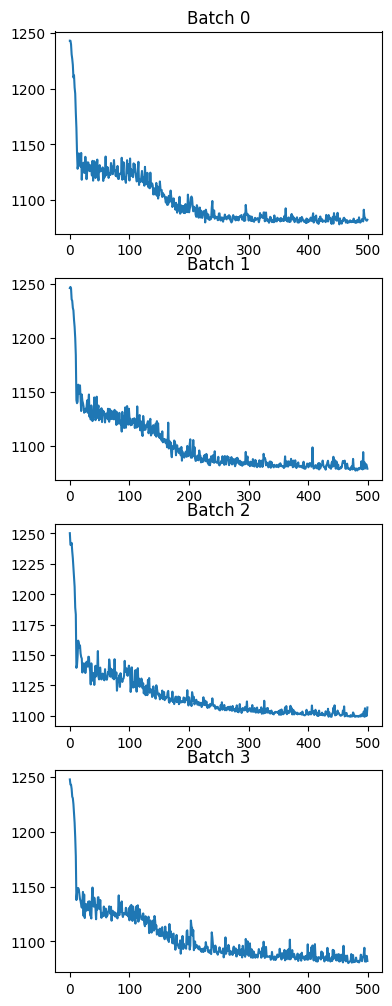

In [10]:
batch_plots(batch_loss_dict)

Done
tensor([[[ 7.8417e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           6.0176e-06,  5.8305e-38],
         [ 8.9053e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           2.9439e-04,  2.8523e-36],
         [ 4.6970e-01,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           3.3041e-02,  3.2013e-34],
         ...,
         [ 5.6069e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           1.7830e-02,  6.5948e-19],
         [ 5.7750e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          -3.0051e-03, -1.1174e-19],
         [ 6.1047e-02,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
           1.4673e-04,  5.4564e-21]],

        [[ 6.4693e-02,  0.0000e+00,  0.0000e+00,  ...,  5.3011e-39,
          -2.4533e-06,  1.4758e-37],
         [ 1.0249e-01,  0.0000e+00,  0.0000e+00,  ..., -8.2372e-37,
           3.8122e-04, -2.2932e-35],
         [ 4.6894e-01,  0.0000e+00,  0.0000e+00,  ..., -7.1705e-35,
           3.3186e-02, -1.9963e-33],
         ...,
         [ 5.6093e-0

 _  _   _  ___    _   _  _____ 
(_)( ) ( )(  _`\ ( ) ( )(_   _)
| || `\| || |_) )| | | |  | |  
| || , ` || ,__/'| | | |  | |  
| || |`\ || |    | (_) |  | |  
(_)(_) (_)(_)    (_____)  (_)  
                               
                               



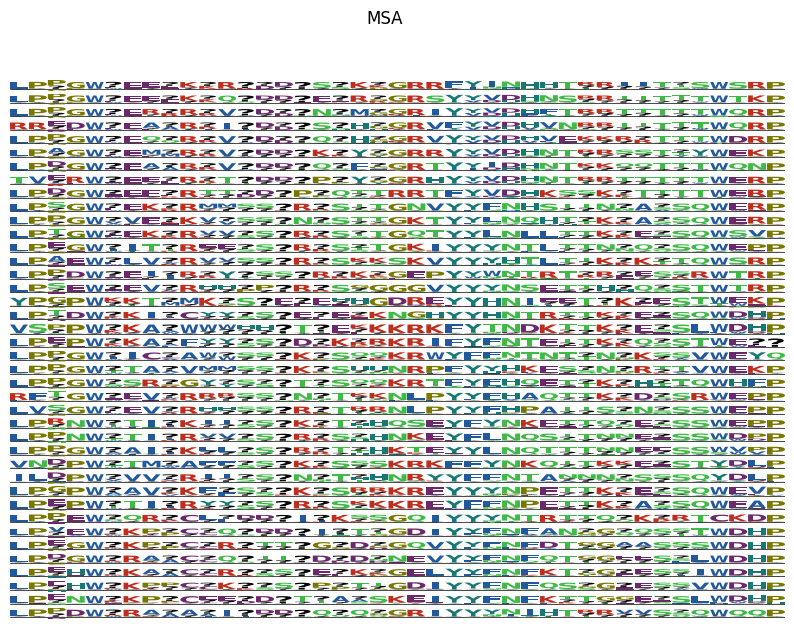

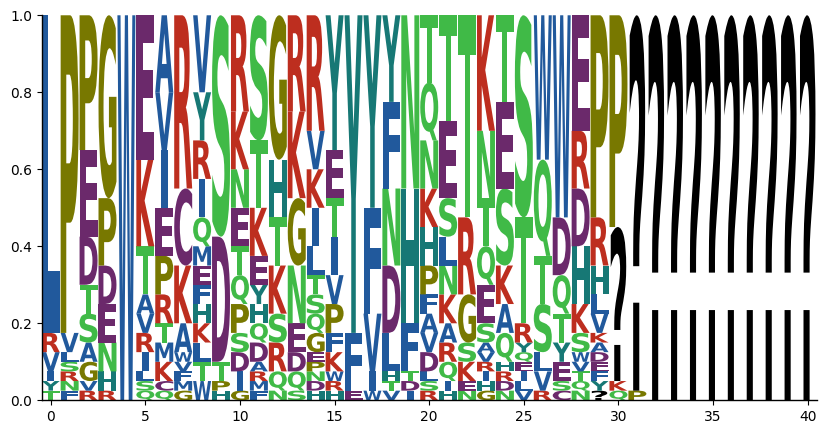

 ___    ___    ___    _____  _   _  ___   _____  ___    _   _  ___   _____  _ 
|  _`\ (  _`\ (  _`\ (  _  )( ) ( )(  _`\(_   _)|  _`\ ( ) ( )(  _`\(_   _)(_)
| (_) )| (_(_)| ( (_)| ( ) || `\| || (_(_) | |  | (_) )| | | || ( (_) | |  | |
| ,  / |  _)_ | |  _ | | | || , ` |`\__ \  | |  | ,  / | | | || |  _  | |  | |
| |\ \ | (_( )| (_( )| (_) || |`\ |( )_) | | |  | |\ \ | (_) || (_( ) | |  | |
(_) (_)(____/'(____/'(_____)(_) (_)`\____) (_)  (_) (_)(_____)(____/' (_)  (_)
                                                                              
                                                                              
 _____  _   _ 
(  _  )( ) ( )
| ( ) || `\| |
| | | || , ` |
| (_) || |`\ |
(_____)(_) (_)
              
              



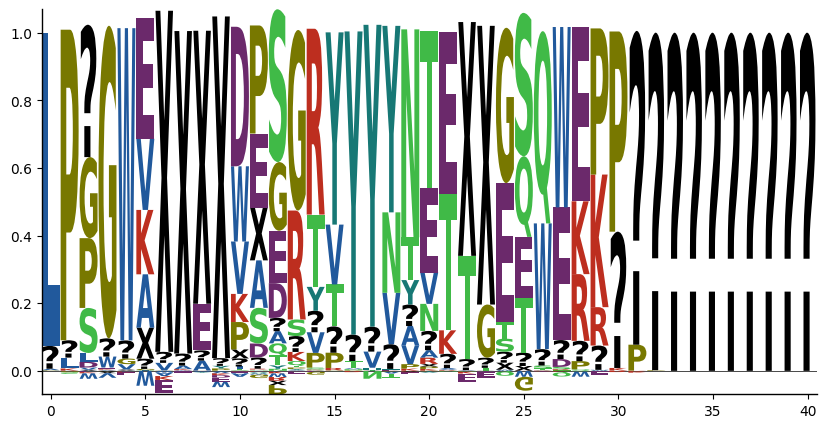

 _____  _      _  ___    _   _         ___    _   _  _____ 
(  _  )( )    (_)(  _`\ ( ) ( )/'\_/`\(  _`\ ( ) ( )(_   _)
| (_) || |    | || ( (_)| `\| ||     || (_(_)| `\| |  | |  
|  _  || |  _ | || |___ | , ` || (_) ||  _)_ | , ` |  | |  
| | | || |_( )| || (_, )| |`\ || | | || (_( )| |`\ |  | |  
(_) (_)(____/'(_)(____/'(_) (_)(_) (_)(____/'(_) (_)  (_)  
                                                           
                                                           



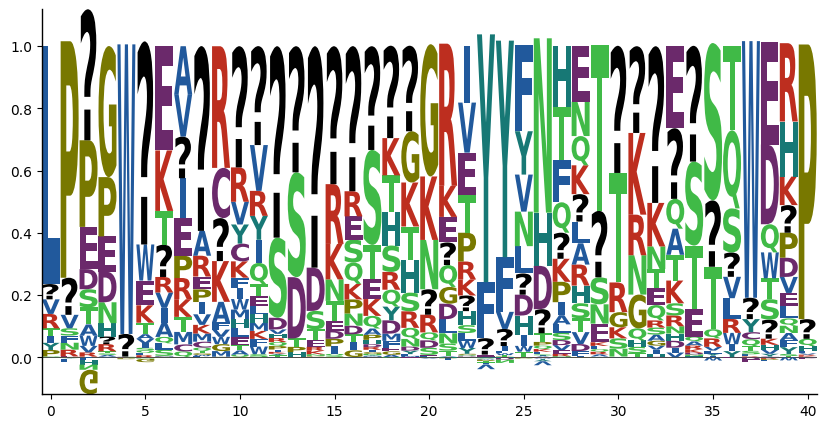

In [11]:
model.eval()
recon_data_train = model(dataset_msa.prot_space, deepseq)


print('Done')

from pyfiglet import Figlet
f = Figlet(font='puffy' ) #slant

print(recon_data_train[5])
alignment = recon_data_train[5]



plot_msa_from_preds(alignment.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)



print(f.renderText('INPUT'))
plot_logos_probs(dataset_msa.prot_space.detach().cpu(), alphabets)

print(f.renderText('RECONSTRUCTION'))
plot_logos_probs(recon_data_train[0].detach().cpu(), alphabets)

print(f.renderText('ALIGNMENT'))
plot_logos_probs(recon_data_train[5].detach().cpu(), alphabets)



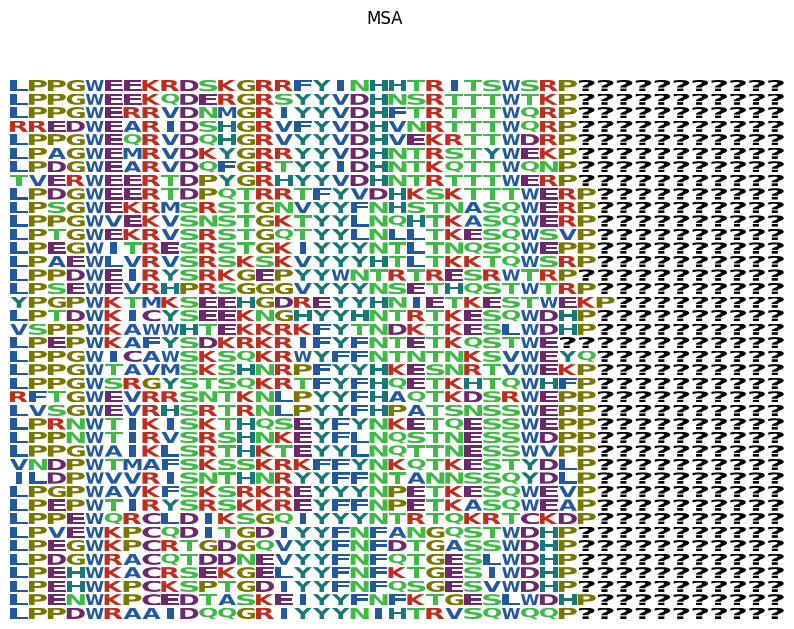

In [12]:
plot_msa_from_preds(trainloader.dataset.prot_space.detach().cpu(), alphabets, figsize=(10,7), show_axis=False)


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

IndexError: index 5 is out of bounds for axis 1 with size 5

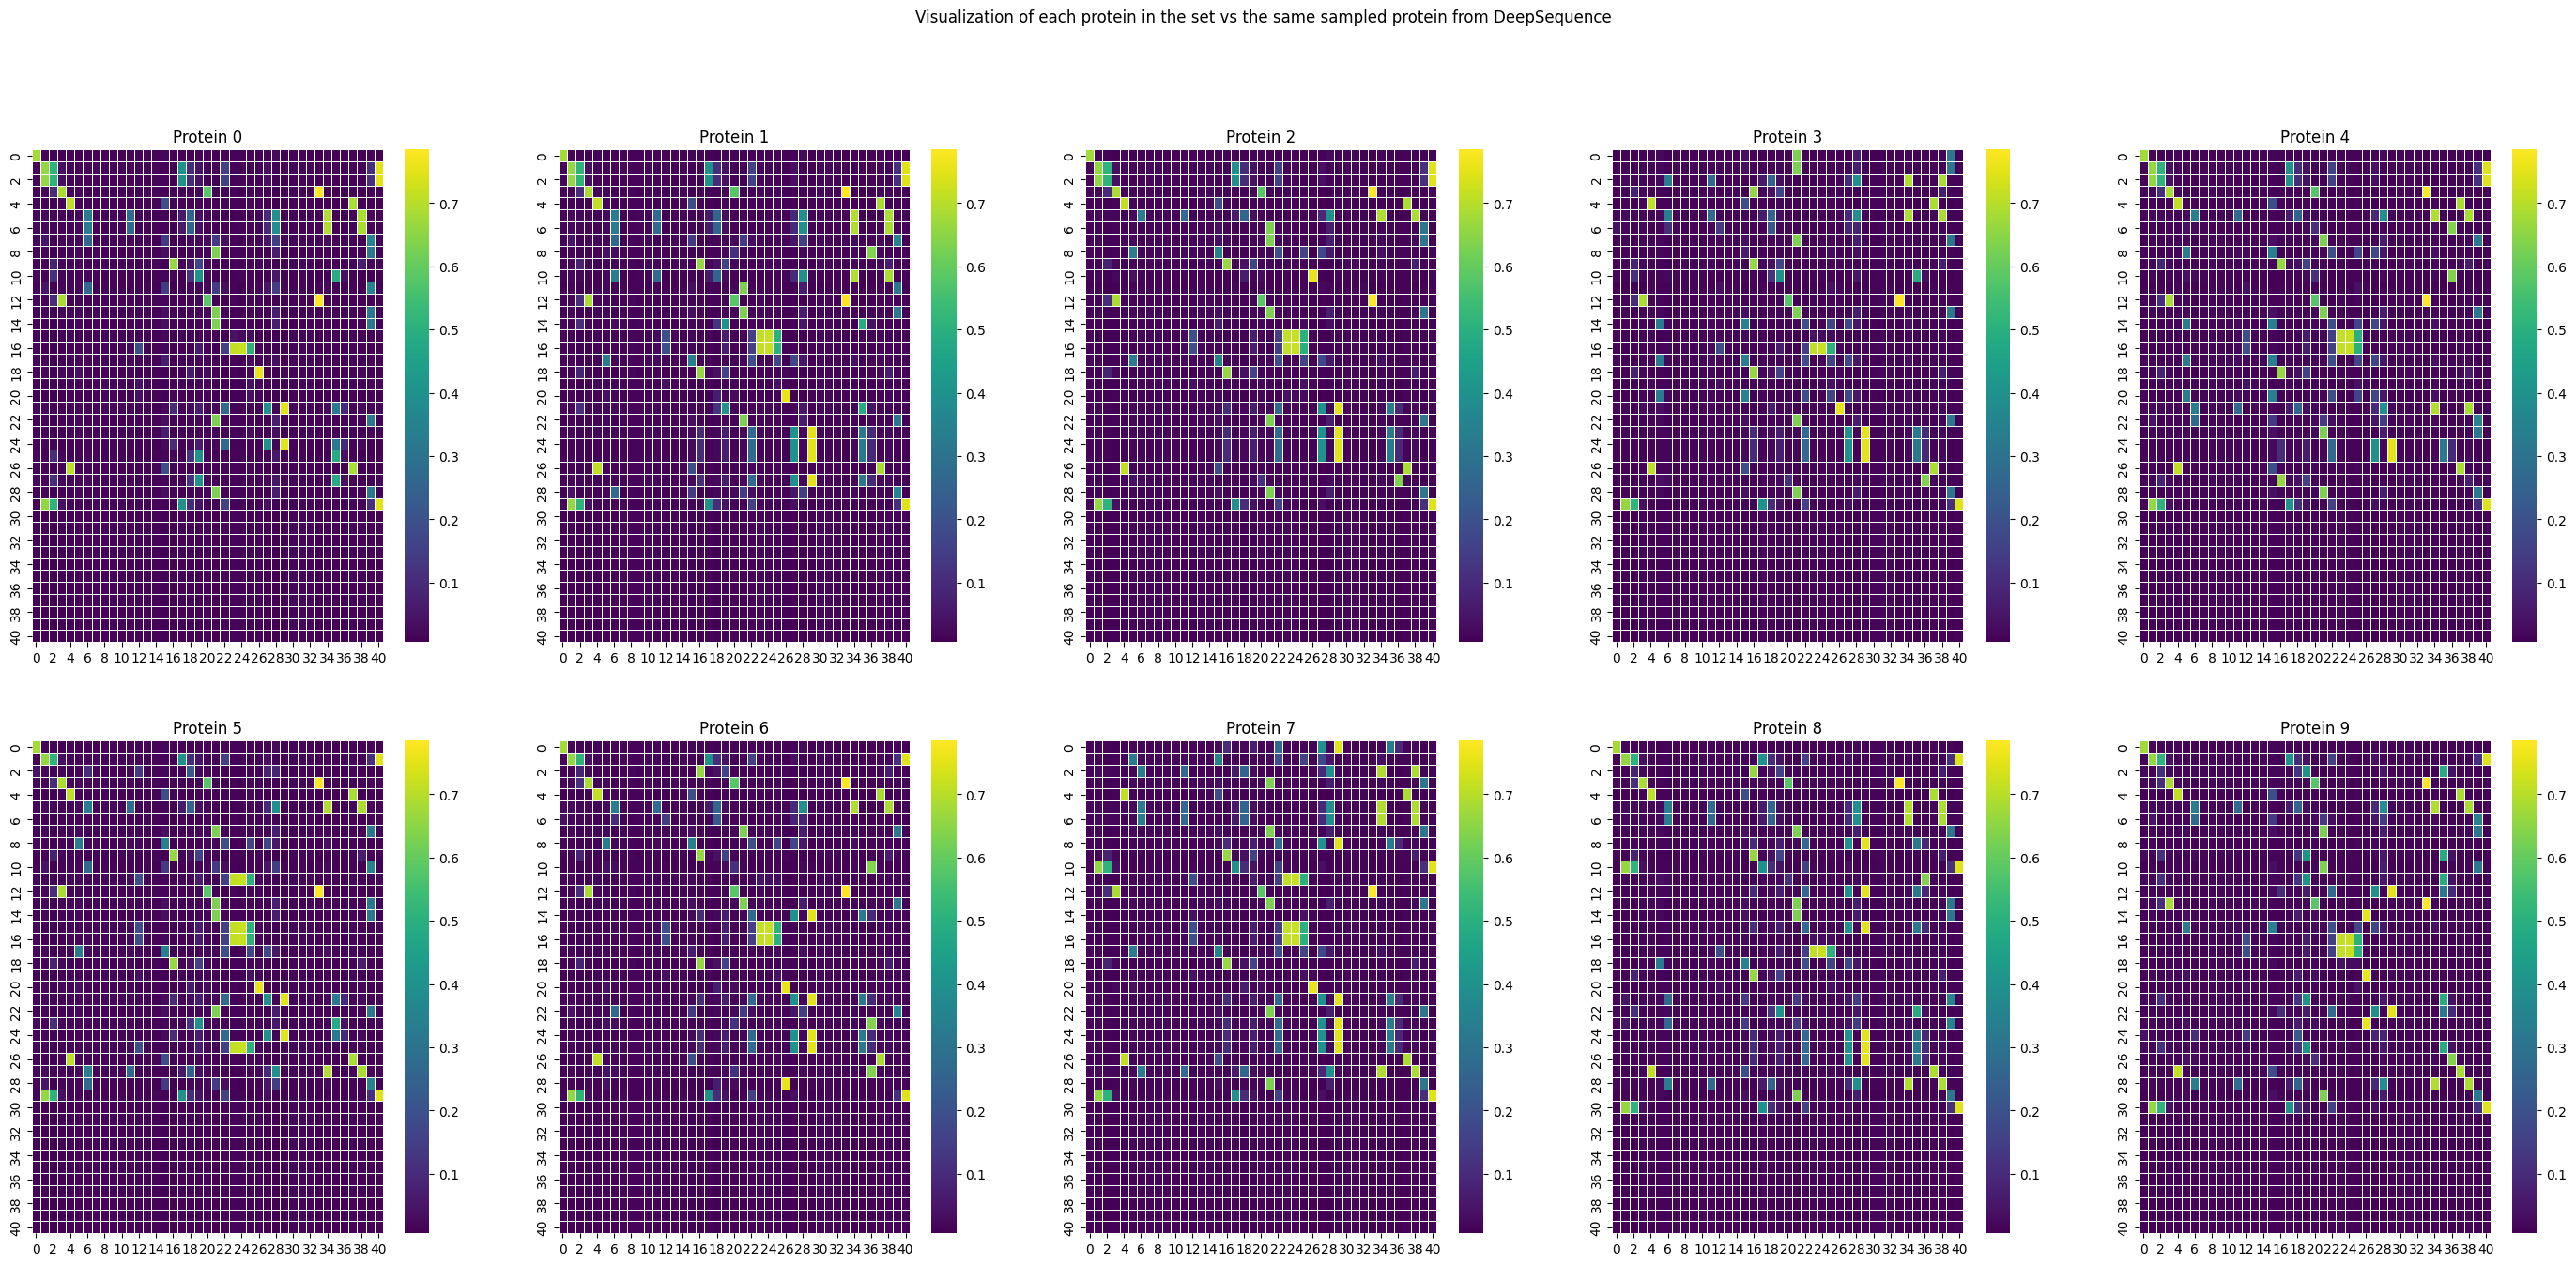

In [13]:
import seaborn as sns
import matplotlib.pylab as plt

def MonteCarlo_sampleDS(DS, iters):
    set_of_samples = [ DS.sample(1)[0] for i in range(0,iters)]
    MC_sample = torch.mean(torch.stack(set_of_samples), dim=0)
    return MC_sample

def energy_info_DSsampling_vs_Raw(DS, batch_seqs):

    #import ipdb; ipdb.set_trace()
    batch_size = batch_seqs.shape
    raw_seqs = batch_seqs; DS.eval()
    sampled_seqs = MonteCarlo_sampleDS(DS,100)

    sampled_seqs = sampled_seqs.permute(0,2,1)

    # One Sampled Protein from Deep Sequence vs all 10 proteins
    fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
    fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')
    list_of_attentions = []
    for cont, prot in enumerate(raw_seqs):
        # One Sampled Protein from Deep Sequence vs all 10 proteins
        ii,jj = ((1,cont-5), (0,cont))[cont < 5]
        seq = torch.matmul(prot,sampled_seqs[0])
        list_of_attentions.append(seq.detach().cpu())
        axes1vs10[ii,jj].set_title('Protein ' + str(cont))
        sns.heatmap(seq.detach().cpu().numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])
    
    plt.show()
    return list_of_attentions


import torch.nn.functional as F

def get_diagonal_attention(Matrix, comp, min_r, max_r, list_attention = []):
    # Works assuming that we are dealing with square matrixes
    if comp <= max_r and comp >= min_r:
        list_attention.append( torch.cat( (torch.tensor([0.0]*abs(comp)) , torch.diagonal(Matrix, comp)) ) )
        get_diagonal_attention(Matrix, comp-1, min_r, max_r, list_attention)

def get_batch_diagonal_attention(Matrix, comp, min_r, max_r):
    list_batch = []
    list_attention = []
    for m in Matrix:
        get_diagonal_attention(m, comp, min_r, max_r, list_attention )
        list_batch.append( torch.stack(list_attention) )
        list_attention.clear()

    batch_diag_attention = torch.stack(list_batch)
    return batch_diag_attention


attentions = energy_info_DSsampling_vs_Raw( deepseq, dataset_msa.prot_space.detach())



In [ ]:
att = get_batch_diagonal_attention(attentions,10,-10, 10)

figatt, axesatt = plt.subplots(2, 5, figsize=(35,15))
figatt.suptitle('Visualization attention diagonals')

for cont, at in enumerate(att):
    # One Sampled Protein from Deep Sequence vs all 10 proteins
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axesatt[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(at.numpy(), linewidth=0.5, cmap='viridis', ax=axesatt[ii,jj])
    
plt.show()

'''
Matrix = torch.tensor([[1,2,3,4,5],[33,44,55,66,77],[333,444,555,666,777],[3333,4444,5555,6666,7777],[33333,44444,55555,66666,77777]])
list_attention = []
get_diagonal_attention(Matrix, 2, -2, 2, list_attention)

Matrix2 = Matrix.repeat(2,1,1)
get_batch_diagonal_attention(Matrix2, 2, -2, 2)

print(list_attention)
'''

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import LogNorm, Normalize

fig1vs10, axes1vs10 = plt.subplots(2, 5, figsize=(35,15))
fig1vs10.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

def lognormalize(x):
    a = np.logaddexp.reduce(x)
    return np.exp(x - a)

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap(prot.numpy(), linewidth=0.5, cmap='viridis', ax=axes1vs10[ii,jj])

plt.show()

fig1vs10_log, axes1vs10_log = plt.subplots(2, 5, figsize=(35,15))
fig1vs10_log.suptitle('Visualization of each protein in the set vs the same sampled protein from DeepSequence')

for cont, prot in enumerate(attentions):
    # One Sampled Protein from Deep Sequence vs all 10 proteins 
    ii,jj = ((1,cont-5), (0,cont))[cont < 5]
    axes1vs10_log[ii,jj].set_title('Protein ' + str(cont))
    sns.heatmap( prot.numpy() , linewidth=0.5, cmap='viridis', ax=axes1vs10_log[ii,jj], norm=LogNorm())

plt.show()